# Introduction
## Context
You have been approached by a prospective customer in the banking sector. The customer is an issuing bank seeking a machine learning solution to solve a growing fraud problem. The bank’s customers are having their cards defrauded and their money is being spent by fraudsters. This is causing customer dissatisfaction and costing the bank money (the bank has to cover fraud losses), so the bank is looking into introducing better fraud monitoring  of activity on their customers’ cards.

They plan to have a small team of fraud analysts who review risky-looking purchases and decide whether to allow or block the transaction. This team will have the capacity to review 400 transactions a month. The outputs/results from your model will be used to decide which transactions the fraud analysts should review. The bank is requesting that after working these alerts, as much fraud value as possible has been prevented. If possible, the client also wants the model to be as explainable as possible.

The bank has provided 1 year of historical transactional data and fraud flags and asked you to build a model which predicts the likelihood that a transaction is later marked as fraud. They have also provided a brief data dictionary, which describes some general payments terms. You are given 2 weeks to complete the project.

## Data Dictionary
Features descriptions:
| Field | Description |
|-------|-------------|
| transactionTime | The time the transaction was requested. |
| eventId | A unique identifying string for this transaction |
| accountNumber | The account number which makes the transaction |
| merchantId | A unique identifying string for this merchant |
| mcc | The merchant category code of the merchant |
| transactionAmount | The value of the transaction in GBP |
| posEntryMode | The Point Of Sale entry mode |
| availableCash | The (rounded) amount available to spend prior to the transaction |
| merchantCountry | A unique identifying string for the merchant's country |
| merchantZip | A truncated zip code for the merchant's postal region |

`posEntryMode` values:
| posEntryMode | Description |
|--------------|-------------|
| 00 | Entry Mode Unknown |
| 01 | POS Entry Mode Manual |
| 02 | POS Entry Model Partial MSG Stripe |
| 05 | POS Entry Circuit Card |
| 07 | RFID Chip (Chip card processed using chip) |
| 80 | Chip Fallback to Magnetic Stripe |
| 81 | POS Entry E-Commerce |
| 90 | POS Entry Full Magnetic Stripe Read |
| 91 | POS Entry Circuit Card Partial |

## Datasets
* transactions_obf.csv
    * Contains ~118 000 transactions over a span of a year
* labels-obf.csv
    * Contains transactions flagged as fraudulent. Contains `eventId` and `reportedTime`
    * `eventId` ties the transaction to *transactions_obf.csv*

## Objective
Develop a classification model to predict whether the transaction is fraudulent. A value of `1` indicates potentially fraudulent transactions, while `0` indicates a normal transaction.

The performance metric for this study is **accuracy**.

## Summary
The dataset was very imbalanced, with less than 0.8% fraud transactions. The study created new features, including time-based rolling aggregations and used a custom time-based cross validation algorithm to prevent data leakage.

During model training, the study aimed to optimize AUPRC and trained five ML models. Additionally, the study tested multiple class imbalance handling methods, such as Undersampling, Random Walk Oversampling and Class Weights. Logistic Regression with undersampling provided the best results individually.

To maximize performance, the study created ensemble models, leveraging the strengths of multiple models. Voting Classifier ensemble had the most tuning flexibility, and the study explored different model weights based on metrics to optimize. The AUPRC-tuned Voting Classifier had the best performance, with a good balance of true and false positives, including a very confident class differentiation.

Model results:
* AUPRC: 0.23
* AUROC: 0.90
* FP: 27.64%
* TP: 0.62% (88% of total fraud)

To evaluate the model's applicability in business, the study defined scenarios with their respective fraud catch rates. The study found that setting the model at the threshold of 0.45 and analyzing 95 of alerts that the model produces daily would help the bank capture 91% of all fraud cases. 

# Data Preparation
## Modules, Functions Import & Configuration

In [54]:
# ==========================
# Standard Library Imports
# ==========================
import os
import warnings
import logging
import joblib

# ==========================
# Data Analysis & Visualization
# ==========================
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import HTML, Image

# ==========================
# Machine Learning Libraries
# ==========================
# Models & Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import StandardScaler
from imblearn.ensemble import BalancedRandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Metrics
from sklearn.metrics import classification_report

# ==========================
# Project-Specific Utilities
# ==========================
from utils import (
    get_screen_width,
    set_font_size,
    custom_format,
    create_features,
    check_duplicates,
    visualize_folds,
    find_and_analyze_infinite_values,
    prepare_dataset,
    summarize_results,
    train_model,
    phik_matrix,
    visualize_performance,
    get_column_dtypes,
    run_optimization,
    evaluate_model,
    missing_values,
    analyze_monthly_fraud,
    boolean_analysis,
    datetime_analysis,
    calculate_ensemble_feature_importance,
    plot_feature_importances,
    calculate_mutual_information_smote,
    numerical_predictor_significance_test,
    interpret_results_numerical,
    draw_predictor_numerical_plots,
    categorical_predictor_significance_test,
    interpret_results_categorical,
    draw_predictor_categorical_plots,
    optimize_ensemble_weights,
    plot_model_importances,
    plot_probability_distribution,
    analyze_thresholds,
    find_optimal_threshold,
    print_threshold_summary,
)

# Constants
from utils import COLOR_PALETTE, RANDOM_STATE, DATA_FOLDER
from utils import CustomTimeSeriesSplitter

In [55]:
# Notebook Code Settings
TRAIN_MODELS = True
TUNE_MODELS = False
TRAIN_VOTING = True
TRAIN_STACKING = True
CALCULATE_SHAP = True

In [56]:
# Suppress Warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.getLogger("lightgbm").setLevel(logging.CRITICAL)
os.environ["LIGHTGBM_VERBOSE"] = "-1"

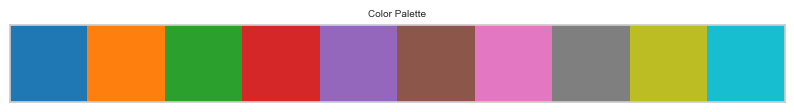

In [57]:
# Define random state, set visualization parameters
fig_width = get_screen_width() / 100
font_sizes = set_font_size()
plt.rcParams.update(font_sizes)
pd.set_option("display.max_colwidth", None)
pd.options.display.float_format = custom_format
pd.set_option("display.max_rows", None)
HTML("<style>{}</style>".format(open("styles.css").read()))
display(
    HTML(
        """
    <style>
        .output_scroll {
            overflow: visible !important;
        }
    </style>
"""
    )
)

# Color style
color_palette = COLOR_PALETTE
sns.set_theme(font_scale=0.6)
sns.set_palette(color_palette)
sns.set_style("whitegrid", {"axes.grid": False})
sns.palplot(color_palette)
plt.title("Color Palette")
plt.show()

## Dataset Import

In [58]:
df = pd.read_csv(os.path.join(DATA_FOLDER, "transactions_obf.csv"))
df_labels = pd.read_csv(os.path.join(DATA_FOLDER, "labels_obf.csv"))

In [59]:
df.head()

transactionTime     eventId accountNumber merchantId   mcc  \
0  2017-01-01T00:00:00Z  18688431A1      94f9b4e7     b76d06  5968   
1  2017-01-01T00:49:03Z   2164986A1      648e19cf     718cc6  5499   
2  2017-01-01T00:43:17Z  31294145A1      c0ffab1b     94cafc  5735   
3  2017-01-01T00:15:07Z  11162049A1      038099dd     7d5803  5499   
4  2017-01-01T00:37:09Z  17067235A1      3130363b     12ca76  5411   

   merchantCountry merchantZip  posEntryMode  transactionAmount  availableCash  
0              826         CR0             1              10.72           7500  
1              826        DE14            81              21.19           4500  
2              442         NaN            81               5.04           9500  
3              826         NR1            81                 21           7500  
4              826         M50            81                 47          10500

In [60]:
df_labels.head()

reportedTime      eventId
0  2017-01-04T00:00:00Z  101536329A1
1  2017-01-04T00:00:00Z  101536425A1
2  2017-01-04T00:00:00Z  101536473A1
3  2017-01-04T00:00:00Z  101536617A1
4  2017-01-04T00:00:00Z  101536761A1

In [61]:
# Check for duplicate eventId in df_labels
df_labels.duplicated("eventId").sum()

0

Next, let's merge `df` and `df_labels` to have transactions and fraud flags in one DataFrame. Additionally, perform some datatype conversions.

In [62]:
df = df.merge(df_labels, how="left", on="eventId")
df["fraud"] = df["eventId"].isin(df_labels["eventId"])

# Perform initial datatype conversions
conversions = {
    "mcc": str,
    "merchantCountry": str,
    "posEntryMode": str,
}
df["posEntryMode"] = df["posEntryMode"].astype(str).str.zfill(2)
df = df.astype({col: func for col, func in conversions.items()})
df["transactionTime"] = pd.to_datetime(df["transactionTime"])
df["reportedTime"] = pd.to_datetime(df_labels["reportedTime"])

In [63]:
print(f"Dataset size: {df.shape[0]} rows, {df.shape[1]} columns")

Dataset size: 118621 rows, 12 columns


<div class="next-steps">
    <h3>Observations</h3>
    <p></p>
    <ol>
        <ul>Dataset contais 118,000+ rows</ul>
        <ul>11 features, binary label</ul>
    </ol>
</div>

# Data Formatting & Cleaning

## Correct
* Check for duplicates, remove if necessary.
* Check statistical summaries, remove errors.

In [64]:
check_duplicates(df.drop("eventId", axis=1), "Bank Transactions")

DataFrame: Bank Transactions
Total rows: 118621
Duplicate rows: 0



In [65]:
df.dtypes

transactionTime      datetime64[ns, UTC]
eventId                           object
accountNumber                     object
merchantId                        object
mcc                               object
merchantCountry                   object
merchantZip                       object
posEntryMode                      object
transactionAmount                float64
availableCash                      int64
reportedTime         datetime64[ns, UTC]
fraud                               bool
dtype: object

### Statistical Summary - Numerical Columns

In [66]:
numerical_columns = df.select_dtypes(include=[np.number]).columns
round(df[numerical_columns].describe(), 2)

transactionAmount  availableCash
count             118621         118621
mean               53.67        6625.51
std               183.67        3410.29
min                -0.15            500
25%                 8.03           4500
50%                20.25           7500
75%                   49           8500
max                13348          18500

<div class="next-steps">
    <h3>Observations</h3>
    <p>Numerical Columns</p>
    <ol>
        <ul>Two numeric features, none are missing values</ul>
        <ul>The negative <code>min</code> value for <code>transactionAmount</code> that there might be small adjustments or credits among the transactions</ul>
        <ul>Based on the <code>max</code> amounts for both features, the bank serves small clients with reasonable savings</ul>
    </ol>
</div>

### Statistical Summary - Categorical Columns

In [67]:
categorical_columns = (
    df.drop("eventId", axis=1).select_dtypes(exclude=[np.number]).columns
)
round(df[categorical_columns].describe(), 2)

transactionTime accountNumber merchantId     mcc  \
count                                118621        118621     118621  118621   
unique                                  NaN           766      33327     361   
top                                     NaN      66b2f8b3     96878e    5411   
freq                                    NaN          1312       3294   23937   
mean    2017-07-15 22:39:27.381526016+00:00           NaN        NaN     NaN   
min               2017-01-01 00:00:00+00:00           NaN        NaN     NaN   
25%               2017-04-09 02:56:29+00:00           NaN        NaN     NaN   
50%               2017-07-18 09:13:20+00:00           NaN        NaN     NaN   
75%               2017-10-17 19:41:42+00:00           NaN        NaN     NaN   
max               2018-01-31 00:04:44+00:00           NaN        NaN     NaN   

       merchantCountry merchantZip posEntryMode               reportedTime  \
count           118621       95616       118621                        875   
unique              82        3260           10                        NaN   
top                826           0           05                        NaN   
freq             95616       14474        70228                        NaN   
mean               NaN         NaN          NaN  2017-08-03 09:36:00+00:00   
min                NaN         NaN          NaN  2017-01-04 00:00:00+00:00   
25%                NaN         NaN          NaN  2017-06-02 12:00:00+00:00   
50%                NaN         NaN          NaN  2017-07-21 00:00:00+00:00   
75%                NaN         NaN          NaN  2017-10-27 00:00:00+00:00   
max                NaN         NaN          NaN  2018-02-24 00:00:00+00:00   

         fraud  
count   118621  
unique       2  
top      False  
freq    117746  
mean       NaN  
min        NaN  
25%        NaN  
50%        NaN  
75%        NaN  
max        NaN

In [68]:
categorical_summary = []
exclude_columns = ["eventId", "accountNumber", "merchantId"]
for col in df.columns:
    if df[col].dtype == "object" and col not in exclude_columns:
        unique_values = df[col].unique()
        categorical_summary.append(
            {
                "Column": col,
                "Unique Values Count": len(unique_values),
                "Unique Values": unique_values,
            }
        )
pd.DataFrame(categorical_summary)

Column  Unique Values Count  \
0              mcc                  361   
1  merchantCountry                   82   
2      merchantZip                 3261   
3     posEntryMode                   10   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Unique Values  
0  [5968, 5499, 5735, 5411, 5999, 4112, 4812, 5541, 4816, 7512, 5967, 5814, 5977, 5309, 7523, 4814, 4784, 5969, 7922, 5722, 5964, 5651, 5542, 7011, 5691, 7399, 8911, 5812, 3389, 4214, 5942, 4468, 4722, 5941, 5641, 5712, 5211, 7221, 5261, 8999, 5311, 7210, 5940, 5732, 5533, 5992, 5921, 7538, 5661, 6011, 6012, 5251, 5912, 7299, 8220, 5813, 5399, 8021, 7278, 7273, 8398, 9402, 5310, 7372, 8049, 5621, 5072, 5965, 5714, 7994, 5994, 3246, 7311, 8931, 6300, 7321, 5947, 5655, 8299, 5065, 7230, 7991, 5511, 5993, 9399, 5995, 5932, 4511, 5946, 5733, 7941, 8699, 5972, 8111, 742, 8043, 5943, 5192, 5713, 5532, ...]  
1                                                                                                                                                                                                              [826, 442, 392, 36, 372, 196, 840, 344, 276, 724, 300, 380, 528, 250, 756, 470, 156, 292, 40, 620, 484, 792, 710, 480, 578, 31, 752, 784, 144, 659, 818, 203, 60, 124, 352, 554, 336, 246, 48, 788, 191, 56, 702, 764, 591, 208, 76, 704, 534, 643, 492, 616, 376, 356, 233, 348, 100, 438, 642, 462, 504, 404, 214, 608, 116, 32, 531, 804, 446, 152, 458, 662, 388, 50, 52, 703, 268, 634, 312, 566, 410, 158]  
2                                                         [CR0, DE14, nan, NR1, M50, KT11, SW1H, 0, NG7, LU2, V6C, RH6, CO10, ...., IP4, HA1, IP24, CM14, AL10, DL1, NN4, BT1, LS63, DN14, JE2, EC1Y, NW1, ..., SA64, M60, PL9, S20, TA21, W1W, DL7, SS7, WR14, NI, G66, G64, SE1, SO51, B11TT, SO23, HA9, KT13, SL4, G62, PO6, BN27, PL7, SO30, FK21, SS0, LU6, SP8, WF17, AB25, SP2, NW9, RH5, HA8, SN12, CH65, DG16, WF18, NG2, BD23, EC2A, GU21, UB4, RG9, MK6, NW10, BS6, BT40, WC2E, SW1Y, PL26, WD17, SW1, SY11, W1A, PL4, CB8, HU2, CA3, KT18, NW4, EH21, SO43, EC2M, EC4R, WC1V, W26LA, S49, WR3, RG14, OL2, ST3, ...]  
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      [01, 81, 90, 05, 80, 07, 00, 79, 02, 91]

<div class="next-steps">
    <h3>Observations</h3>
    <p>Categorical Columns</p>
    <ol>
        <ul>6 features, out of which only <code>merchantZip</code> is missing values</ul>
        <ul>Very high cardinality in <code>merchantId</code> and <code>merchantZip</code>, medium cardinality for <code>merchantCountry</code></ul>
        <ul>Vendor countries <code>merchantCountry</code> are number-coded</ul>
    </ol>
</div>

### Statistical Summary - Other Columns

In [69]:
bool_stats = boolean_analysis(df, ["fraud"])
bool_stats.T

column            fraud
count            118621
null_count            0
true_count          875
false_count      117746
true_percentage    0.74
false_percentage  99.26

In [70]:
datetime_stats = datetime_analysis(df, ["reportedTime", "transactionTime"])
datetime_stats.T

column                                   reportedTime  \
count                                             875   
min                               2017-01-04 00:00:00   
max                               2018-02-24 00:00:00   
range                               416 days 00:00:00   
mode                        2017-06-25 00:00:00+00:00   
null_count                                     117746   
unique_count                                      145   
avg_transactions_per_month                         62   
max_transactions_in_month                         155   
min_transactions_in_month                           9   
total_months                                       14   
busiest_month                                 2017-06   
slowest_month                                 2018-02   

column                                transactionTime  
count                                          118621  
min                               2017-01-01 00:00:00  
max                               2018-01-31 00:04:44  
range                               395 days 00:04:44  
mode                        2017-01-11 05:31:24+00:00  
null_count                                          0  
unique_count                                   118105  
avg_transactions_per_month                       9125  
max_transactions_in_month                       11213  
min_transactions_in_month                        8166  
total_months                                       13  
busiest_month                                 2017-08  
slowest_month                                 2017-11

<div class="next-steps">
    <h3>Observations</h3>
    <p>Other Columns</p>
    <ol>
        <ul>Target feature is very imbalanced, with only 0.74% of transactions marked as fraud</ul>
        <ul>The transactions span 13 months, with about 9,000 transactions per month, up to 11,000</ul>
        <ul>All fraudulent transactions have their flag date <code>reportedTime</code></ul>
    </ol>
</div>

## Complete
Deal with missing values in the dataset.

In [71]:
missing_values(df)

Data Type  Count #  Perc %
reportedTime       datetime64[ns, UTC]   117746   99.30
merchantZip                     object    23005   19.40
transactionTime    datetime64[ns, UTC]        0       0
eventId                         object        0       0
accountNumber                   object        0       0
merchantId                      object        0       0
mcc                             object        0       0
merchantCountry                 object        0       0
posEntryMode                    object        0       0
transactionAmount              float64        0       0
availableCash                    int64        0       0
fraud                             bool        0       0

Dealing with missign values:
* Since `reportedTime` was entered later after the transaction occurred and does not provide any additional predictive power to the model, we will remove it.
* The `merchantZip` missing values will be imputed as 'Unknown'

In [72]:
df = df.drop("reportedTime", axis=1)
df["merchantZip"] = df["merchantZip"].fillna("Unknown")

<div class="next-steps">
    <h3>Observations</h3>
    <p>Missing values</p>
    <ol>
        <ul>Only two features had missing values</ul>
        <ul><code>reportedTime</code> was removed because it was entered by the bank after the transaction was found to be fraudulent, and does not present any predictive power</ul>
        <ul>Missing values for <code>merchantZip</code> were imputed with <b>Unknown</b></ul>
    </ol>
</div>

## Create
Create additional features based on provided dataset context to improve EDA. We will create two categories of features:
* Features that don't depend on time series;
* Time-dependent features that leverage transaction times.

### MCC Category Features
- `mccCategory`: Extracts the first two digits of the MCC code which represent the main business category.
- `isHighRiskCategory`: A boolean flag indicating whether the merchant's category has historically been associated with higher fraud rates, based on a predefined list of high-risk MCCs.

### POS Entry Mode Features

- `posEntryRiskScore`: A risk score between 0 and 1 assigned to different types of card entry methods, with unknown methods having highest risk (1.0) and chip-based methods having lowest risk (0.2-0.4).
- `isCardPresent`: A boolean flag indicating whether the transaction was conducted with the physical card present (modes 05, 07, 90, 91).
- `isFallback`: A boolean flag indicating whether the transaction used chip fallback mechanism (mode 80).
- `isEcommerce`: A boolean flag indicating whether the transaction was conducted online (mode 81).
- `isManualEntry`: A boolean flag indicating whether the card details were manually entered (mode 01).

### Amount Pattern Features

- `isRoundAmount`: A boolean flag indicating whether the transaction amount is a whole number (e.g., 100.00 vs 99.99).
- `isCommonAmount`: A boolean flag indicating whether the transaction amount matches common withdrawal values (10, 20, 50, 100, 200, 500).
- `cashUtilizationRate`: A ratio calculating how much of the available cash limit is being used in this transaction.

### Time-based Features

- `hourOfDay`: The hour (0-23) when the transaction occurred.
- `isWeekend`: A boolean flag indicating whether the transaction occurred on Saturday or Sunday.
- `isLateNight`: A boolean flag indicating whether the transaction occurred during high-risk hours (11 PM - 4 AM).
- `hourOfDay_sin`: A sinusoidal encoding of the hour to capture cyclical patterns in time.
- `hourOfDay_cos`: A cosinusoidal encoding of the hour to capture cyclical patterns in time.

### Geographical Features

- `isInternational`: A boolean flag indicating whether the transaction occurred outside the most common country in the dataset.
- `zipMatchesCountry`: A boolean flag indicating whether the provided zip code format matches the expected format for the merchant's country.

### Transaction Pattern Features
- `timeSinceLastTransaction`: Number of hours since the last transaction for this account, with first transactions set to 8760 hours (1 year).

### POS Entry Mode Pattern Features
- `unusualEntryMode`: Boolean flag indicating if the current entry mode differs from the account's most common entry mode.
- `entryModeChanged`: Boolean flag indicating if the entry mode changed from the previous transaction.

### Amount-based Features
- `runningAvgTransactionAmount`: Running average of all transaction amounts for this account up to the current point.
- `merchantAvgTransactionAmount`: Running average of all transaction amounts for this merchant up to the current point.

### Merchant-based Features
- `isNewMerchant`: Binary indicator showing if this is the first time the account has transacted with this merchant.
- `uniqueMerchantCount`: Running count of unique merchants this account has transacted with.

### MCC-based Features
- `spendingPercentageByMCC`: Percentage of total spending in this MCC category relative to account's total spending.
- `mccDiversity`: Ratio of unique MCCs to total transaction count, measuring variety in merchant categories used.

### Pattern Change Detection
- `avgAmountChange`: Percentage change in transaction amount compared to previous transaction.
- `freqChange`: Percentage change in time between transactions compared to previous interval.

### Quick Succession Features
- `isQuickSuccession`: Boolean flag indicating if transaction occurred within 5 minutes of previous transaction.
- `quickSuccessionCount_1H`: Count of quick succession transactions in the past hour.

### Cash Flow Analysis
- `cashDepletionRate`: Rate at which available cash is being depleted, capped at 100%.

### Rolling Window Features (7-day)
- `transactionAmount_mean_7D`: Mean transaction amount over past 7 days.
- `transactionAmount_std_7D`: Standard deviation of transaction amounts over past 7 days.
- `availableCash_mean_7D`: Mean available cash over past 7 days.
- `availableCash_std_7D`: Standard deviation of available cash over past 7 days.

### Fraud Pressure Features
- `fraudPressure_1H`: Ratio of transactions in past hour to total transactions.
- `fraudPressure_1D`: Ratio of transactions in past day to total transactions.

### Multi-window Transaction Features (1H, 1D, 7D windows)
- `transactionCount_{window}`: Count of transactions in specified time window.
- `transactionAmount_{window}`: Sum of transaction amounts in specified time window.
- `unique_entry_modes_{window}`: Count of unique entry modes used in specified time window.

### Risk Combination Feature
- `highRiskCombo`: Boolean flag indicating presence of high-risk combinations:
  - Manual entry with high amount (>95th percentile)
  - Fallback with international transaction
  - E-commerce with unusual entry mode

For proper time-based analysis, we will have to deal with duplicate timestamps; Some clients made more than one transaction at the same time, which creates problems if we were to calculate more granular time-based statistics, since the timestamp has to be the index.

We will add 1ms to each repeating timestamp to differentiate the two transactions.

In [73]:
df["transactionTime"] = (
    pd.to_datetime(df["transactionTime"]).dt.tz_convert("UTC").dt.tz_localize(None)
)
df = df.sort_values("transactionTime")
cc = df.groupby("transactionTime").cumcount()
df.index = df["transactionTime"] + pd.to_timedelta(cc, unit="ms")

The index has been adjusted. Let's create the new features.

In [74]:
print(f"Dataset size: {df.shape[0]:,} instances and {df.shape[1]-1:,} features")
df = create_features(df, window="30D")
print(
    f"Dataset size (post-FE): {df.shape[0]:,} instances and {df.shape[1]-1:,} features"
)

Dataset size: 118,621 instances and 10 features
Dataset size (post-FE): 118,621 instances and 54 features


44 new features were created. Let's check whether we have any missing data.

In [75]:
missing_values(df, missing_only=True)

Empty DataFrame
Columns: [Data Type, Count #, Perc %]
Index: []

Additionally, let's check whether the dataset contains infinite values that models might have issues with.

In [76]:
find_and_analyze_infinite_values(df)

No rows with infinite values found.


Let's remove some columns with high cardinality that will not be necessary in further analysis:
* `transactionTime` - we have derived informative features from it; The timestamps are no longer necessary.
* `eventId` - unique transaction identifier, not needed for EDA, not modeling.
* `accountNumber`, `merchantId` - unique identifiers for client and merchant bank accounts. We derived important aggregations from these features, and keeping these identifiers in their raw form would introduce learning bias.
* `merchantZip`, `merchantCountry`, `merchantZip` - very high cardinality, We extracted useful information from these features.
* `posEntryMode` - we derived multiple boolean flags out of this feature; we can now remove it to prevent multicollinearity.

In [77]:
df = df.drop(
    [
        "transactionTime",
        "eventId",
        "accountNumber",
        "merchantId",
        "merchantZip",
        "mcc",
        "merchantCountry",
        "posEntryMode",
    ],
    axis=1,
)

## Convert
Review and change columns` datatypes, if necessary.

In [78]:
get_column_dtypes(df)

dtype
fraud                            bool
isHighRiskCategory               bool
isCardPresent                    bool
isFallback                       bool
isEcommerce                      bool
isManualEntry                    bool
isRoundAmount                    bool
isWeekend                        bool
isLateNight                      bool
isInternational                  bool
zipMatchesCountry                bool
unusualEntryMode                 bool
entryModeChanged                 bool
isQuickSuccession                bool
highRiskCombo                    bool
transactionAmount             float64
cashUtilizationRate           float64
hourOfDay_sin                 float64
hourOfDay_cos                 float64
timeSinceLastTransaction      float64
runningAvgTransactionAmount   float64
merchantAvgTransactionAmount  float64
spendingPercentageByMCC       float64
mccDiversity                  float64
avgAmountChange               float64
freqChange                    float64
quickSuccessionCount_1H       float64
cashDepletionRate             float64
transactionAmount_mean_7D     float64
transactionAmount_std_7D      float64
availableCash_mean_7D         float64
availableCash_std_7D          float64
fraudPressure_1H              float64
fraudPressure_1D              float64
transactionCount_1H           float64
transactionAmount_1H          float64
unique_entry_modes_1H         float64
transactionCount_1D           float64
transactionAmount_1D          float64
unique_entry_modes_1D         float64
transactionCount_7D           float64
transactionAmount_7D          float64
unique_entry_modes_7D         float64
hourOfDay                       int32
isNewMerchant                   int32
uniqueMerchantCount             int32
mccCategory                    object

All features have the correct datatypes, no additional conversions are needed. We can proceed to EDA.

In [79]:
print(f"Dataset size: {df.shape[0]:,} instances and {df.shape[1]-1:,} features")

Dataset size: 118,621 instances and 46 features


# Exploratory Data Analysis
Let's explore the target variable and it's relationship to predictor variables.

## Target Variable
### Label distribution

In [80]:
target_column = "fraud"
value_counts = df[target_column].value_counts()
percentage_of_total = round((value_counts / value_counts.sum()) * 100, 2)
result = pd.DataFrame(
    {"Value Counts": value_counts, "Percentage of Total (%)": percentage_of_total}
)
result

Value Counts  Percentage of Total (%)
fraud                                       
False        117746                    99.26
True            875                     0.74

A very imbalanced dataset, with only 0.74% of instances being fraudulent transactions.

### Positive Label distribution

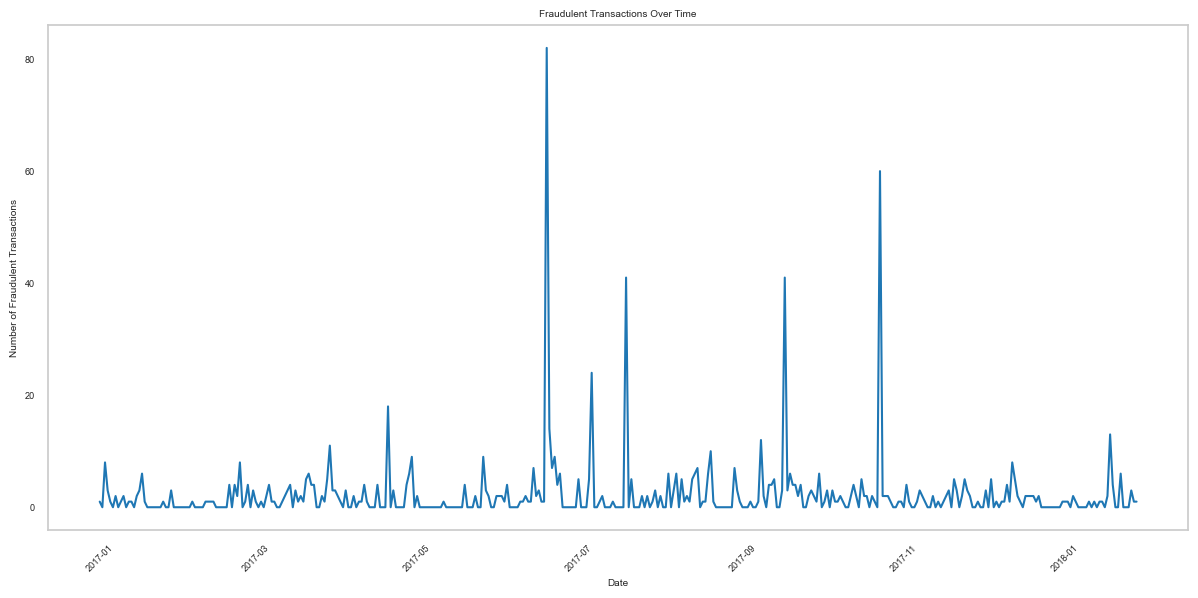

In [81]:
fraud_df = df[df["fraud"] == True]
fraud_counts = fraud_df.resample("D").size()
plt.figure(figsize=(12, 6))
plt.plot(fraud_counts.index, fraud_counts.values)
plt.title("Fraudulent Transactions Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Fraudulent Transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

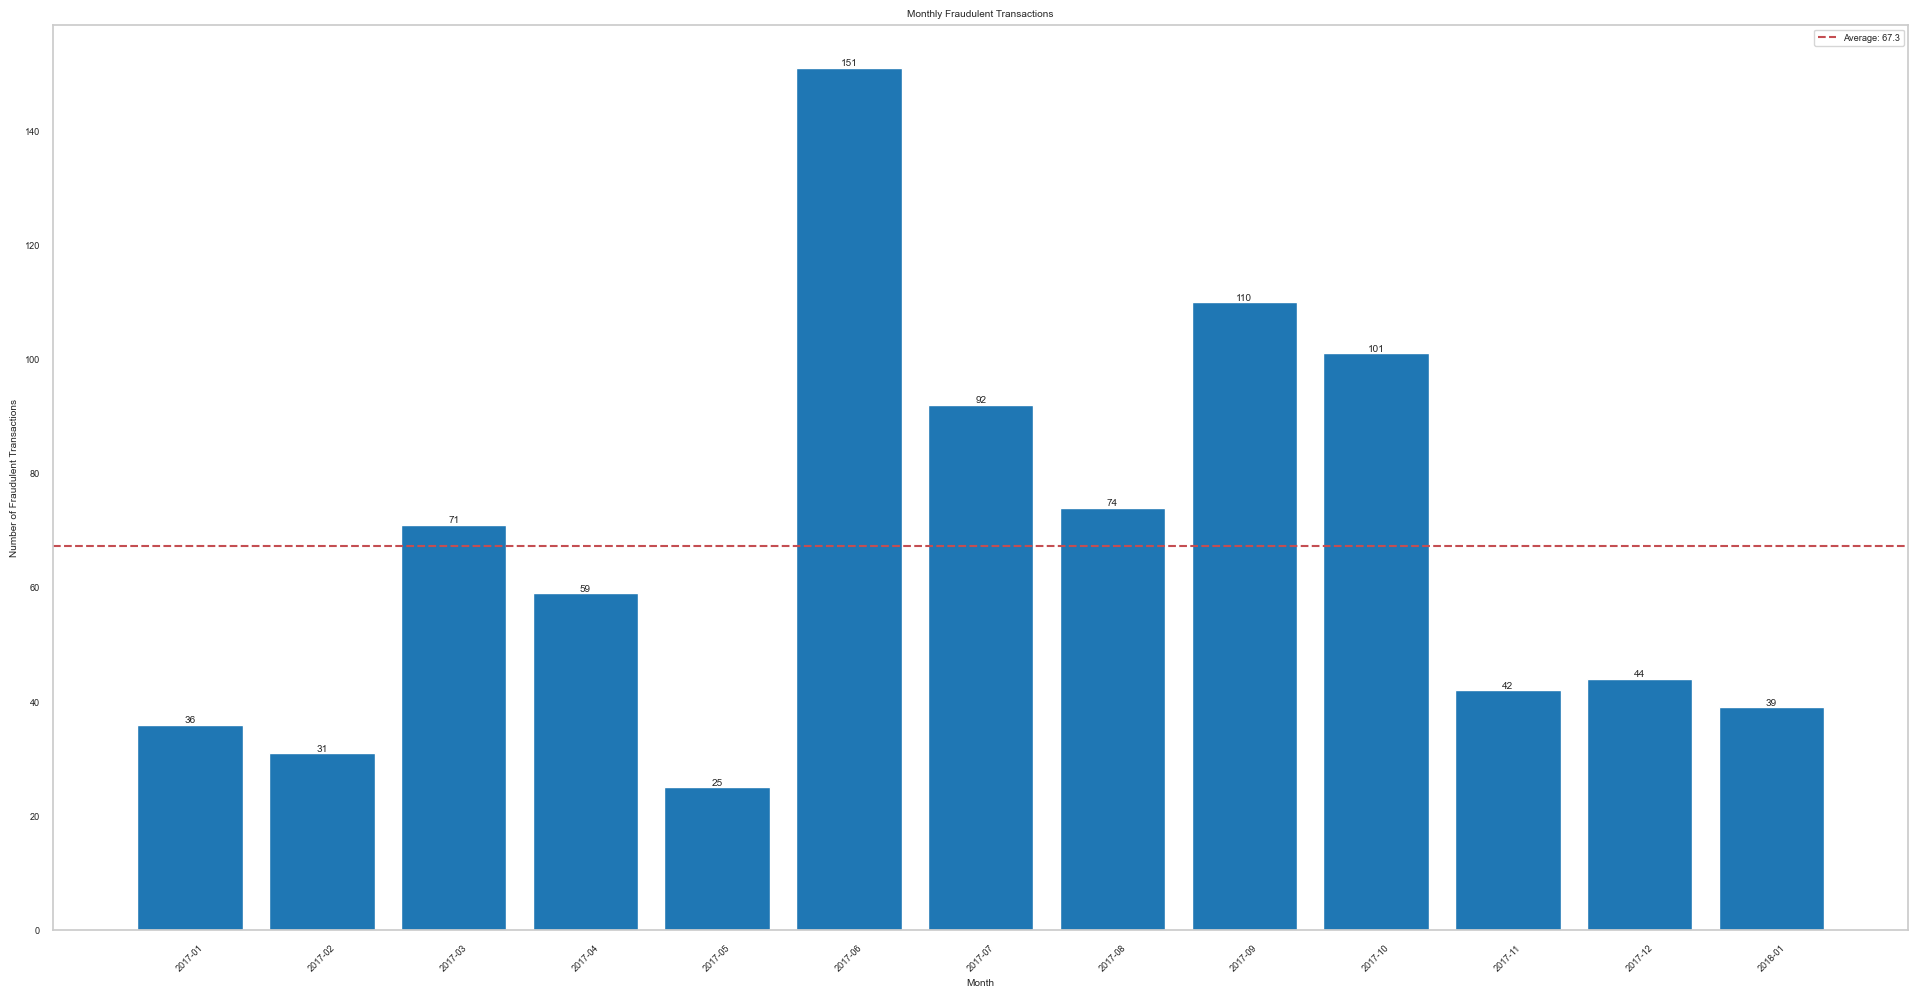

In [82]:
fraud_stats = analyze_monthly_fraud(df)

In [83]:
print(
    f"Dataset start: {fraud_stats['start_period']}, end: {fraud_stats['end_period']}. Total months: {fraud_stats['total_months']}"
)
print(
    f"Total fraudulent cases: {fraud_stats['total_fraud_cases']}, average of {fraud_stats['total_fraud_cases']/fraud_stats['total_months']:.0f} per month"
)

Dataset start: 2017-01, end: 2018-01. Total months: 13
Total fraudulent cases: 875, average of 67 per month


The fraud rates are very inconsistent, with some periods having spikes of fraud rates. For that reason, we will have to select a robust train-test split approach that performs cross-validation accross multiple periods and accommodates the rolling features we have created.

## Feature Importance
Let's see how each feature is deterministic with regards to the target variable.

### Mutual Information (SMOTE method)
Mutual Information does not inherently account for class imbalances. We will be using the Mutual-Information-SMOTE method as described in [this study](https://link.springer.com/chapter/10.1007/978-981-13-1648-7_2) to address class imbalance while leveraging the strengths of mutual information for feature selection. This hybrid method helps ensure that the difficult-to-classify samples are adequately represented, which can improve the overall performance of the model on imbalanced datasets.

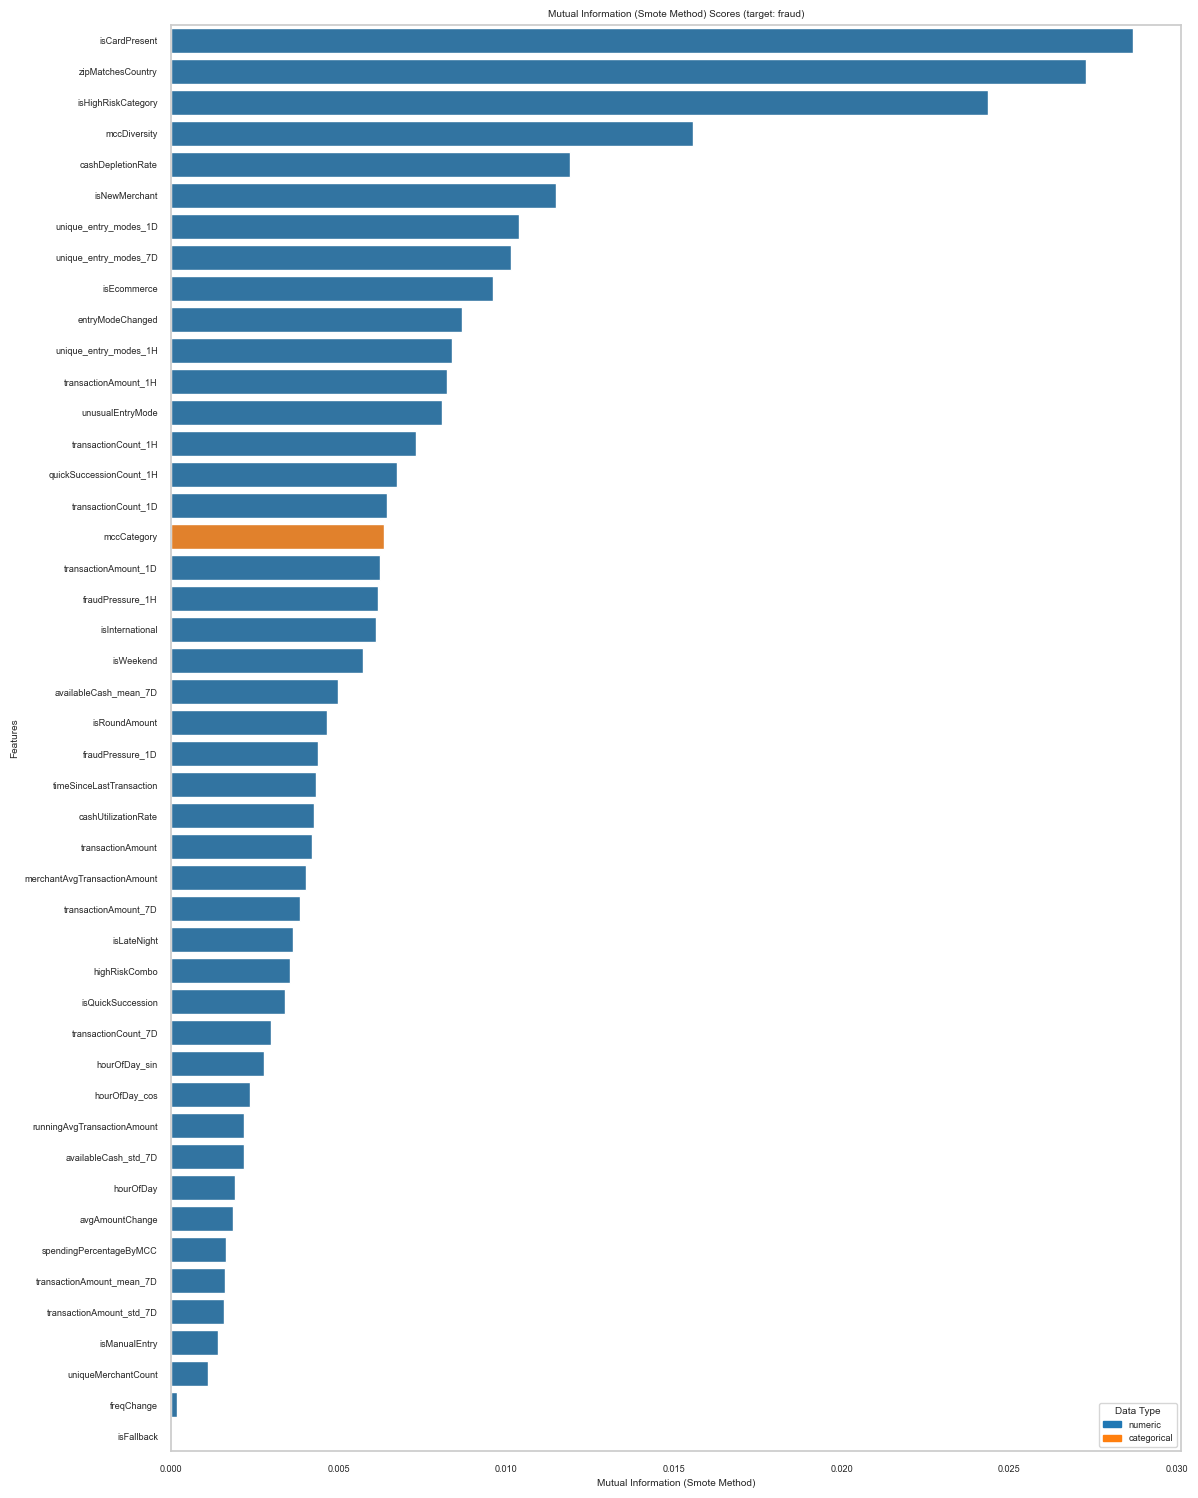

In [84]:
mi_importance_smote = calculate_mutual_information_smote(df, target_column)
plot_feature_importances(
    mi_importance_smote, target_column, "mutual information (SMOTE method)"
)

<div class="next-steps">
    <h3>Observations</h3>
    <p>Feature Importance - Mutual Information SMOTE</p>
    <ol>
        <ul>Overall, Feature Engineering seems to have worked - most of the features are regarded as valuable</ul>
        <ul>The presence of a physical card (<code>isCardPresent</code> and <code>isChipBasd</code>) provides the most information</ul>
        <ul>ZIP-based data through <code>zipMatchesCountry</code> and <code>hasValidZip</code> are second in provided information to the target label</ul>
        <ul>Created rolling aggregations are also very useful for predicting the target</ul>
        <ul>Both Categorical features <code>mccCategory</code> and <code>posEntryMode</code> prove to be useful as well</ul>
        <ul>Change in transaction frequency and the indicator of whether the payment used chip fallback (POS 80) didn't seem to be useful</ul>
    </ol>
</div>

## Ensemble Feature Importance
For this step, we will use `XGBoost` and `LightGBM` built-in feature importance functionality to get the average feature importance for each feature.

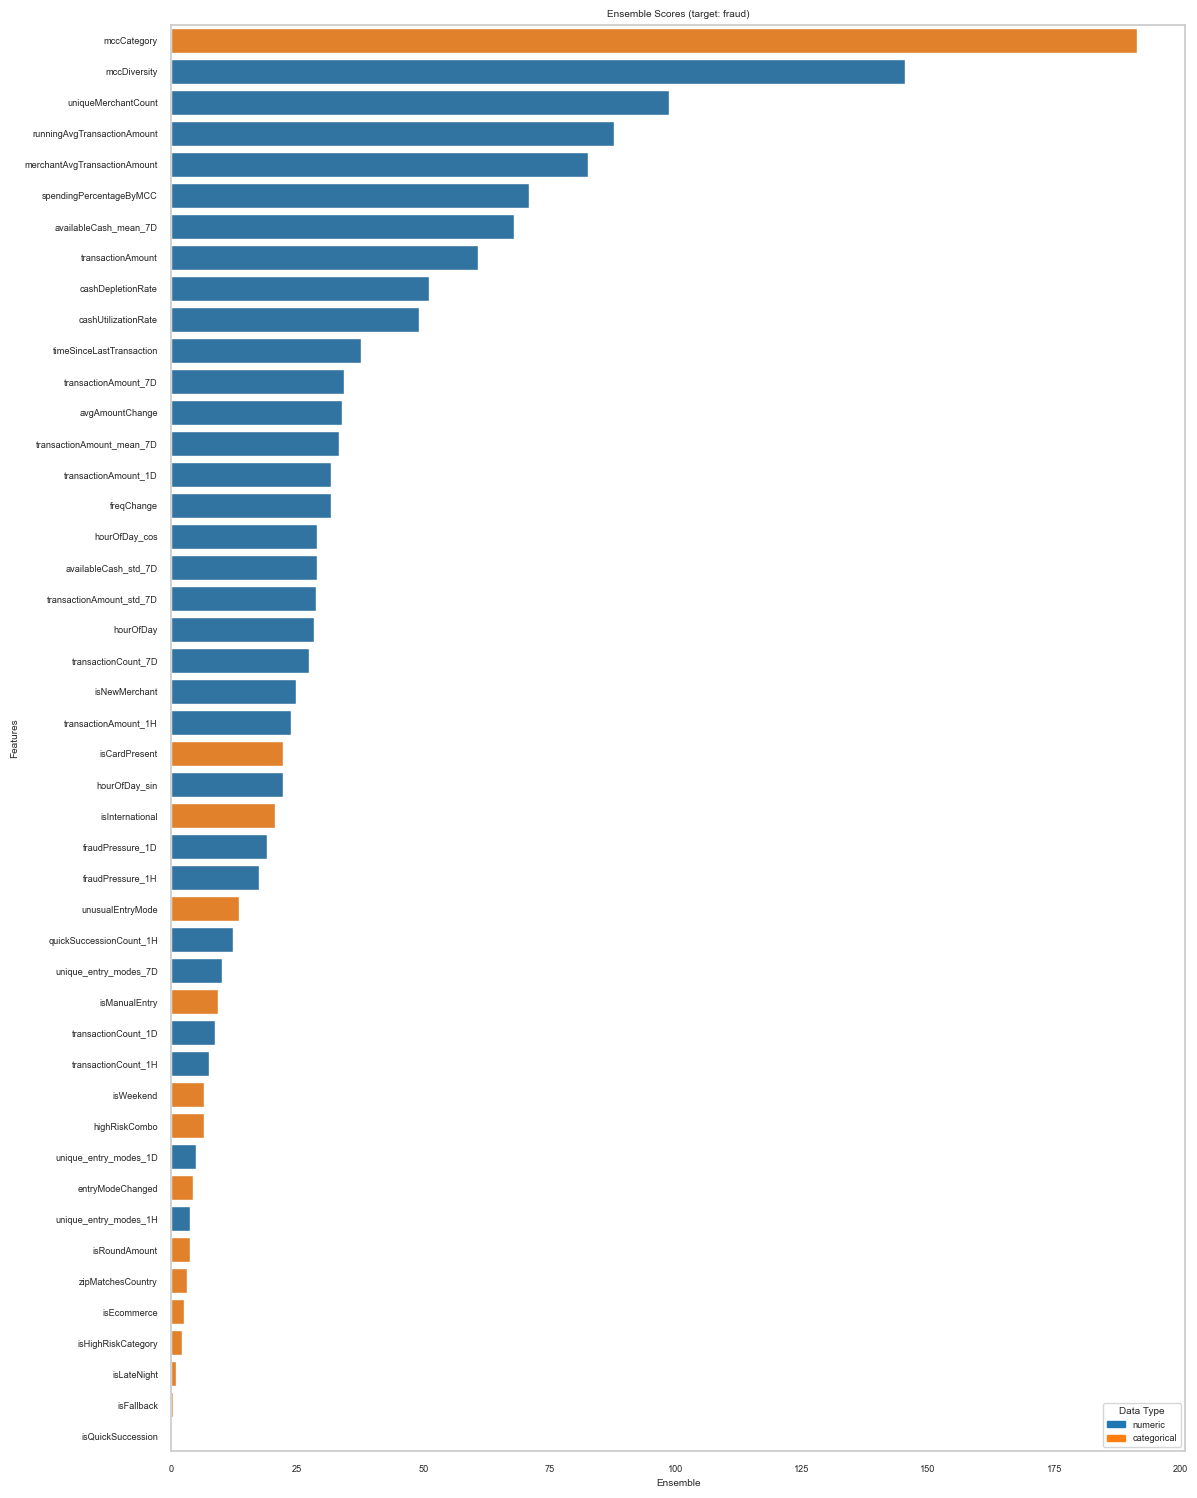

In [85]:
ensemble_importances = calculate_ensemble_feature_importance(
    df.drop(target_column, axis=1), df[target_column], n_iterations=5
)
plot_feature_importances(ensemble_importances, target_column, "ensemble")

<div class="next-steps">
    <h3>Observations</h3>
    <p>Feature Importance - Gradient Boosting Ensemble</p>
    <ol>
        <ul>The importance chart is much more skewed, with a few features having extreme importance compared the the rest</ul>
        <ul><code>uniqueMerchantCount</code> and <code>mccDiversity</code>, features that calculate the variety of merchants the client transacted with, have big importance to the Gradient Boosting models</ul>
        <ul><code>hourOfDay</code> has strong influence in predictions as well</ul>
        <ul>Some boolean flags that have importance in MI-SMOTE, have no importance in this ensemble method</ul>
        <ul>Just like MI-SMOTE, <code>isFallback</code> has very little feature importance</ul>
    </ol>
</div>

## Feature Correlations
Let's see how the numeric variables and the categorical variables interact between each other and provide meaningful information to the target variable. We will be using **Phik's Coefficient**.

Phik correlation is a statistical measure that can detect both linear and non-linear relationships between variables, making it suitable for both numeric and categorical data. It assumes that the underlying relationship between variables can be approximated by a grid of contingency tables. The Phik correlation coefficient ranges from 0 to 1, where 0 indicates no correlation and 1 indicates perfect correlation, regardless of whether the relationship is linear or non-linear.

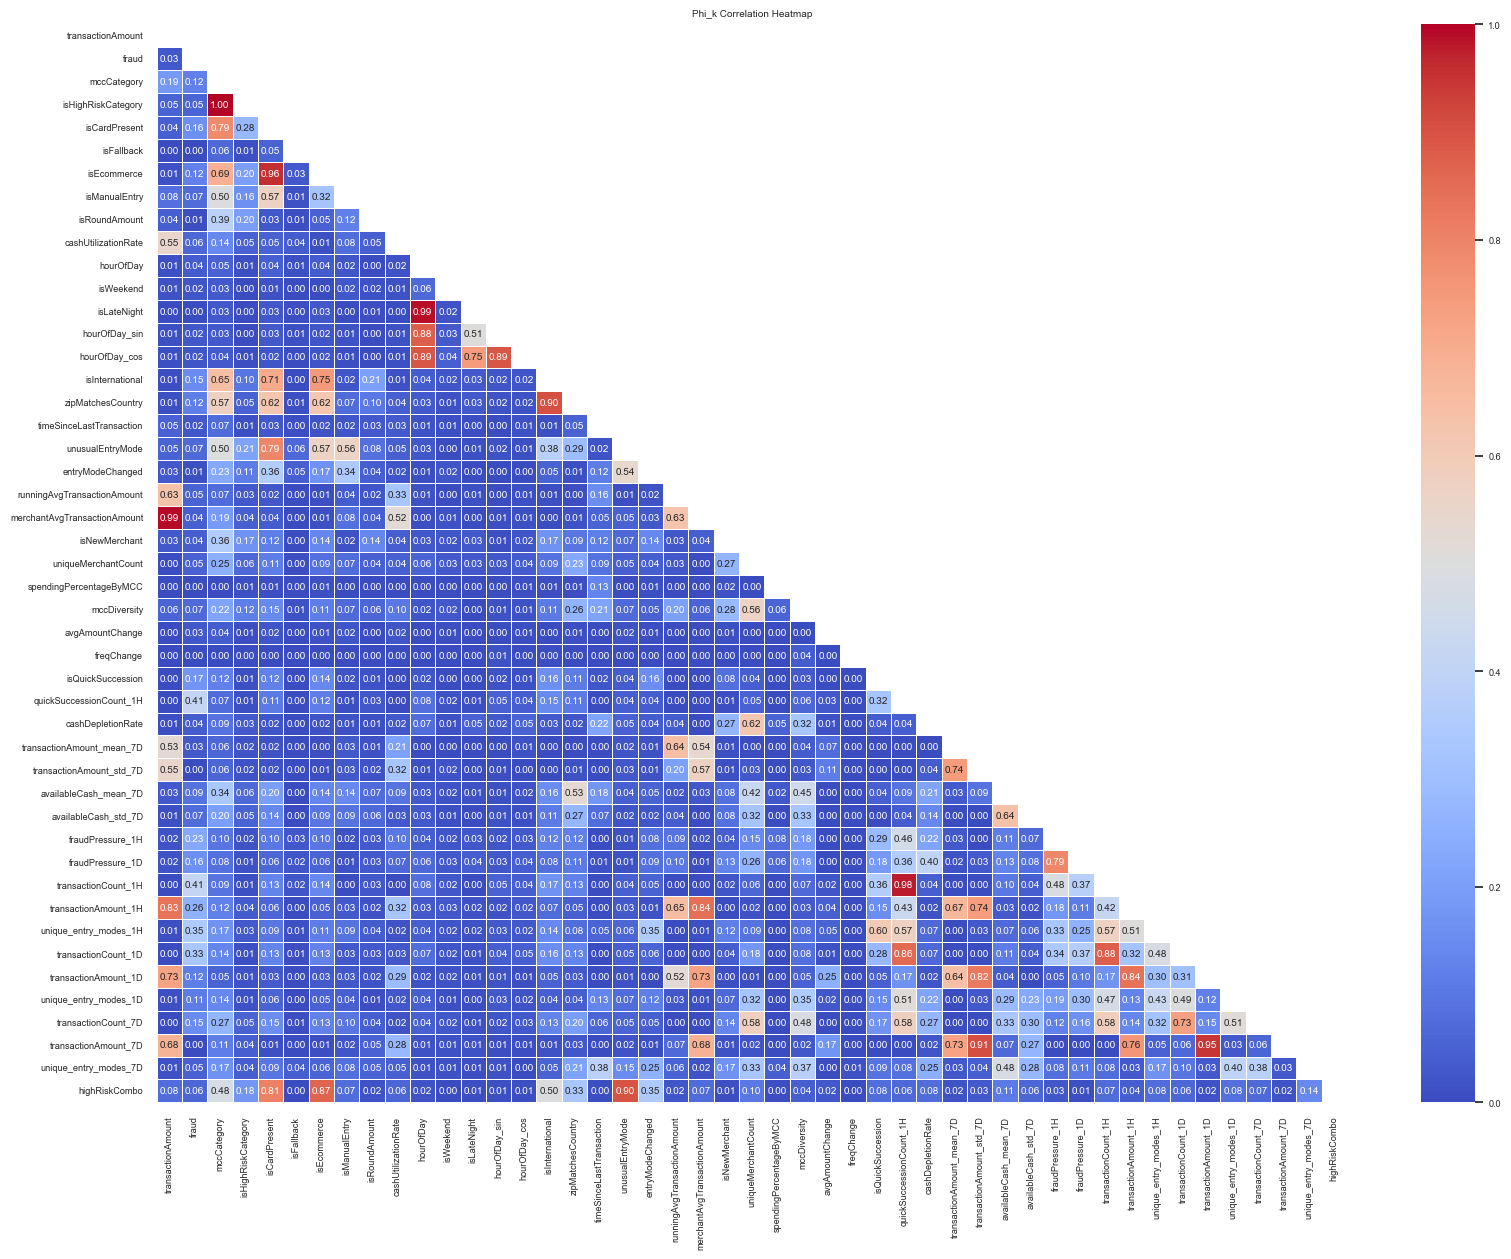

In [86]:
numerical_columns = df.select_dtypes(include=[np.number]).columns
corr_target, top_interactions = phik_matrix(
    df, numerical_columns, target_column, mi_importance_smote
)

In [87]:
print(f"Top 10 feature-target correlations:")
display(corr_target)

Top 10 feature-target correlations:


Feature  Phik Coefficient
0  quickSuccessionCount_1H              0.41
1      transactionCount_1H              0.41
2    unique_entry_modes_1H              0.35
3      transactionCount_1D              0.33
4     transactionAmount_1H              0.26
5         fraudPressure_1H              0.23
6        isQuickSuccession              0.17
7         fraudPressure_1D              0.16
8            isCardPresent              0.16
9          isInternational              0.15

In [88]:
print(f"Top overall feature interactions:")
display(top_interactions)

Top overall feature interactions:


Feature1                  Feature2  \
143             isHighRiskCategory               mccCategory   
987   merchantAvgTransactionAmount         transactionAmount   
482                      hourOfDay               isLateNight   
1400       quickSuccessionCount_1H       transactionCount_1H   
194                  isCardPresent               isEcommerce   
1971          transactionAmount_1D      transactionAmount_7D   
2100          transactionAmount_7D  transactionAmount_std_7D   
721                isInternational         zipMatchesCountry   
2180                 highRiskCombo          unusualEntryMode   
671                  hourOfDay_cos             hourOfDay_sin   
484                      hourOfDay             hourOfDay_cos   
1917           transactionCount_1D       transactionCount_1H   
483                      hourOfDay             hourOfDay_sin   
2168                 highRiskCombo               isEcommerce   
1403       quickSuccessionCount_1H       transactionCount_1D   
1025  merchantAvgTransactionAmount      transactionAmount_1H   
1965          transactionAmount_1D      transactionAmount_1H   
38               transactionAmount      transactionAmount_1H   
1959          transactionAmount_1D  transactionAmount_std_7D   
2166                 highRiskCombo             isCardPresent   

      Phik Coefficient  Feature1 Score  Feature2 Score  
143                  1            0.02            0.01  
987               0.99            0.00            0.00  
482               0.99            0.00            0.00  
1400              0.98            0.01            0.01  
194               0.96            0.03            0.01  
1971              0.95            0.01            0.00  
2100              0.91            0.00            0.00  
721               0.90            0.01            0.03  
2180              0.90            0.00            0.01  
671               0.89            0.00            0.00  
484               0.89            0.00            0.00  
1917              0.88            0.01            0.01  
483               0.88            0.00            0.00  
2168              0.87            0.00            0.01  
1403              0.86            0.01            0.01  
1025              0.84            0.00            0.01  
1965              0.84            0.01            0.01  
38                0.83            0.00            0.01  
1959              0.82            0.01            0.00  
2166              0.81            0.00            0.03

<div class="next-steps">
    <h3>Observations</h3>
    <p>Feature Importance</p>
    <ol>
        <ul>Out of the 10 features with highest phik coefficient to the target label, rolling aggregations are the most frequent</ul>
        <ul>Quick Succession features, which indicate presence of transactions within a 5 minute interval, seem to have high importance in both numerical and boolean forms</ul>
        <ul>There are some perfect and high correlations, but they are not one-to-one mappings and will be kept</ul>
    </ol>
</div>

## Numerical predictors
Let's explore the feature-target interactions through distributions. Statistical significance is expressed through two metrics:
* **p-value** - likelihood of null hypothesis (the feature makes two classes of clients different)
* **Effect Magnitude** - the practical significance of the difference

In [89]:
df_significance_num = pd.DataFrame()
numerical_columns = df.select_dtypes(include=[np.number]).columns

Feature: transactionAmount. p-value: 0.4718. Effect size: 0.0141


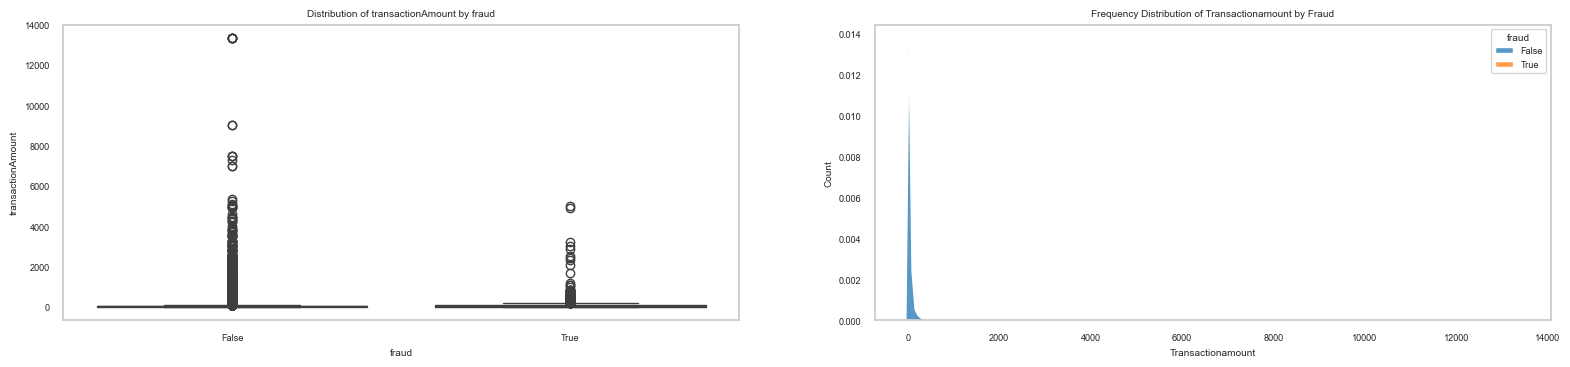

Feature: cashUtilizationRate. p-value: 0.0000. Effect size: -0.1040


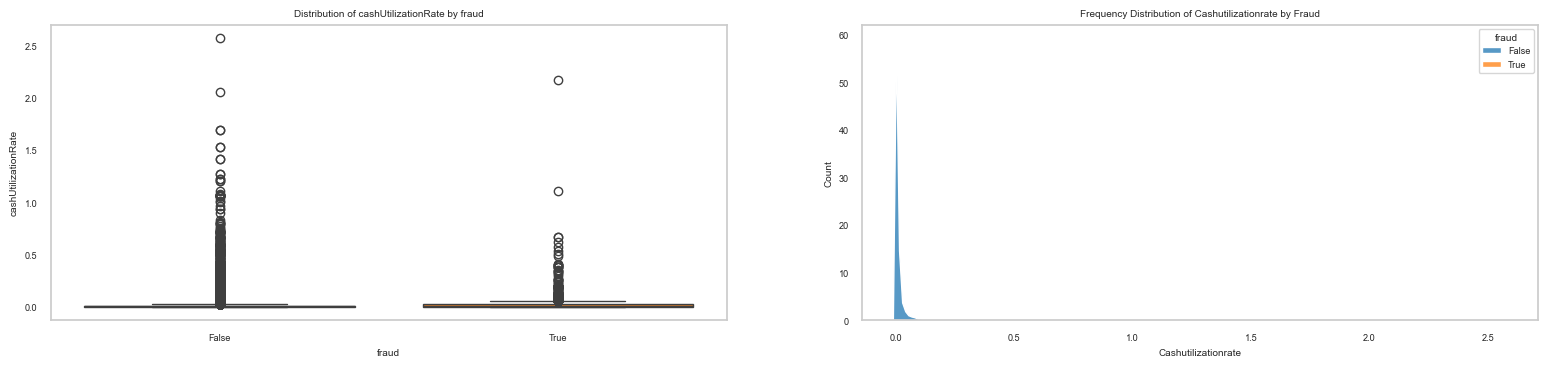

Feature: hourOfDay. p-value: 0.0000. Effect size: 0.1109


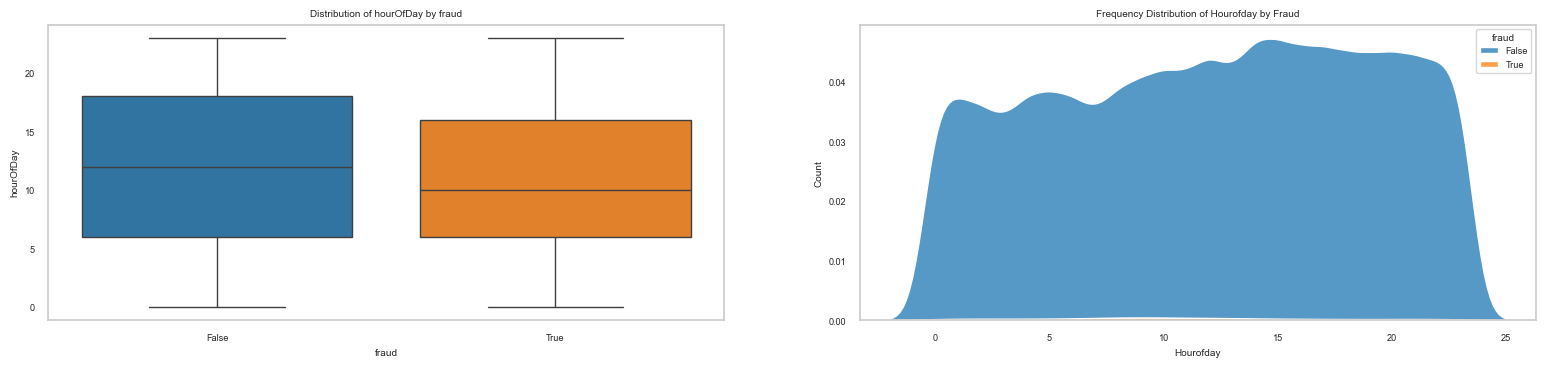

Feature: hourOfDay_sin. p-value: 0.0000. Effect size: -0.1492


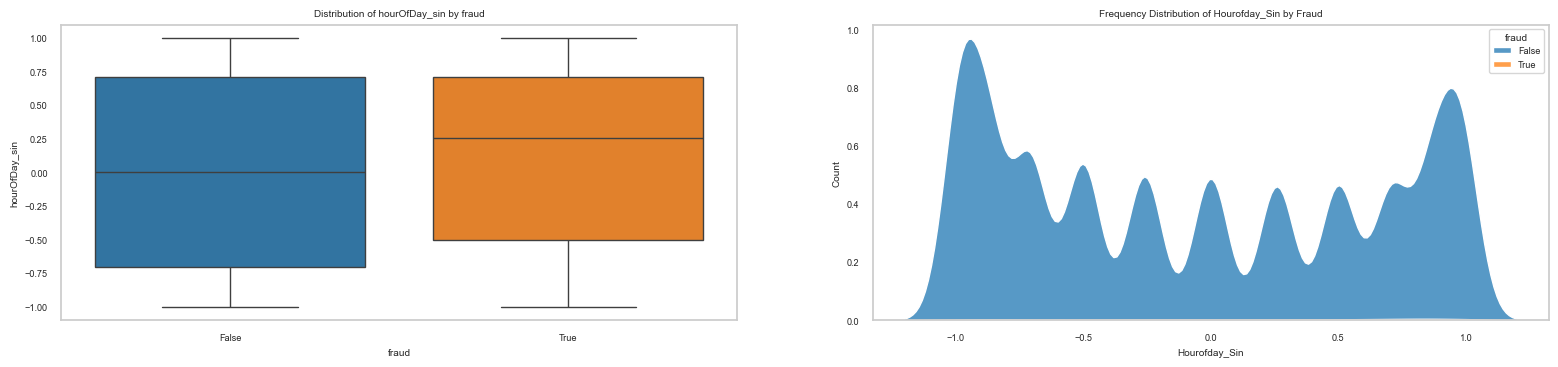

Feature: hourOfDay_cos. p-value: 0.0029. Effect size: 0.0584


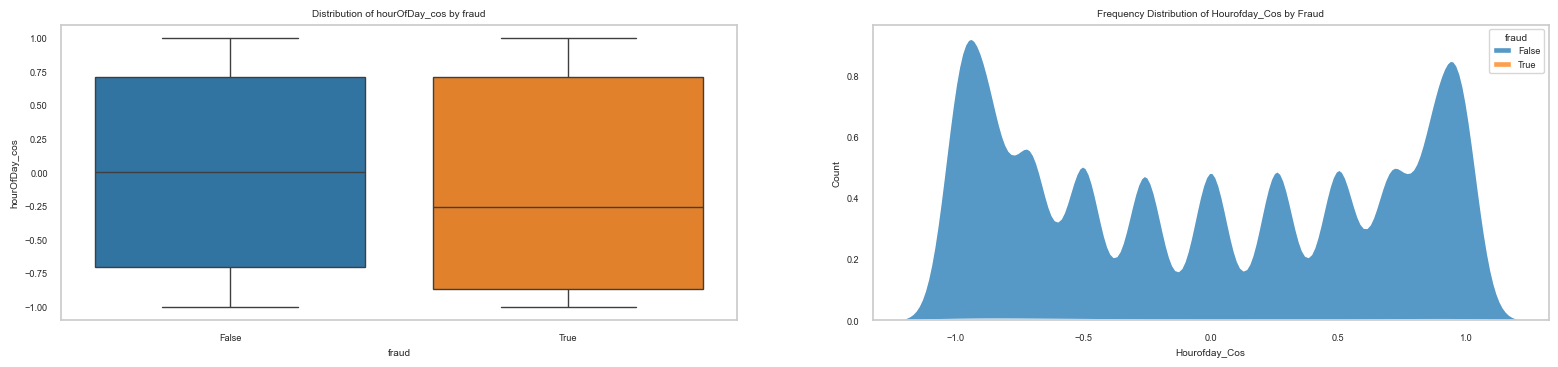

Feature: timeSinceLastTransaction. p-value: 0.0000. Effect size: 0.3608


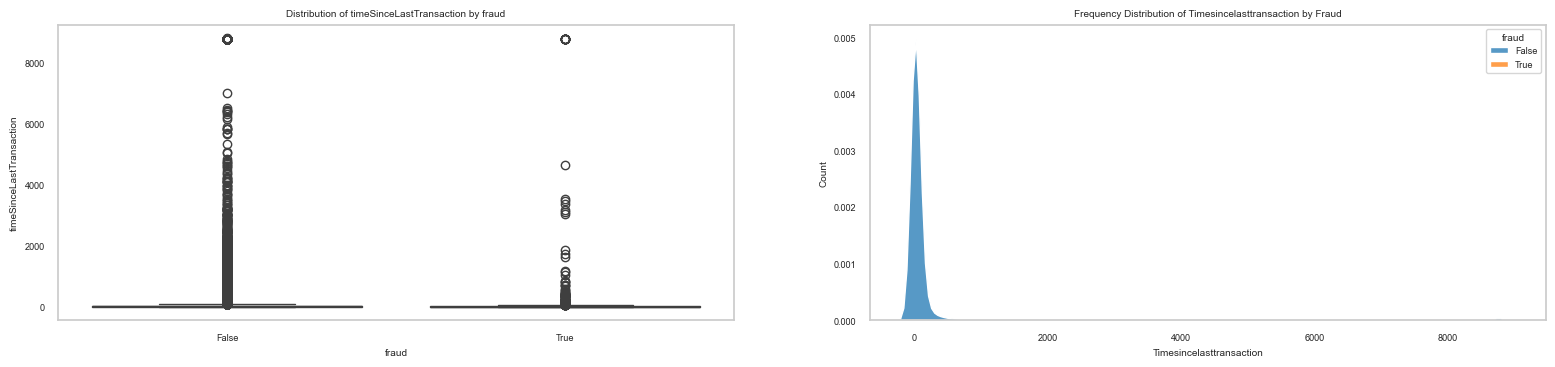

Feature: runningAvgTransactionAmount. p-value: 0.0031. Effect size: 0.0580


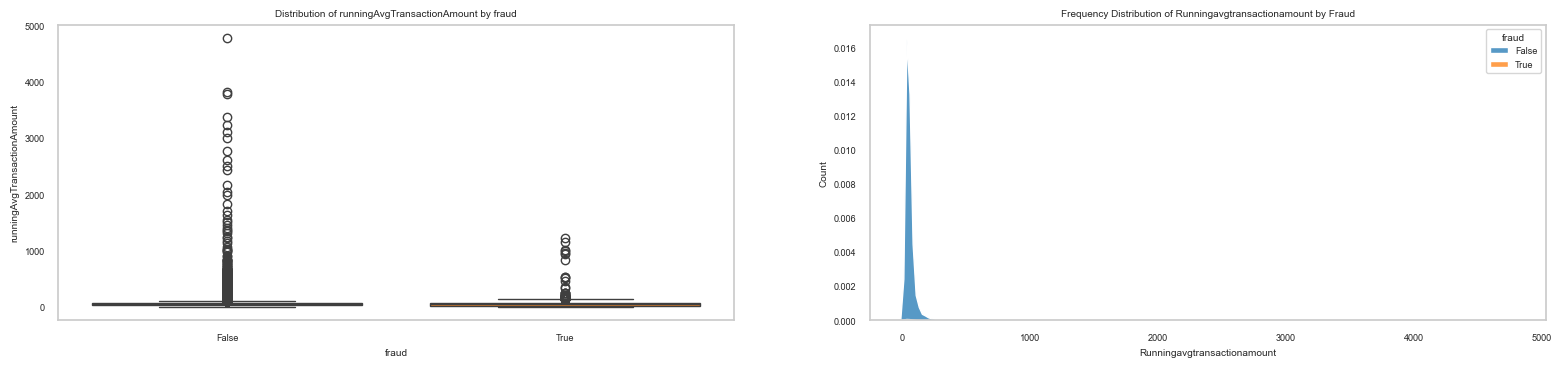

Feature: merchantAvgTransactionAmount. p-value: 0.0000. Effect size: 0.0903


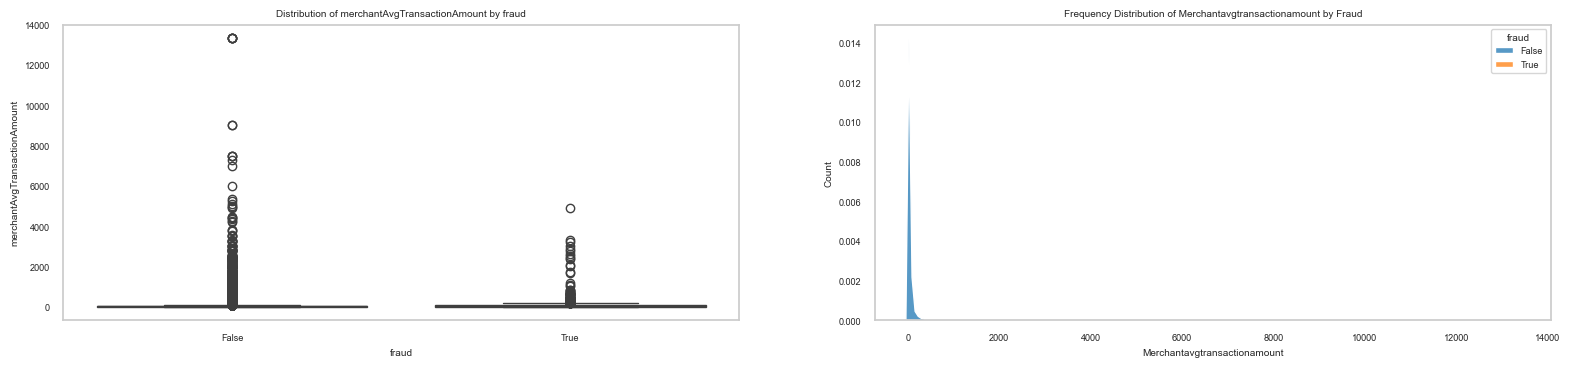

Feature: isNewMerchant. p-value: 0.0000. Effect size: -0.1492


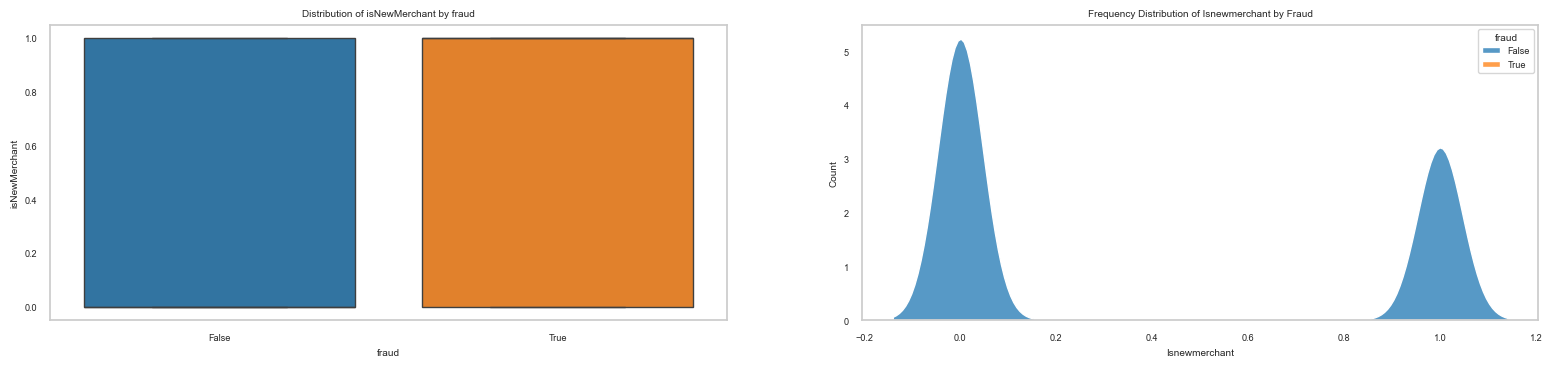

Feature: uniqueMerchantCount. p-value: 0.0000. Effect size: 0.2920


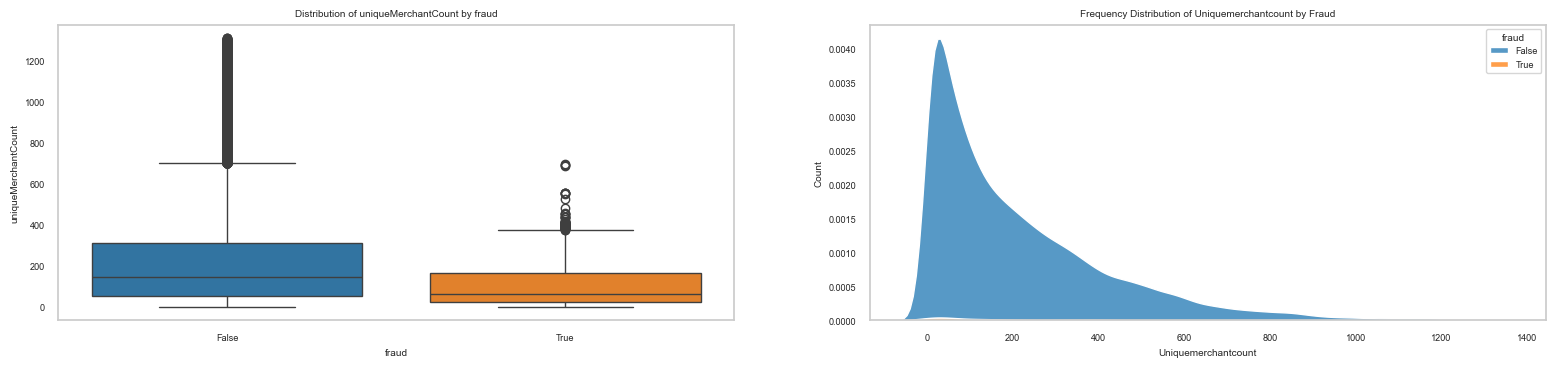

Feature: spendingPercentageByMCC. p-value: 0.0002. Effect size: 0.0730


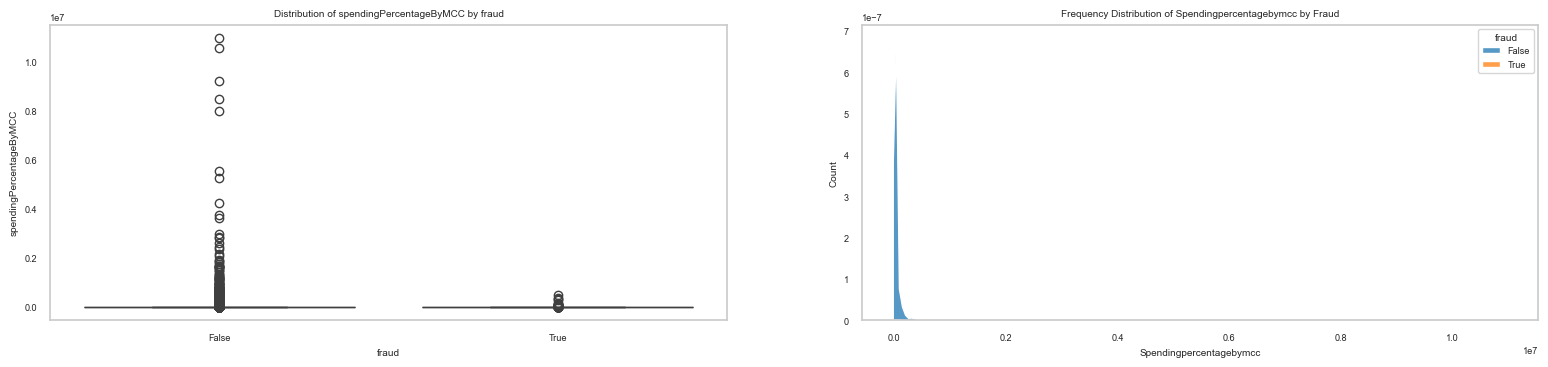

Feature: mccDiversity. p-value: 0.0000. Effect size: -0.2980


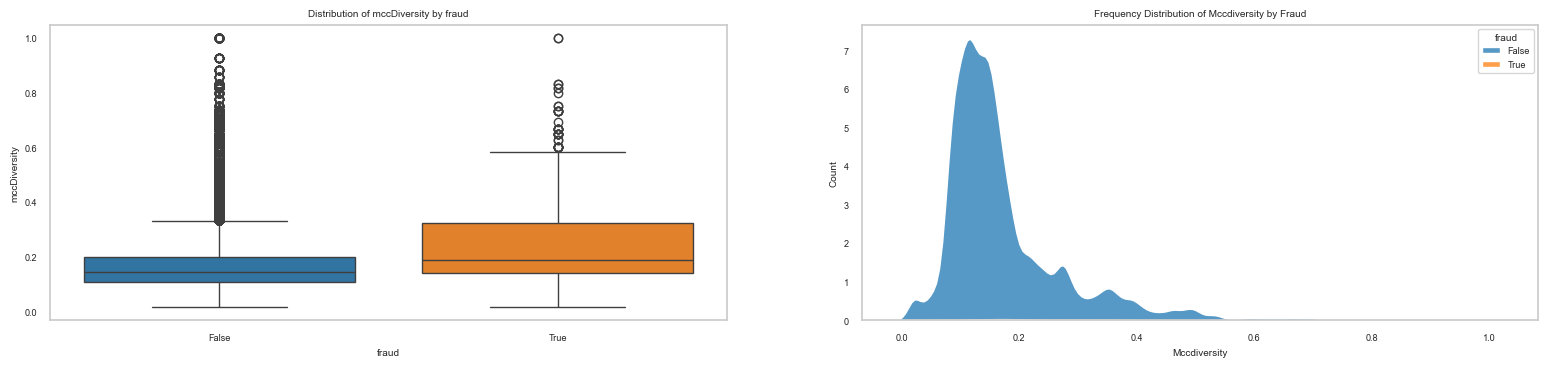

Feature: avgAmountChange. p-value: 0.8391. Effect size: 0.0040


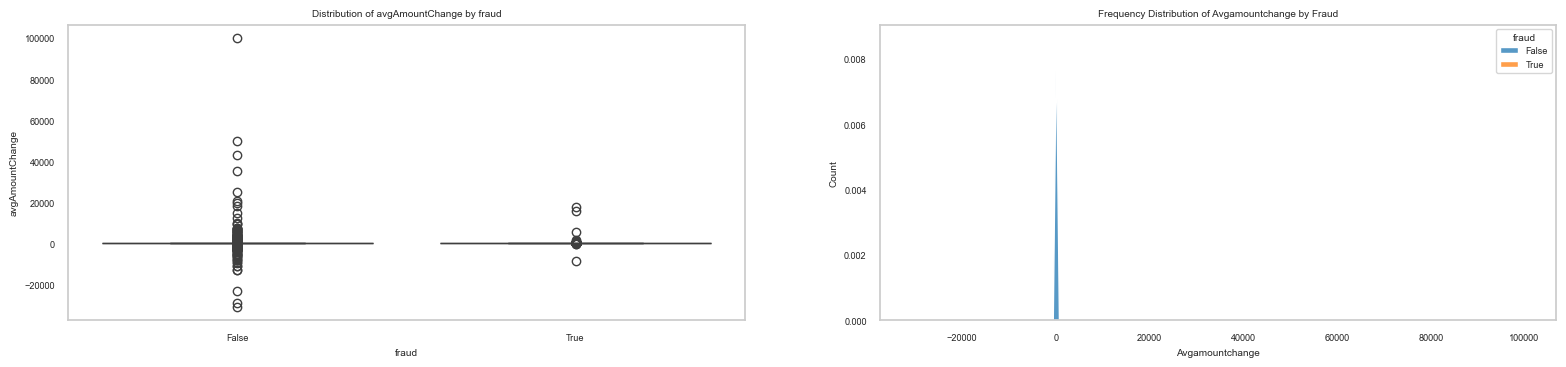

Feature: freqChange. p-value: 0.0185. Effect size: 0.0462


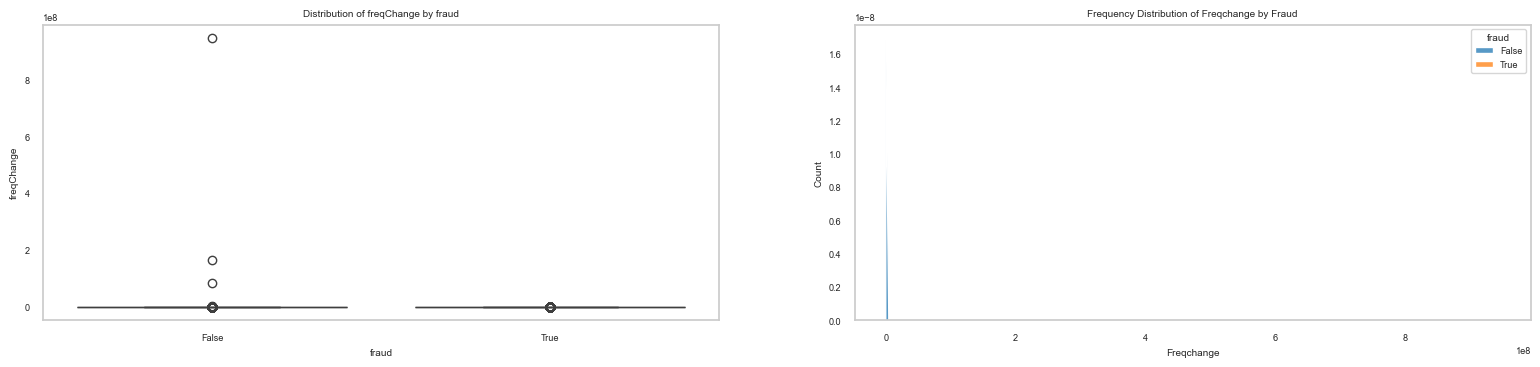

Feature: quickSuccessionCount_1H. p-value: 0.0000. Effect size: -0.3241


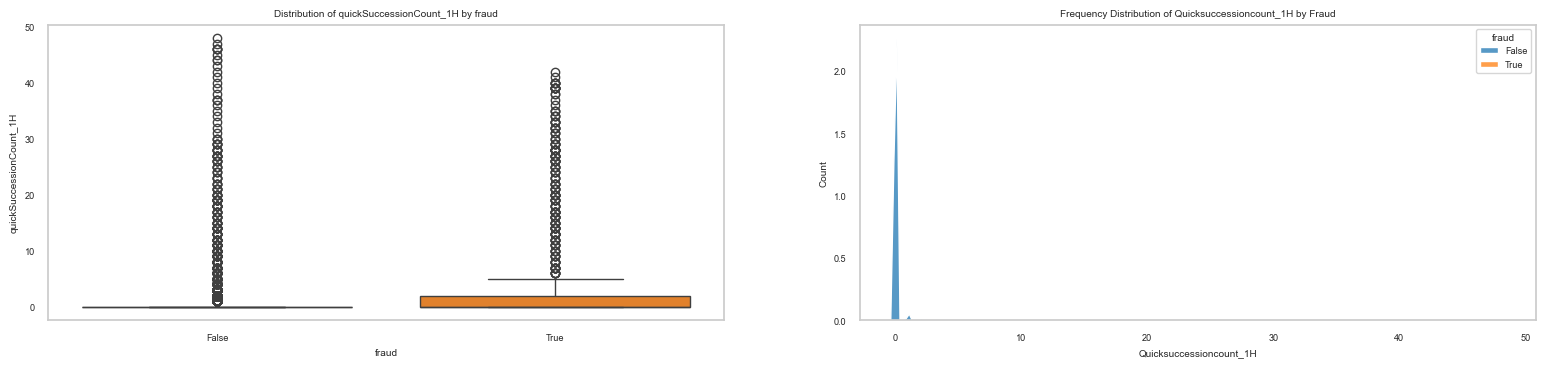

Feature: cashDepletionRate. p-value: 0.0000. Effect size: 0.0942


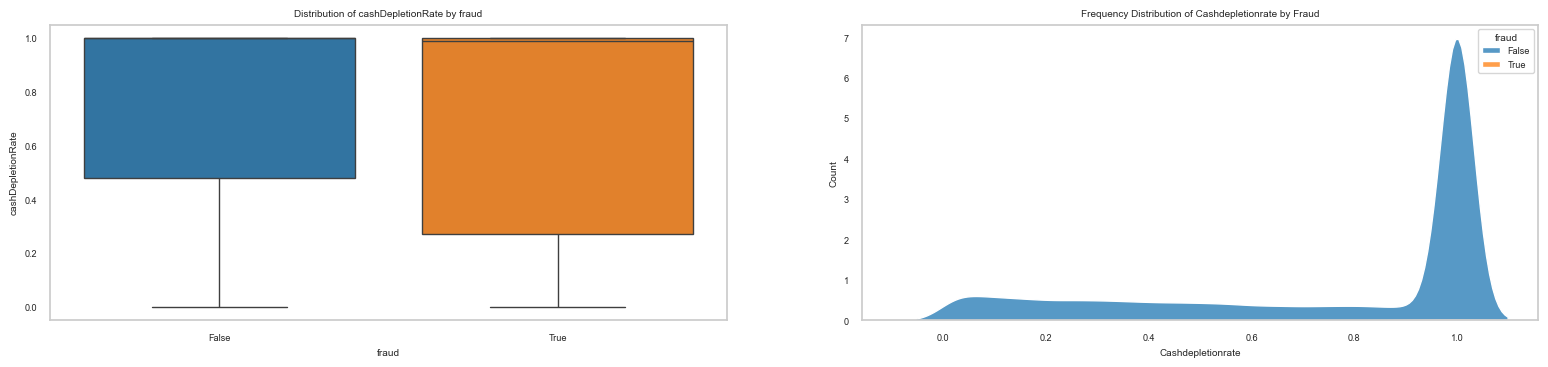

Feature: transactionAmount_mean_7D. p-value: 0.0011. Effect size: -0.0638


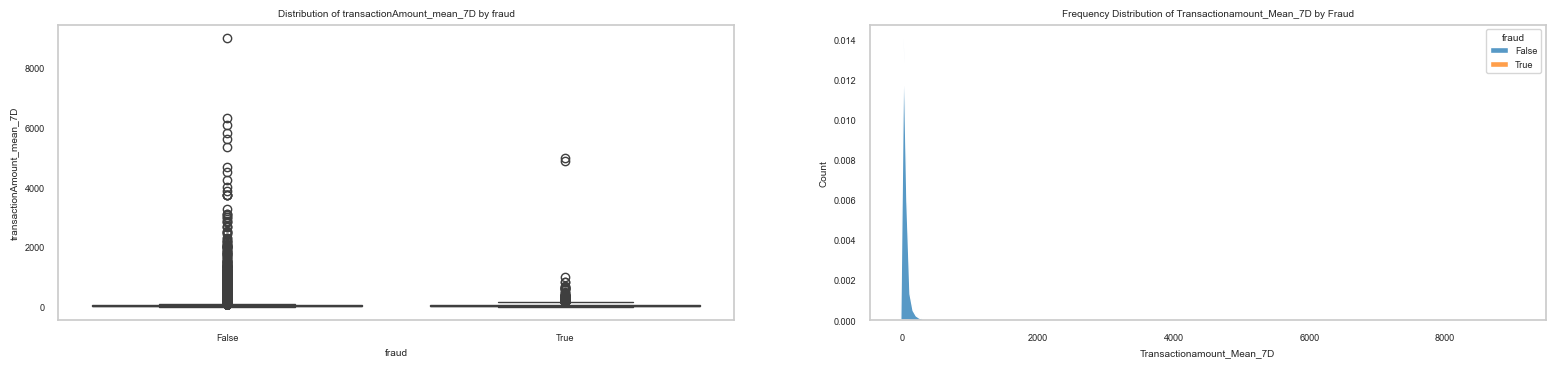

Feature: transactionAmount_std_7D. p-value: 0.0022. Effect size: -0.0599


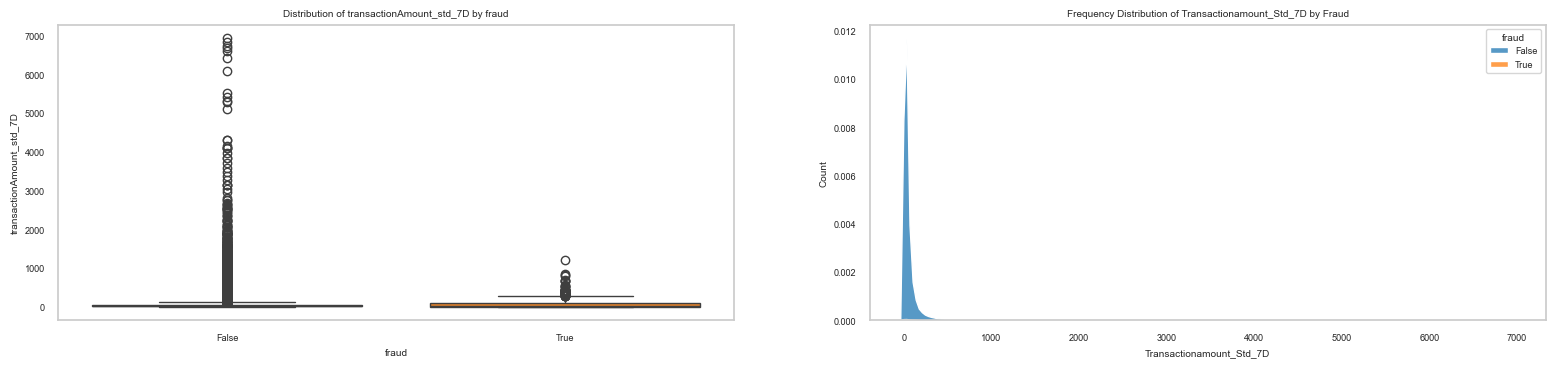

Feature: availableCash_mean_7D. p-value: 0.0000. Effect size: 0.3201


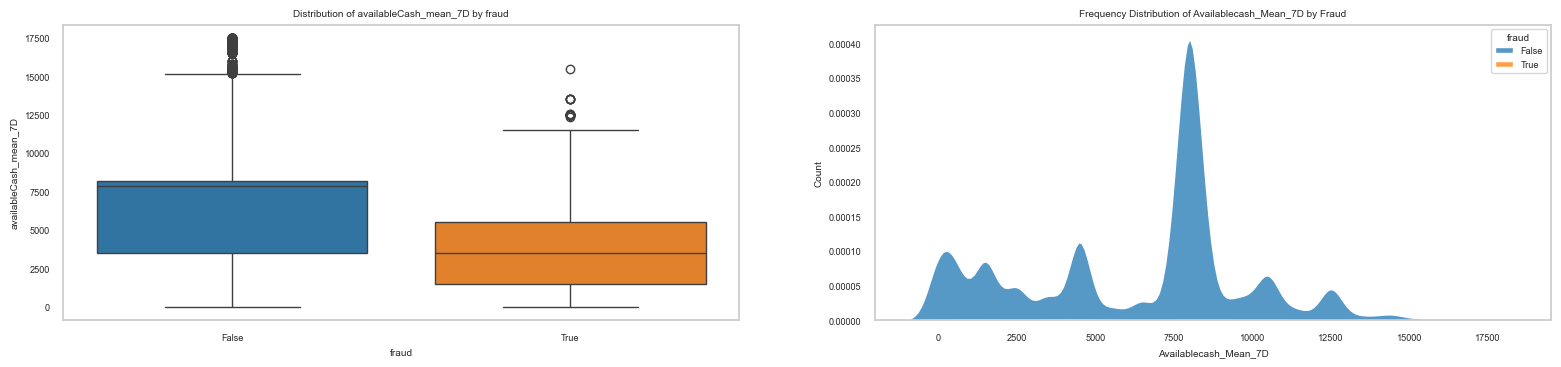

Feature: availableCash_std_7D. p-value: 0.0000. Effect size: 0.3413


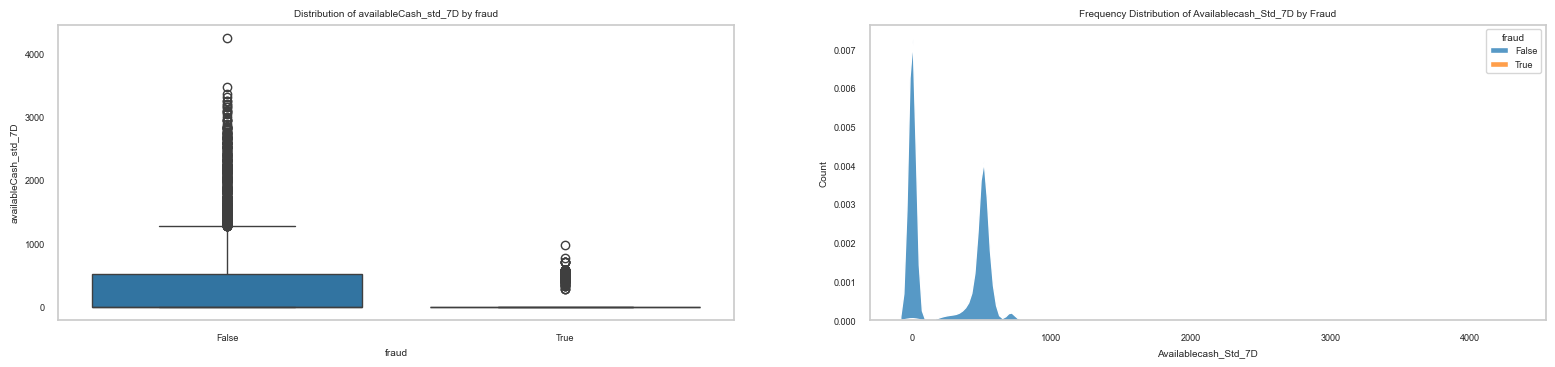

Feature: fraudPressure_1H. p-value: 0.0000. Effect size: -0.4452


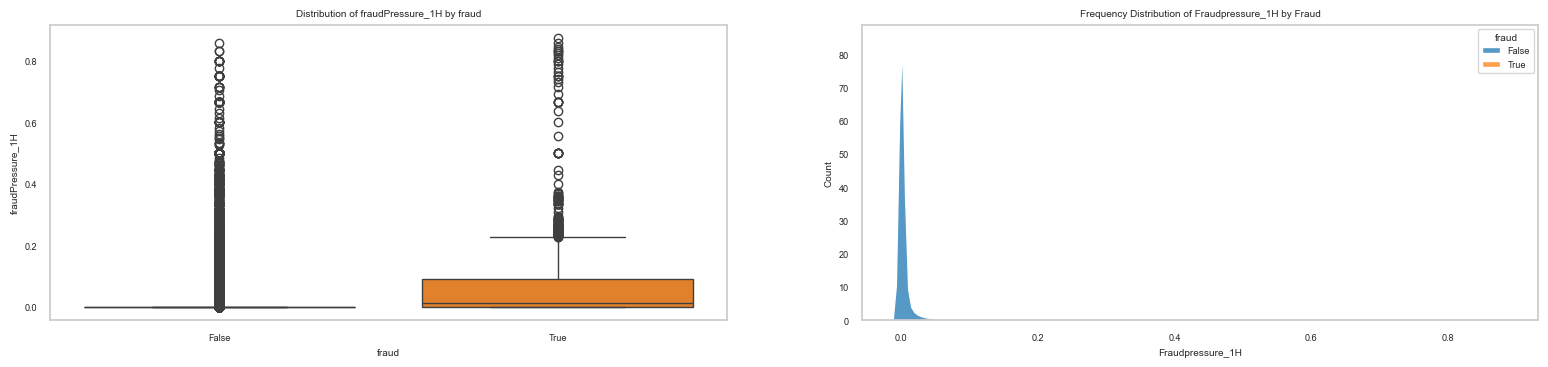

Feature: fraudPressure_1D. p-value: 0.0000. Effect size: -0.4061


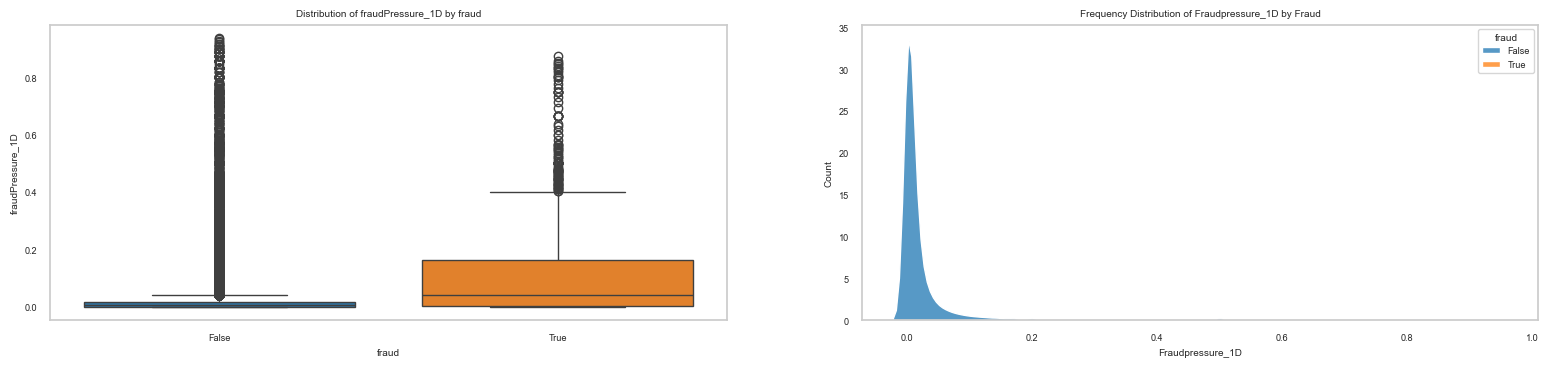

Feature: transactionCount_1H. p-value: 0.0000. Effect size: -0.4333


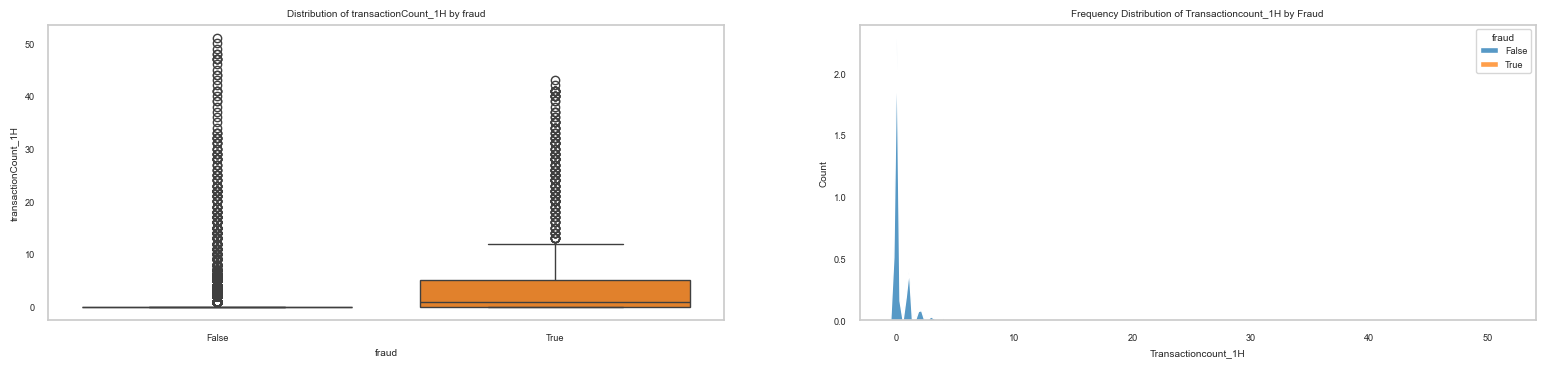

Feature: transactionAmount_1H. p-value: 0.0000. Effect size: -0.4196


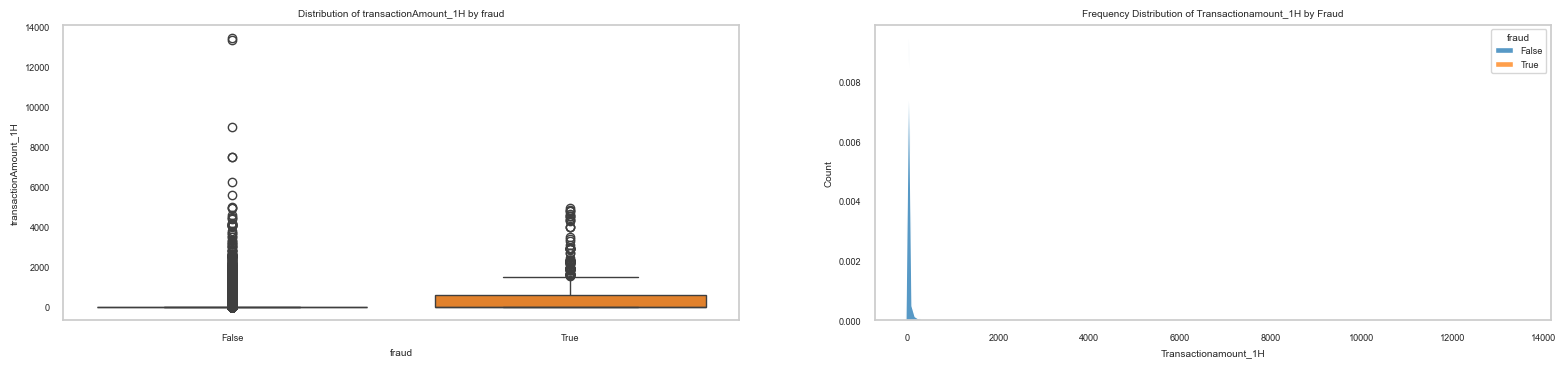

Feature: unique_entry_modes_1H. p-value: 0.0000. Effect size: -0.4017


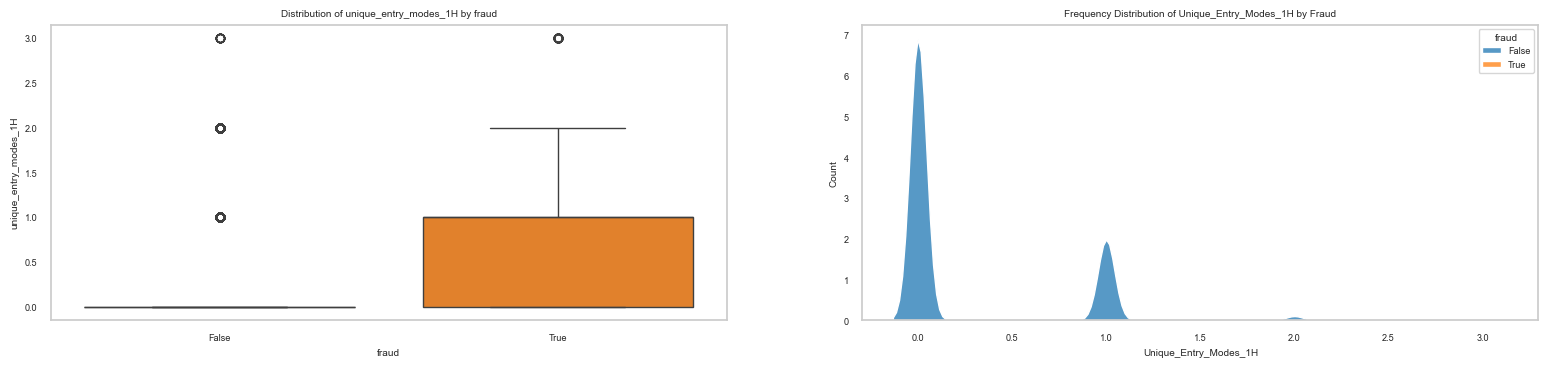

Feature: transactionCount_1D. p-value: 0.0000. Effect size: -0.3242


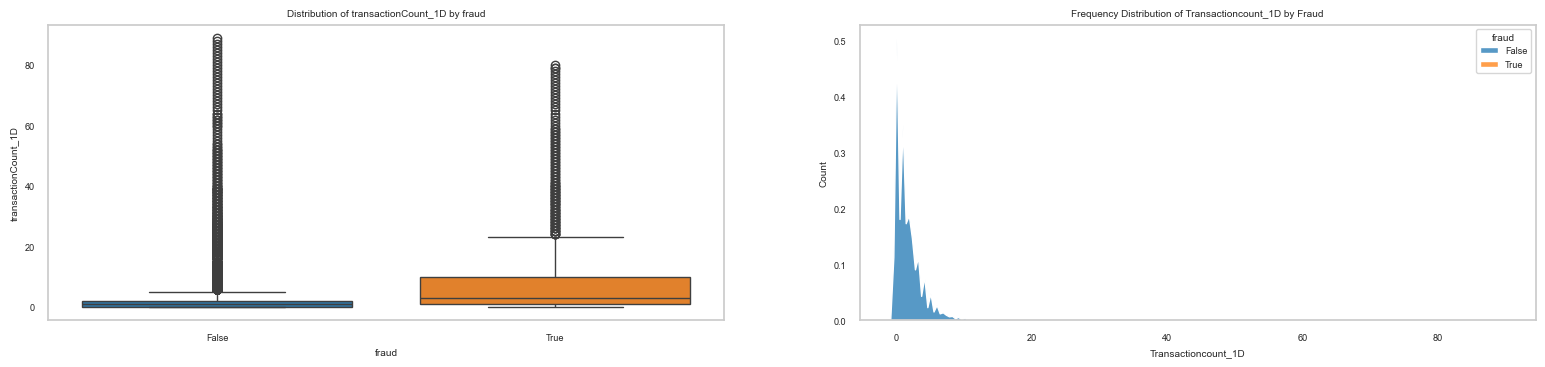

Feature: transactionAmount_1D. p-value: 0.0000. Effect size: -0.3062


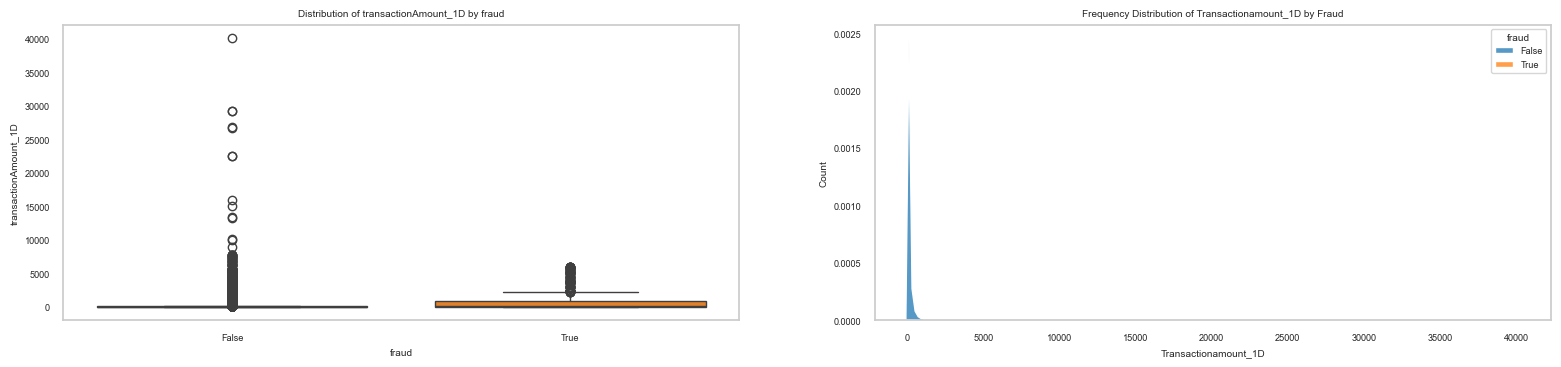

Feature: unique_entry_modes_1D. p-value: 0.0000. Effect size: -0.2211


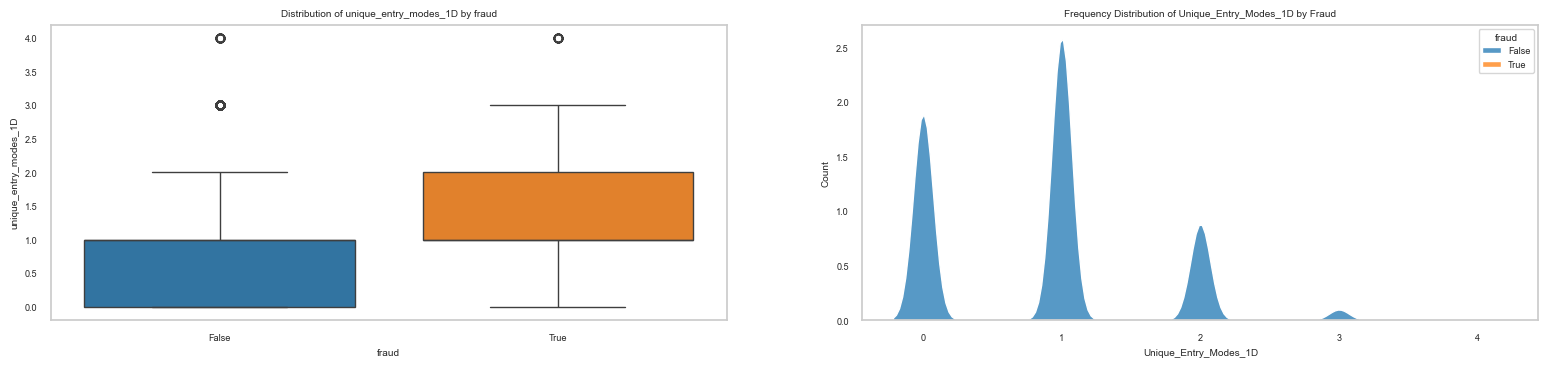

Feature: transactionCount_7D. p-value: 0.1697. Effect size: -0.0269


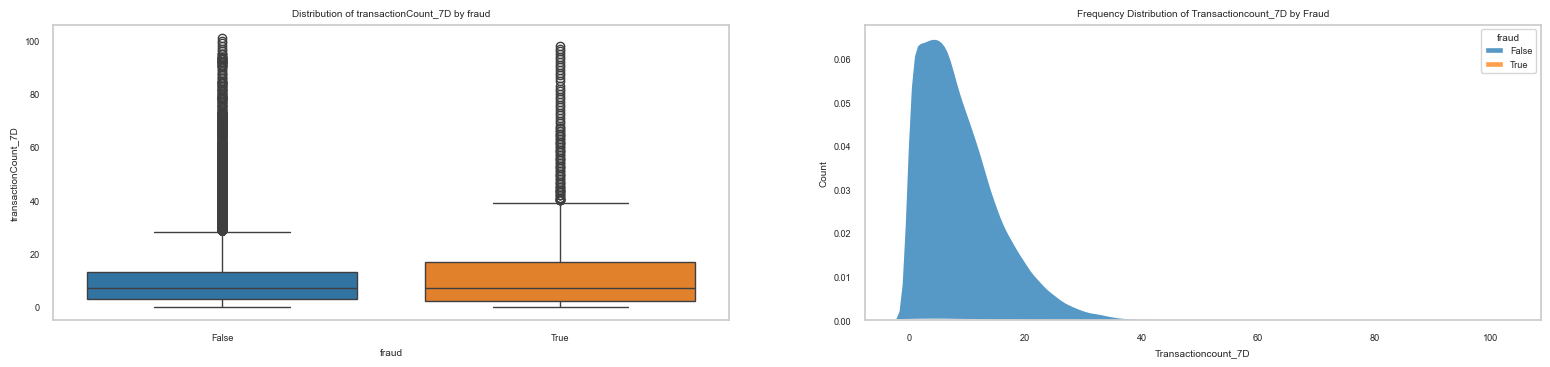

Feature: transactionAmount_7D. p-value: 0.0000. Effect size: -0.0857


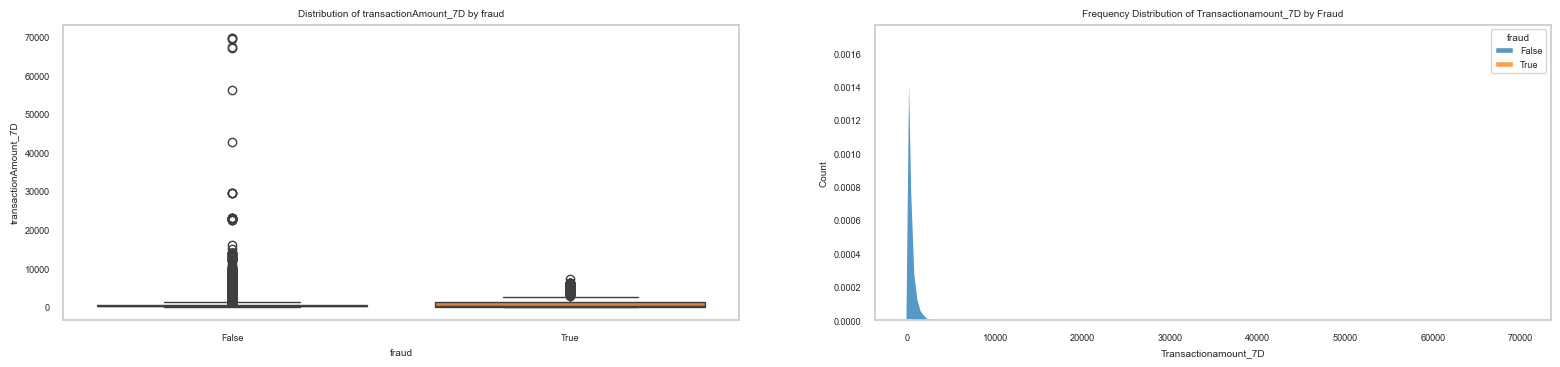

Feature: unique_entry_modes_7D. p-value: 0.0003. Effect size: 0.0678


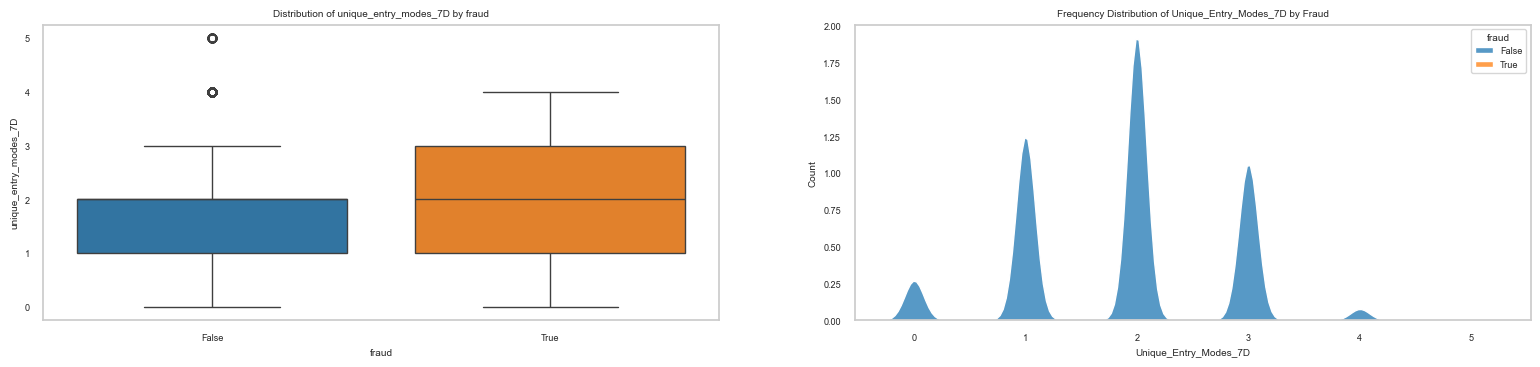

Column            Test Name  P-value  \
0              transactionAmount  Mann-Whitney U test     0.47   
1            cashUtilizationRate  Mann-Whitney U test        0   
2                      hourOfDay  Mann-Whitney U test        0   
3                  hourOfDay_sin  Mann-Whitney U test        0   
4                  hourOfDay_cos  Mann-Whitney U test     0.00   
5       timeSinceLastTransaction  Mann-Whitney U test        0   
6    runningAvgTransactionAmount  Mann-Whitney U test     0.00   
7   merchantAvgTransactionAmount  Mann-Whitney U test     0.00   
8                  isNewMerchant  Mann-Whitney U test        0   
9            uniqueMerchantCount  Mann-Whitney U test        0   
10       spendingPercentageByMCC  Mann-Whitney U test     0.00   
11                  mccDiversity  Mann-Whitney U test        0   
12               avgAmountChange  Mann-Whitney U test     0.84   
13                    freqChange  Mann-Whitney U test     0.02   
14       quickSuccessionCount_1H  Mann-Whitney U test        0   
15             cashDepletionRate  Mann-Whitney U test        0   
16     transactionAmount_mean_7D  Mann-Whitney U test     0.00   
17      transactionAmount_std_7D  Mann-Whitney U test     0.00   
18         availableCash_mean_7D  Mann-Whitney U test        0   
19          availableCash_std_7D  Mann-Whitney U test        0   
20              fraudPressure_1H  Mann-Whitney U test        0   
21              fraudPressure_1D  Mann-Whitney U test        0   
22           transactionCount_1H  Mann-Whitney U test        0   
23          transactionAmount_1H  Mann-Whitney U test        0   
24         unique_entry_modes_1H  Mann-Whitney U test        0   
25           transactionCount_1D  Mann-Whitney U test        0   
26          transactionAmount_1D  Mann-Whitney U test        0   
27         unique_entry_modes_1D  Mann-Whitney U test        0   
28           transactionCount_7D  Mann-Whitney U test     0.17   
29          transactionAmount_7D  Mann-Whitney U test     0.00   
30         unique_entry_modes_7D  Mann-Whitney U test     0.00   

    Test Statistic  Effect Size  Median Group 0  Median Group 1  \
0         52239963         0.01           20.24              21   
1         46157864        -0.10            0.00            0.01   
2         57227200         0.11              12              10   
3         43829921        -0.15               0            0.26   
4         54521326         0.06           -0.00           -0.26   
5         70100686         0.36           14.15            0.35   
6      54502497.50         0.06           43.95           41.21   
7         56167079         0.09           26.20           19.04   
8      43828988.50        -0.15               0               1   
9      66557087.50         0.29             145              61   
10     55273891.50         0.07          679.92          621.76   
11        36162098        -0.30            0.14            0.19   
12     51718830.50         0.00               0               0   
13        53891639         0.05               0           -0.02   
14        34816900        -0.32               0               0   
15     56364855.50         0.09               1            0.99   
16     48229452.50        -0.06           31.43           37.71   
17     48429636.50        -0.06           26.26           31.41   
18        68004734         0.32         7847.83            3500   
19     69094495.50         0.34               0               0   
20        28579590        -0.45               0            0.01   
21     30595461.50        -0.41            0.01            0.04   
22        29194962        -0.43               0               1   
23        29896468        -0.42               0               8   
24        30821046        -0.40               0               1   
25        34814122        -0.32               1               3   
26     35738854.50        -0.31           18.31           82.46   
27     40124926.50        -0.22      

In [90]:
for col in numerical_columns:
    result = numerical_predictor_significance_test(
        df, predictor=col, target=target_column
    )
    df_significance_num = interpret_results_numerical(
        df_significance_num, result, col_name=col
    )
    print(
        f"Feature: {col}. p-value: {result['p_value']:.4f}. Effect size: {result['effect_size']:.4f}"
    )
    draw_predictor_numerical_plots(
        df, predictor=col, target=target_column, hist_type="kde"
    )

df_significance_num

<div class="next-steps">
    <h3>Observations</h3>
    <p>Numerical Features</p>
    <ol>
        <ul>Majority of features are statistically significant, yet only a few features have effect magnitude</ul>
        <ul>Merchant diversity features of the client have practical significance</ul>
        <ul>Rolling 1 hour and 1 day aggregations have practical significance, yet 7-day features seem to lose practical significance</ul>
    </ol>
</div>

## Categorical predictors
We will exclude some high cardinality columns and temporarily convert boolean columns to string datatype.

In [91]:
df_significance_cat = pd.DataFrame()
categorical_columns = df.select_dtypes(exclude=[np.number]).columns

exclude_columns = ["fraud"]
chart_columns = [col for col in categorical_columns if col not in exclude_columns]

bool_cols = df[chart_columns].select_dtypes(include=["bool"]).columns
for col in bool_cols:
    df[col] = df[col].astype(str)

Feature: mccCategory. p-value: 0.0000. Effect size: 0.1002


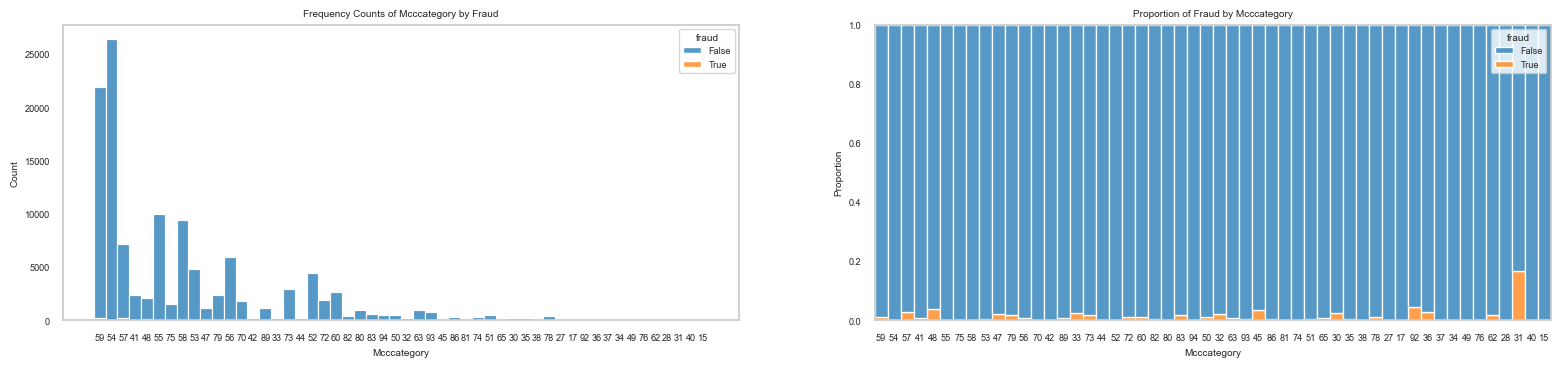

Feature: isHighRiskCategory. p-value: 0.0000. Effect size: 0.0351


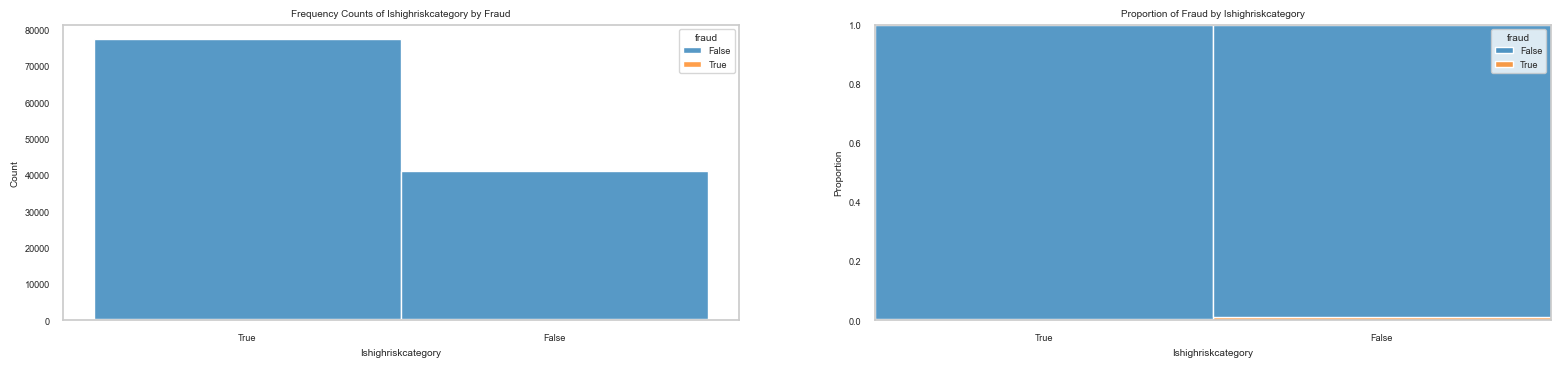

Feature: isCardPresent. p-value: 0.0000. Effect size: 0.1009


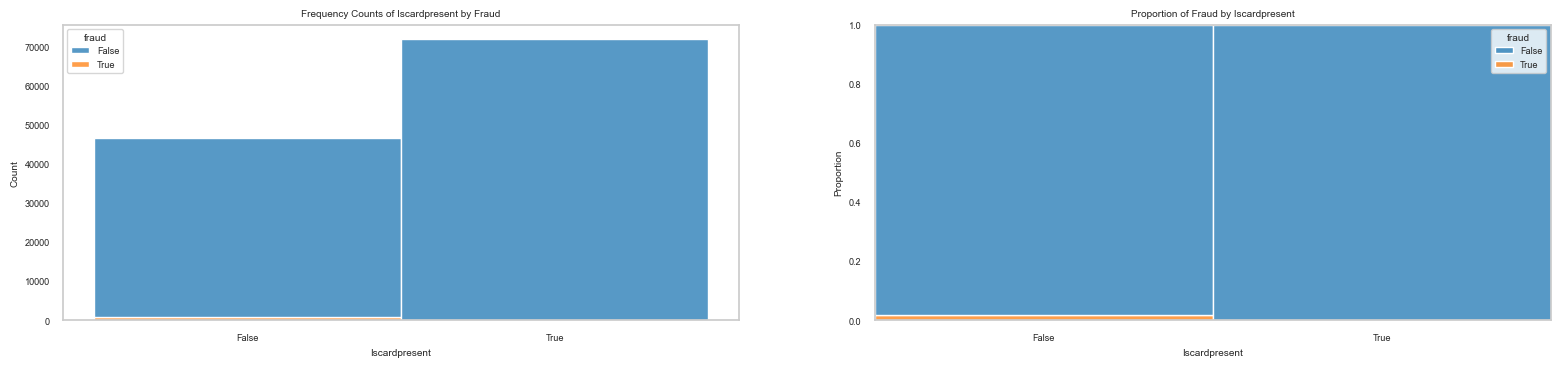

Feature: isFallback. p-value: 0.8276. Effect size: 0.0006


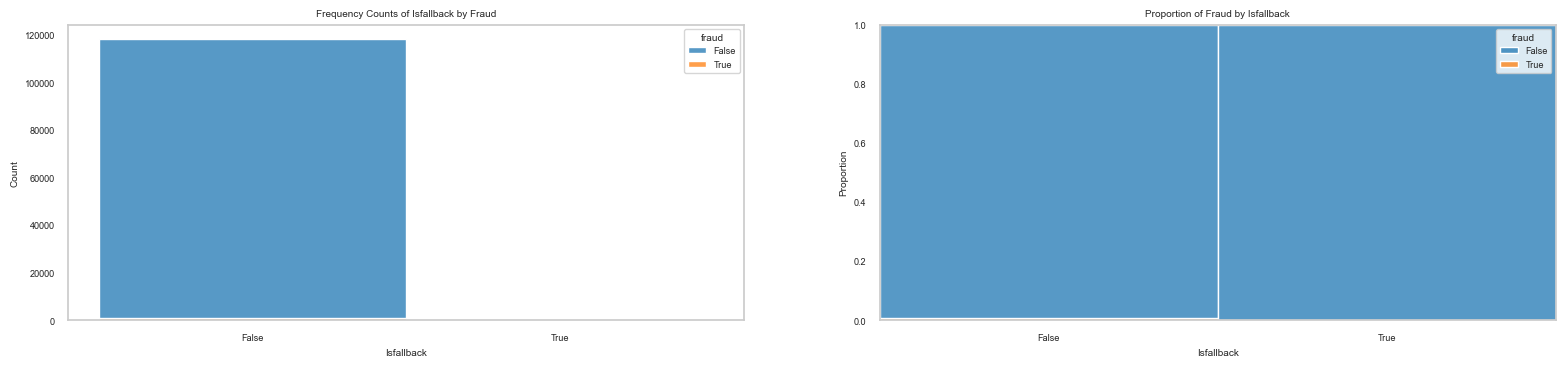

Feature: isEcommerce. p-value: 0.0000. Effect size: 0.0784


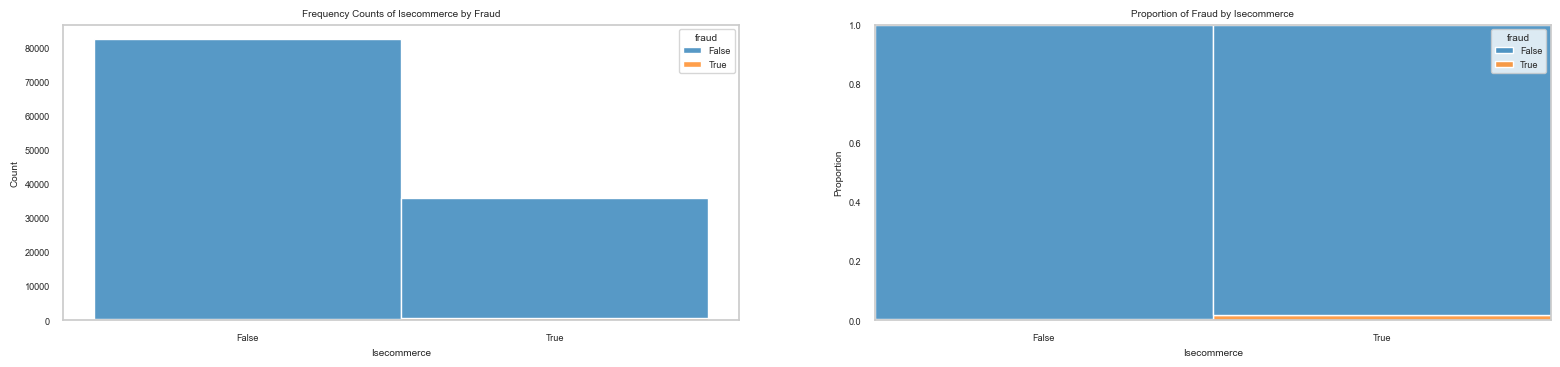

Feature: isManualEntry. p-value: 0.0000. Effect size: 0.0455


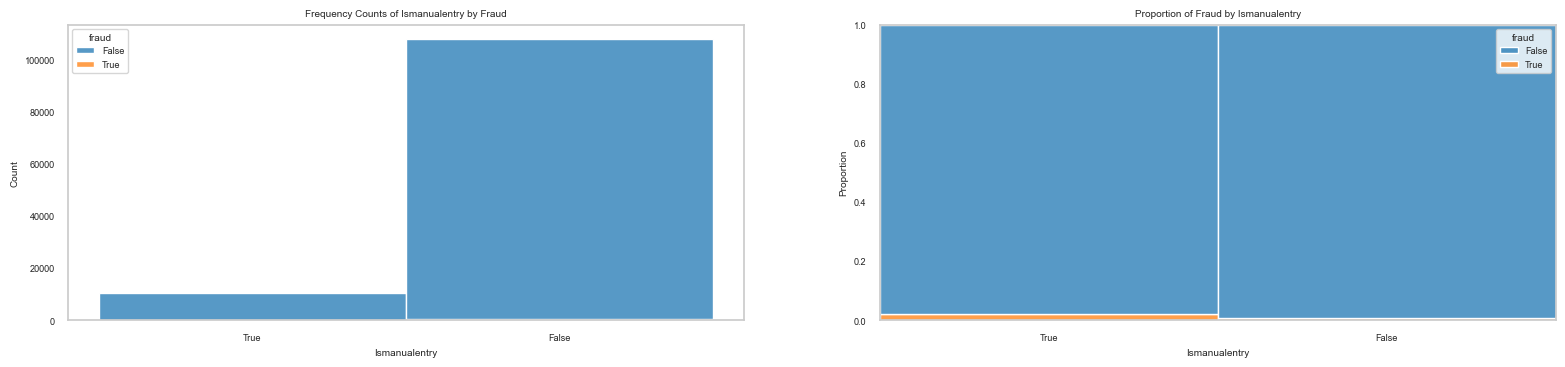

Feature: isRoundAmount. p-value: 0.1030. Effect size: 0.0047


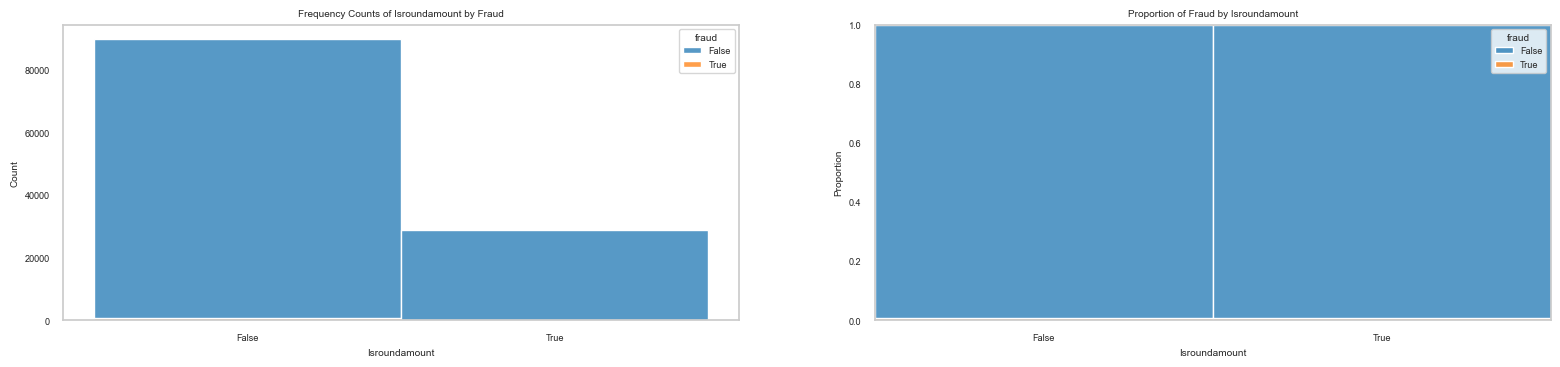

Feature: isWeekend. p-value: 0.0000. Effect size: 0.0129


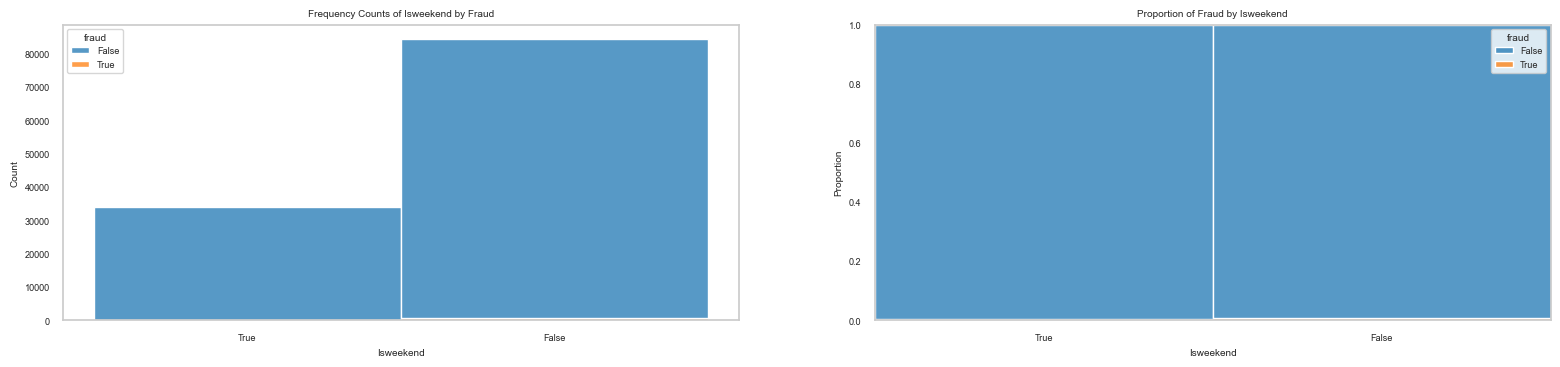

Feature: isLateNight. p-value: 0.5398. Effect size: 0.0018


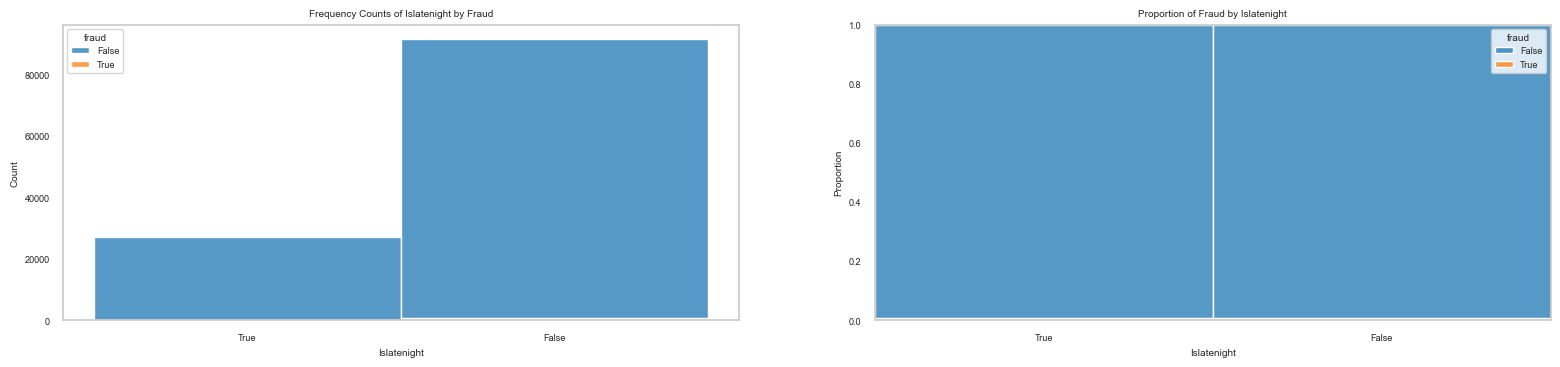

Feature: isInternational. p-value: 0.0000. Effect size: 0.0974


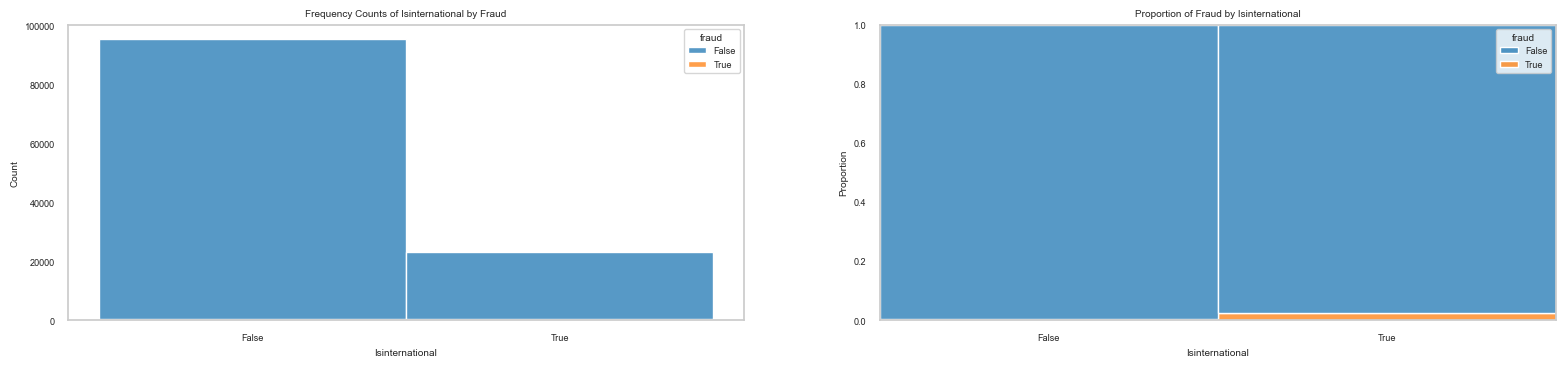

Feature: zipMatchesCountry. p-value: 0.0000. Effect size: 0.0751


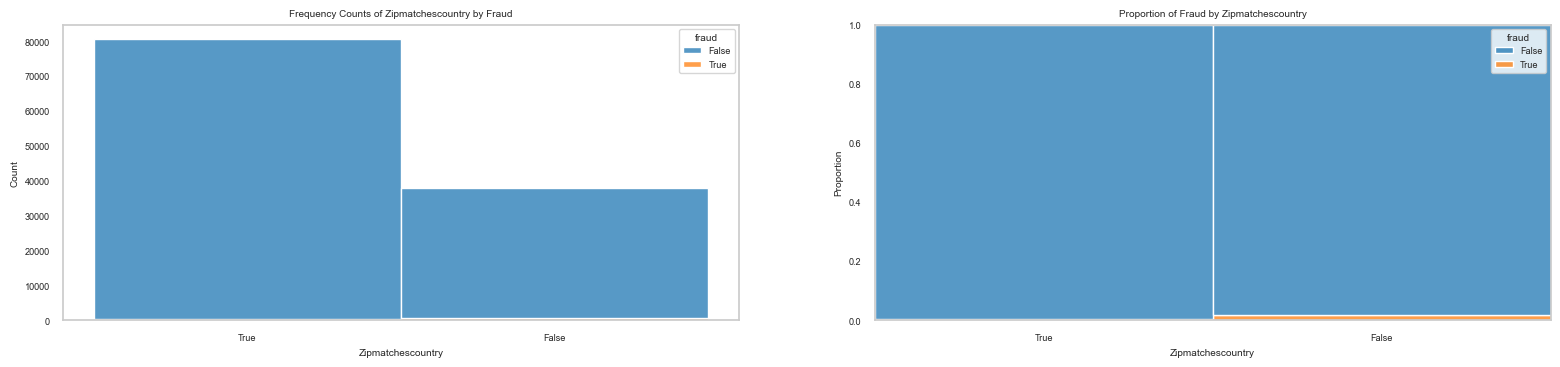

Feature: unusualEntryMode. p-value: 0.0000. Effect size: 0.0428


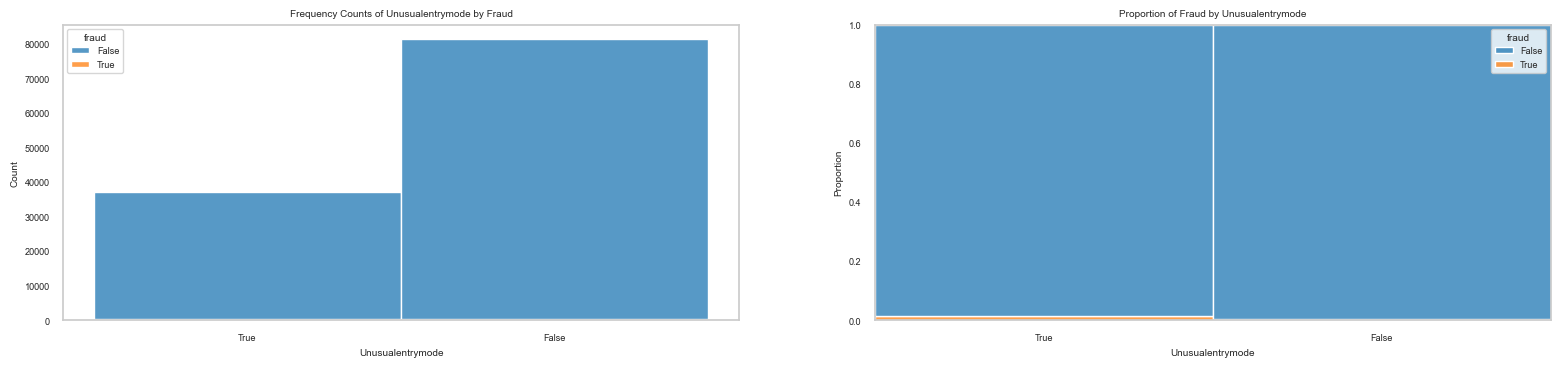

Feature: entryModeChanged. p-value: 0.0098. Effect size: 0.0075


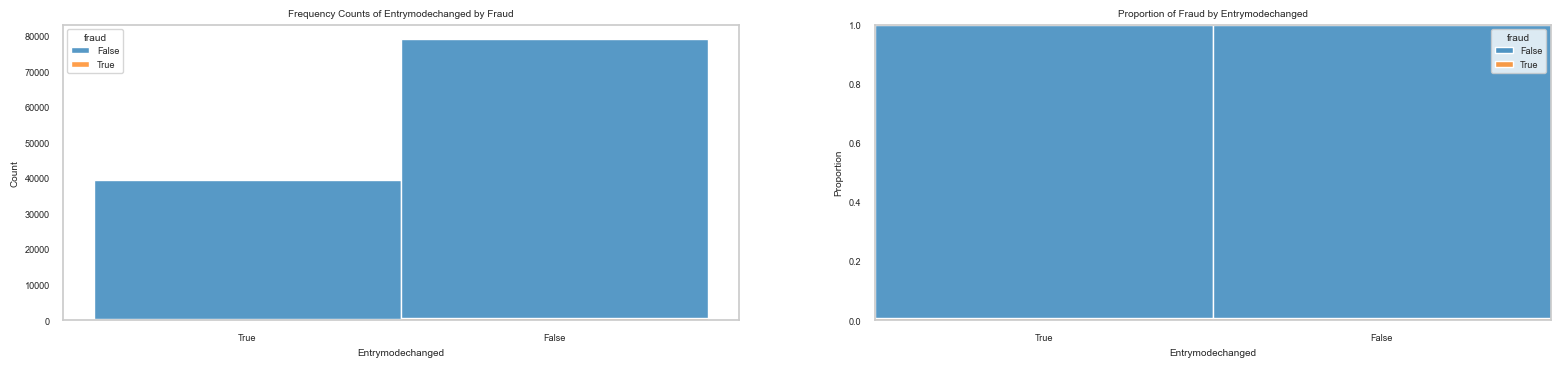

Feature: isQuickSuccession. p-value: 0.0000. Effect size: 0.1115


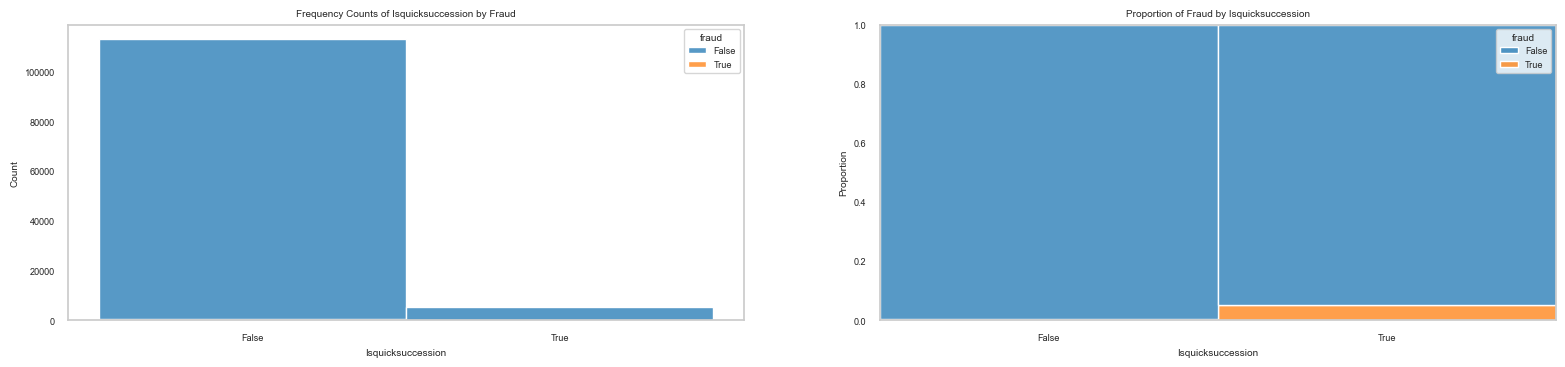

Feature: highRiskCombo. p-value: 0.0000. Effect size: 0.0391


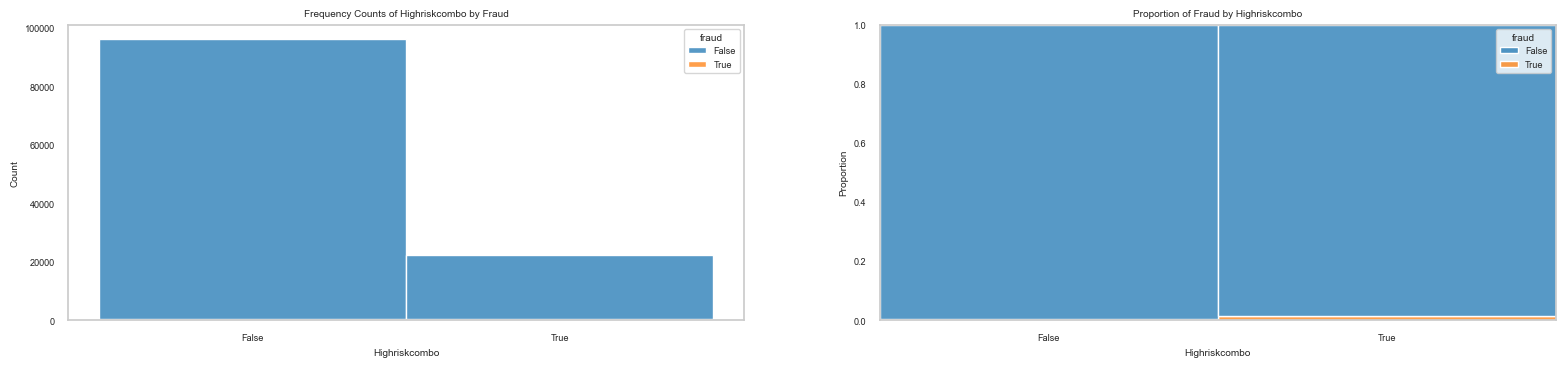

Column         Test Name  P-value  Chi-squared statistic  \
0          mccCategory  Chi-squared test        0                1189.97   
1   isHighRiskCategory  Chi-squared test        0                 146.01   
2        isCardPresent  Chi-squared test        0                1207.84   
3           isFallback  Chi-squared test     0.83                   0.05   
4          isEcommerce  Chi-squared test        0                 728.31   
5        isManualEntry  Chi-squared test        0                 245.50   
6        isRoundAmount  Chi-squared test     0.10                   2.66   
7            isWeekend  Chi-squared test     0.00                  19.63   
8          isLateNight  Chi-squared test     0.54                   0.38   
9      isInternational  Chi-squared test        0                1124.86   
10   zipMatchesCountry  Chi-squared test        0                 668.93   
11    unusualEntryMode  Chi-squared test        0                 217.06   
12    entryModeChanged  Chi-squared test     0.01                   6.67   
13   isQuickSuccession  Chi-squared test        0                1474.13   
14       highRiskCombo  Chi-squared test        0                 181.69   

    Degrees of freedom  Effect size (Cramer's V)  \
0                   51                      0.10   
1                    1                      0.04   
2                    1                      0.10   
3                    1                      0.00   
4                    1                      0.08   
5                    1                      0.05   
6                    1                      0.00   
7                    1                      0.01   
8                    1                      0.00   
9                    1                      0.10   
10                   1                      0.08   
11                   1                      0.04   
12                   1                      0.01   
13                   1                      0.11   
14                   1                      0.04   

                     Significance Effect Magnitude  
0       Statistically significant            small  
1       Statistically significant       negligible  
2       Statistically significant            small  
3   Not statistically significant       negligible  
4       Statistically significant       negligible  
5       Statistically significant       negligible  
6   Not statistically significant       negligible  
7       Statistically significant       negligible  
8   Not statistically significant       negligible  
9       Statistically significant       negligible  
10      Statistically significant       negligible  
11      Statistically significant       negligible  
12      Statistically significant       negligible  
13      Statistically significant            small  
14      Statistically significant       negligible

In [92]:
for col in chart_columns:
    result = categorical_predictor_significance_test(
        df, predictor=col, target=target_column
    )
    df_significance_cat = interpret_results_categorical(
        df_significance_cat, result, col_name=col
    )
    print(
        f"Feature: {col}. p-value: {result['p_value']:.4f}. Effect size: {result['effect_size']:.4f}"
    )
    draw_predictor_categorical_plots(df, predictor=col, target=target_column)

df_significance_cat

<div class="next-steps">
    <h3>Observations</h3>
    <p></p>
    <ol>
        <ul><code>mccCategory</code> has small practical significance, as some small groups have relatively higher fraud rates</ul>
        <ul>The presence of a card in the transaction has practical significance in identifying fraudulent transactions</ul>
        <ul>Quick succession is a phenomenon that is also useful for predicting the risk of fraud</ul>
    </ol>
</div>

Let's restore the boolean columns back to **bool** datatype and summarize EDA.

In [93]:
for col in bool_cols:
    df[col] = df[col].astype("bool")

<div class="results">
    <h3>EDA Results</h3>
    <p>Key predictors</p>
    <ol>
        <ul>Feature Engineering was successful, with a lot of new features providing information in predicting fraud</ul>
        <ul>Quick succession, the phenomenon where multiple transactions happen in a short amount of time, have imnportance in predicting fraud</ul>
        <ul>Rolling features within a scope of a day or an hour have predictive power; Longer periods lose predictive power</ul>
        <ul>Merchant location and categories have predictive power, especially when the latter, using domain knowledge, is categorized as high risk or not</ul>
    </ol>
</div>

# Statistical Modeling
* Data Split: **Train-test** with custom class `CustomTimeSeriesSplitter`
* Performance Metric: Area under Precision-Recall curve (**AUPRC**)
* Models:
  * Neural Network
  * LightGBM
  * CatBoost
  * Logistic Regression
  * Balanced Random Forest Classifier
* Baseline: Result of the best performing model on the raw data

In [94]:
df = pd.read_csv(os.path.join(DATA_FOLDER, "transactions_obf.csv"))
df = prepare_dataset(df, df_labels)
X = df.drop(columns=["fraud"], axis=1)
y = df["fraud"]

## Train/Test Method
As noted previously, `fraud` cases were not consistent - there were spikes of frauds in the dataset which may create a disbalance between the train and test performance. Additionally, rolling features require special treatment; improper splits may cause data leakage.

We will use the following approach with a custom class:
* The data is split into 5 folds (default setting).
* Each fold creates a test set from the most recent data, with a test period of 30 days.
* There's a gap period of 30 days between the training and test sets to prevent data leakage.
* The training set consists of all data before the gap period.
* For each subsequent fold, the process moves backwards in time, creating new train/test splits.

This method ensures that:
* The model is always trained on past data and tested on future data.
* There's no overlap between training and test sets.
* The approach simulates how the model would be used in a real-world scenario, where you train on historical data and predict future events.

In [95]:
splitter = CustomTimeSeriesSplitter(
    n_splits=5, test_period="30D", gap_period="30D", min_train_period="180D"
)

In [96]:
summary_df, fig = visualize_folds(X, y, splitter)

print("Fold Summary Statistics:")
display(summary_df)

print("\nTime Period Visualization:")
display(fig)

Fold Summary Statistics:


Fold              Train Period               Test Period Train Samples  \
0  Fold 1  2017-01-01 to 2017-12-01  2018-01-01 to 2018-01-31       101,199   
1  Fold 2  2017-01-01 to 2017-10-03  2017-11-02 to 2017-12-01        84,627   
2  Fold 3  2017-01-01 to 2017-08-04  2017-09-03 to 2017-10-03        64,948   
3  Fold 4  2017-01-01 to 2017-06-04  2017-07-05 to 2017-08-04        46,352   
4  Fold 5  2017-01-01 to 2017-04-06  2017-05-06 to 2017-06-04        28,793   

  Test Samples Train Fraud % Test Fraud %  
0        8,530         0.78%        0.46%  
1        8,164         0.77%        0.51%  
2        9,086         0.72%        1.22%  
3        9,933         0.50%        0.90%  
4        8,844         0.50%        0.36%


Time Period Visualization:


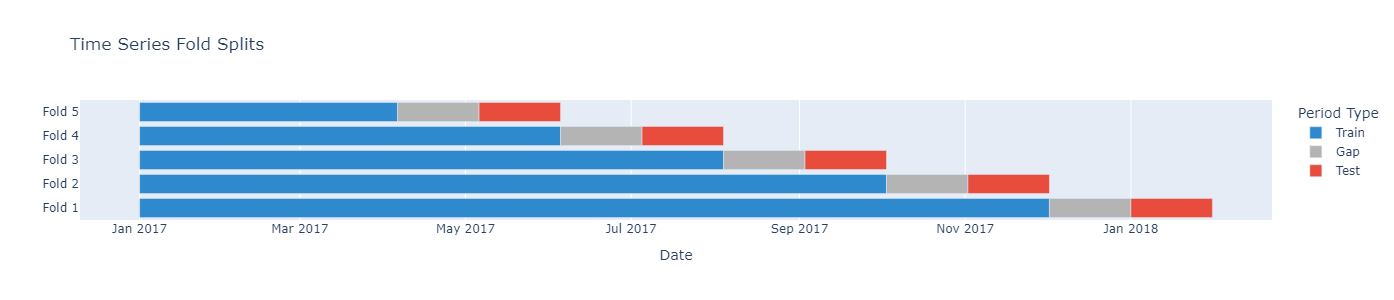

In [97]:
Image('media/time_series_split.png')

## Performance Baseline
Let's train all the selected models on the raw data and select the best performing one as the baseline. We will also consider the following:
* Dropping some very high cardinality features that may cause overfitting
* Encoding with `OneHotEncoder` (<10 unique values) and `MeanEncoder` (>=10 unique values)
* Custom time-based train/test split `CustomTimeSeriesSplitter`

First let's initialize the models and declare dataset & performance tracking variables.

In [98]:
models = {
    "LightGBM": LGBMClassifier(random_state=RANDOM_STATE, verbose=-1),
    "Balanced Random Forest": BalancedRandomForestClassifier(random_state=RANDOM_STATE),
    "Neural Network": Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            (
                "mlp",
                MLPClassifier(
                    hidden_layer_sizes=(100, 50),
                    max_iter=500,
                    random_state=RANDOM_STATE,
                ),
            ),
        ]
    ),
    "Logistic Regression": Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            ("lr", LogisticRegression(random_state=RANDOM_STATE)),
        ]
    ),
}

all_models_importances = {}

df_performance_auprc = pd.DataFrame(columns=["Model"])
df_performance_auprc["Model"] = models.keys()

cols_remove = [
    "transactionTime",
    "eventId",
    "accountNumber",
    "merchantId",
    "merchantZip",
    "mcc",
    "merchantCountry",
]

Baseline dataset:

In [99]:
df_raw = prepare_dataset(
    df=pd.read_csv(os.path.join(DATA_FOLDER, "transactions_obf.csv")),
    df_labels=df_labels,
)
df_raw = df_raw.drop(
    columns=[
        "transactionTime",
        "eventId",
        "accountNumber",
        "merchantId",
        "merchantZip",
    ],
    axis=1,
)
X_raw = df_raw.drop(columns=["fraud"], axis=1)
y_raw = df_raw["fraud"]

Production dataset, that we will use throughout the Statistical Modelling process:

In [100]:
df = prepare_dataset(
    df=pd.read_csv(os.path.join(DATA_FOLDER, "transactions_obf.csv")),
    df_labels=df_labels,
)
X = df.drop(columns=["fraud"], axis=1)
y = df["fraud"]

Configuration for the model trainings we will perform

Baseline performance:
LightGBM trained in 1.33 seconds.
AUPRC: 0.0331



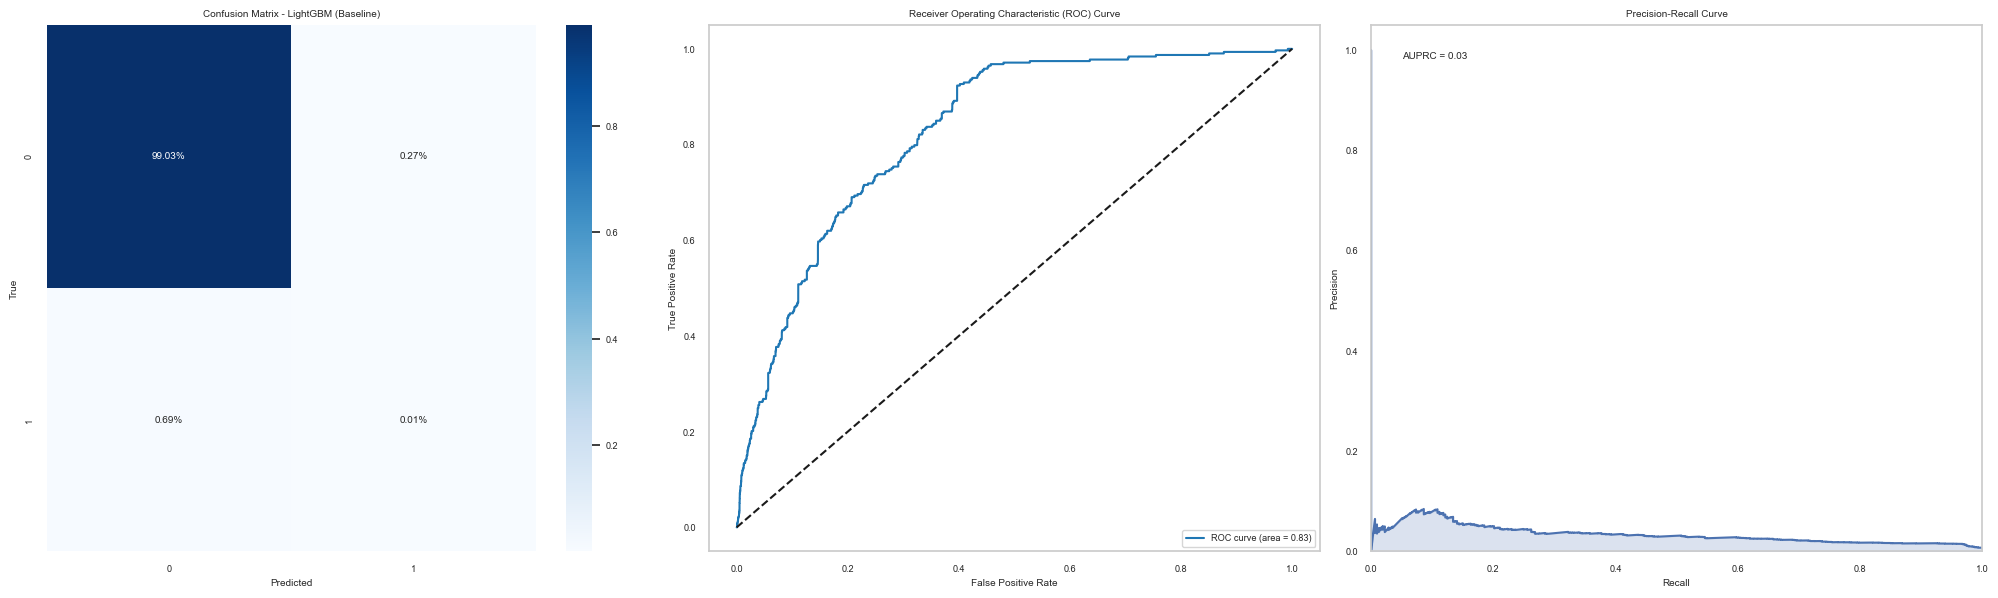

Balanced Random Forest trained in 5.38 seconds.
AUPRC: 0.0415



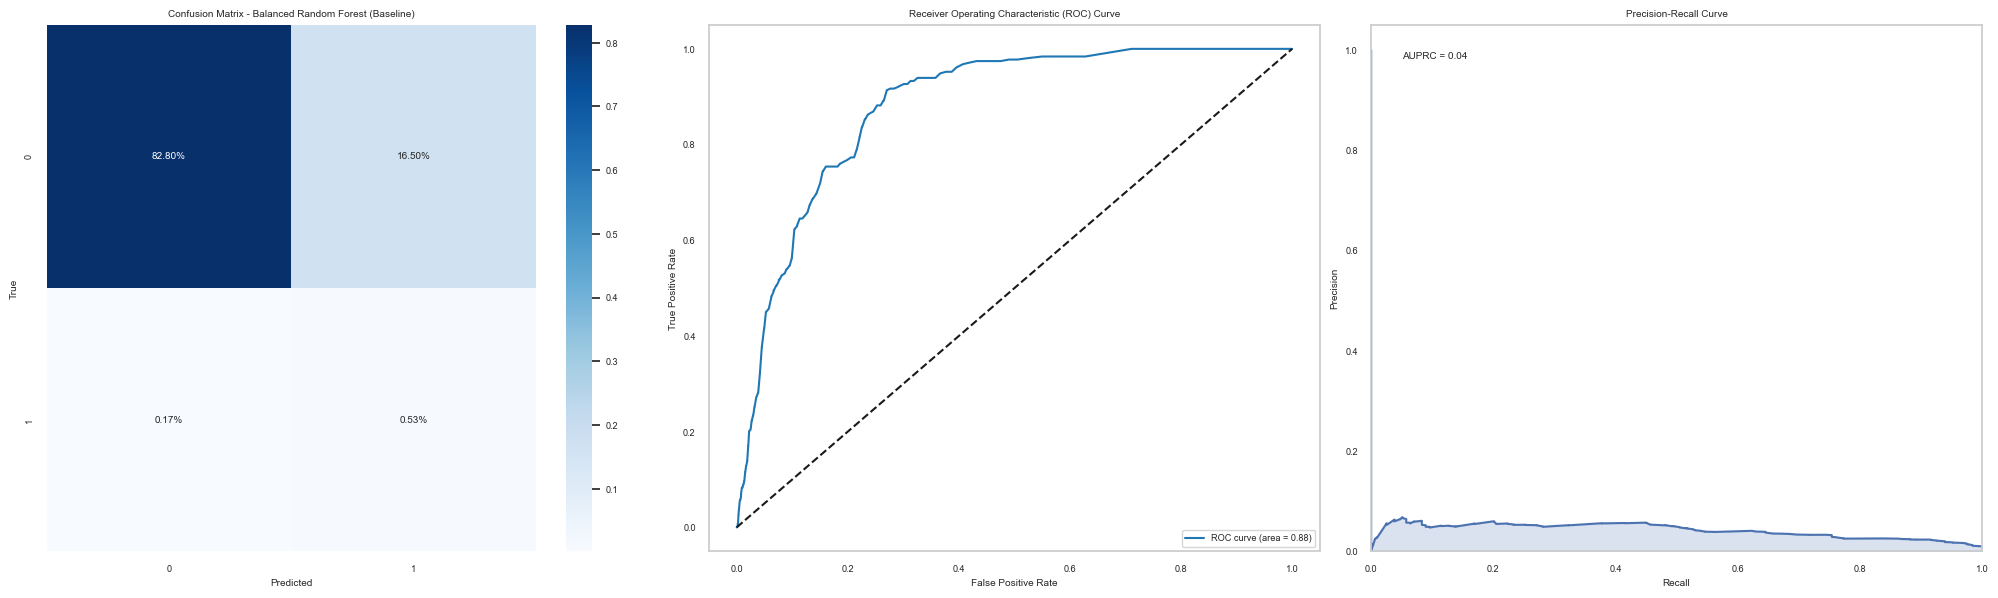

Neural Network trained in 212.11 seconds.
AUPRC: 0.0237



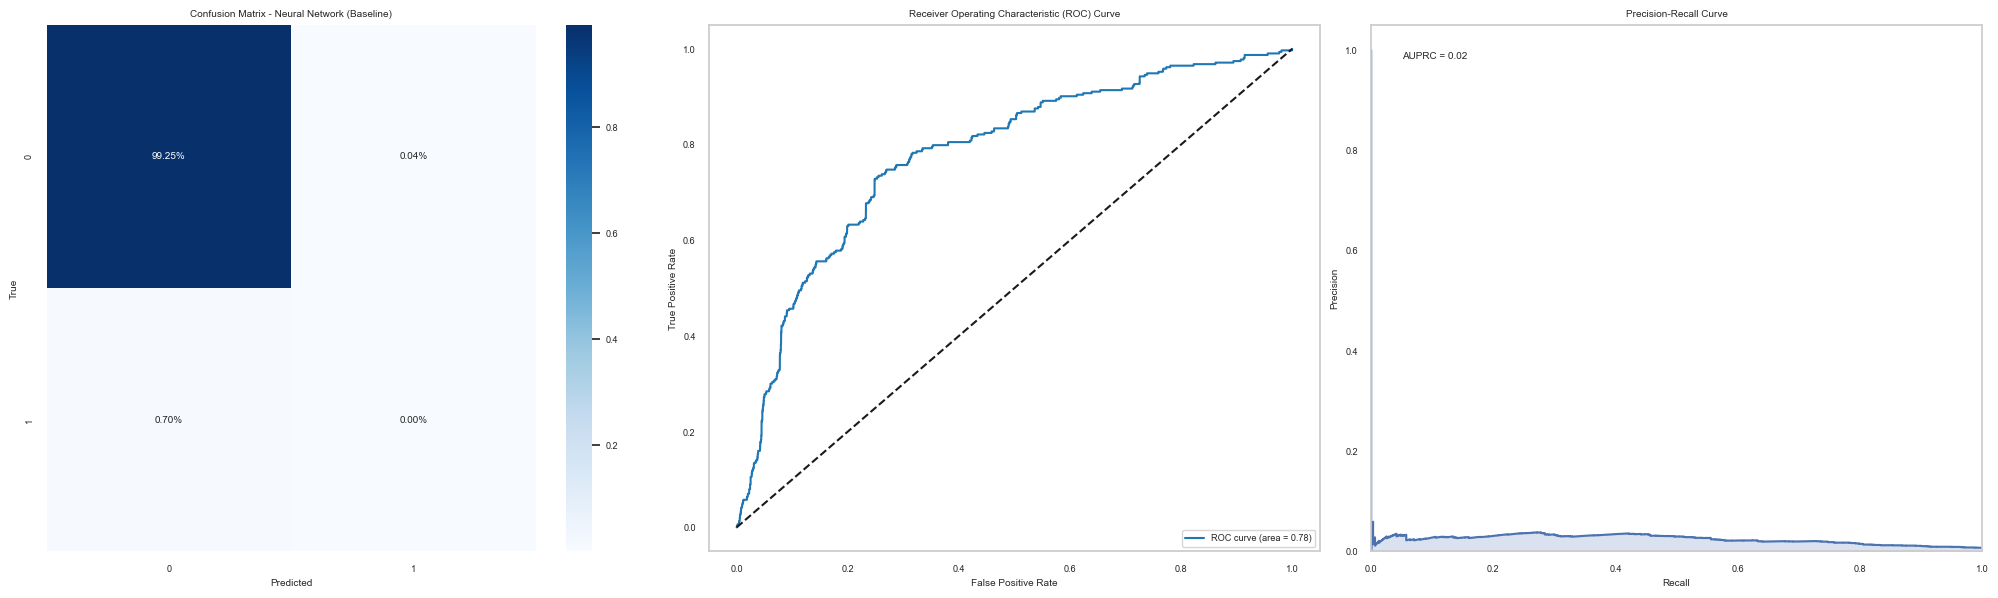

Logistic Regression trained in 0.52 seconds.
AUPRC: 0.0183



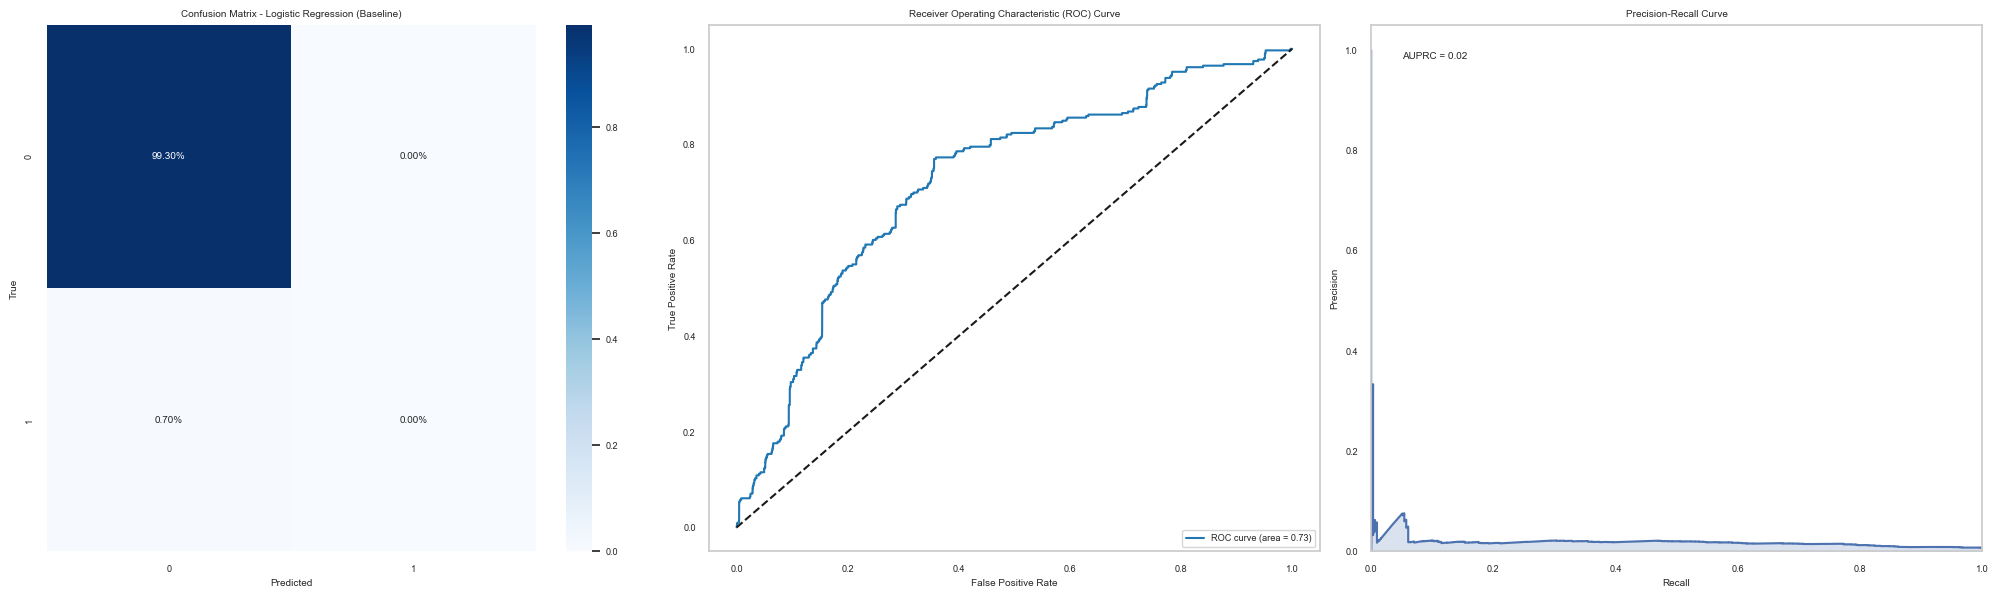

In [101]:
if TRAIN_MODELS:
    print(f"Baseline performance:")
    test_name = 'Baseline'
    for model_name, model in models.items():
        results_df = train_model(
            X=X_raw,
            y=y,
            cv_splitter=splitter,
            model=model,
            model_name=model_name,
            production_model=False,
            cols_remove=[],
            imbalance_handling=None,
        )
        df_performance_auprc = summarize_results(
            model_name,
            df_performance_auprc,
            results_df,
            column_name=test_name,
        )
        visualize_performance(
            y=results_df["true"],
            y_pred=results_df["pred"],
            y_pred_proba=results_df["pred_proba"],
            model_name=f'{model_name} ({test_name})'
        )

del X_raw, y_raw

<div class="results">
    <h3>Model Results</h3>
    <p>Baseline Models</p>
    <ol>
        <ul>Most baseline models predict the majority class - imbalance handling will be necessary</ul>
        <ul>Balanced Random Forest shows a lot of promise with a great false positive rate and fraud identification</ul>
    </ol>
</div>

Next, let's train the models using the newly created features.

Post-FE performance:
LightGBM trained in 78.14 seconds.
AUPRC: 0.0521



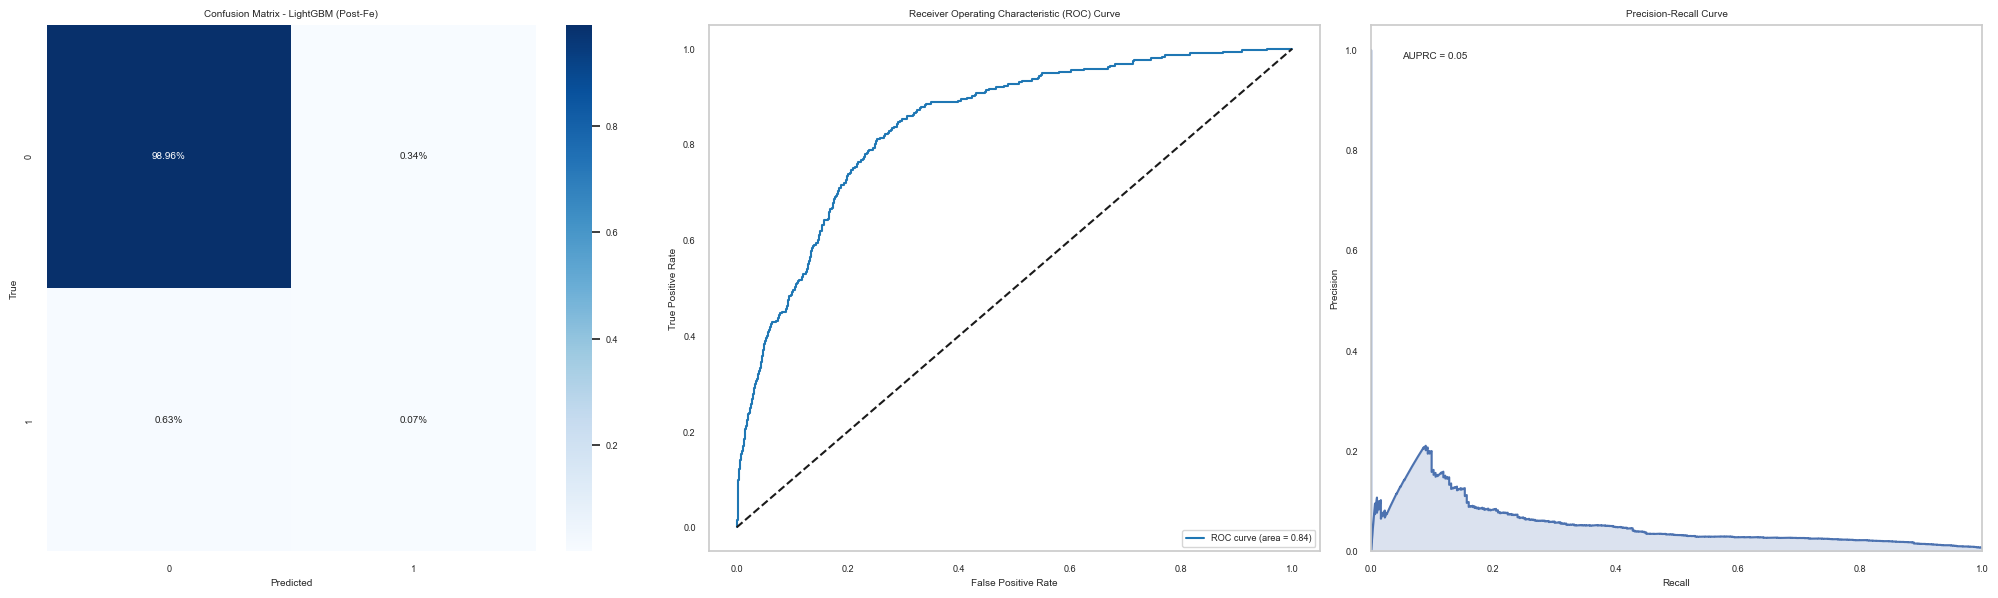

Balanced Random Forest trained in 81.37 seconds.
AUPRC: 0.0415



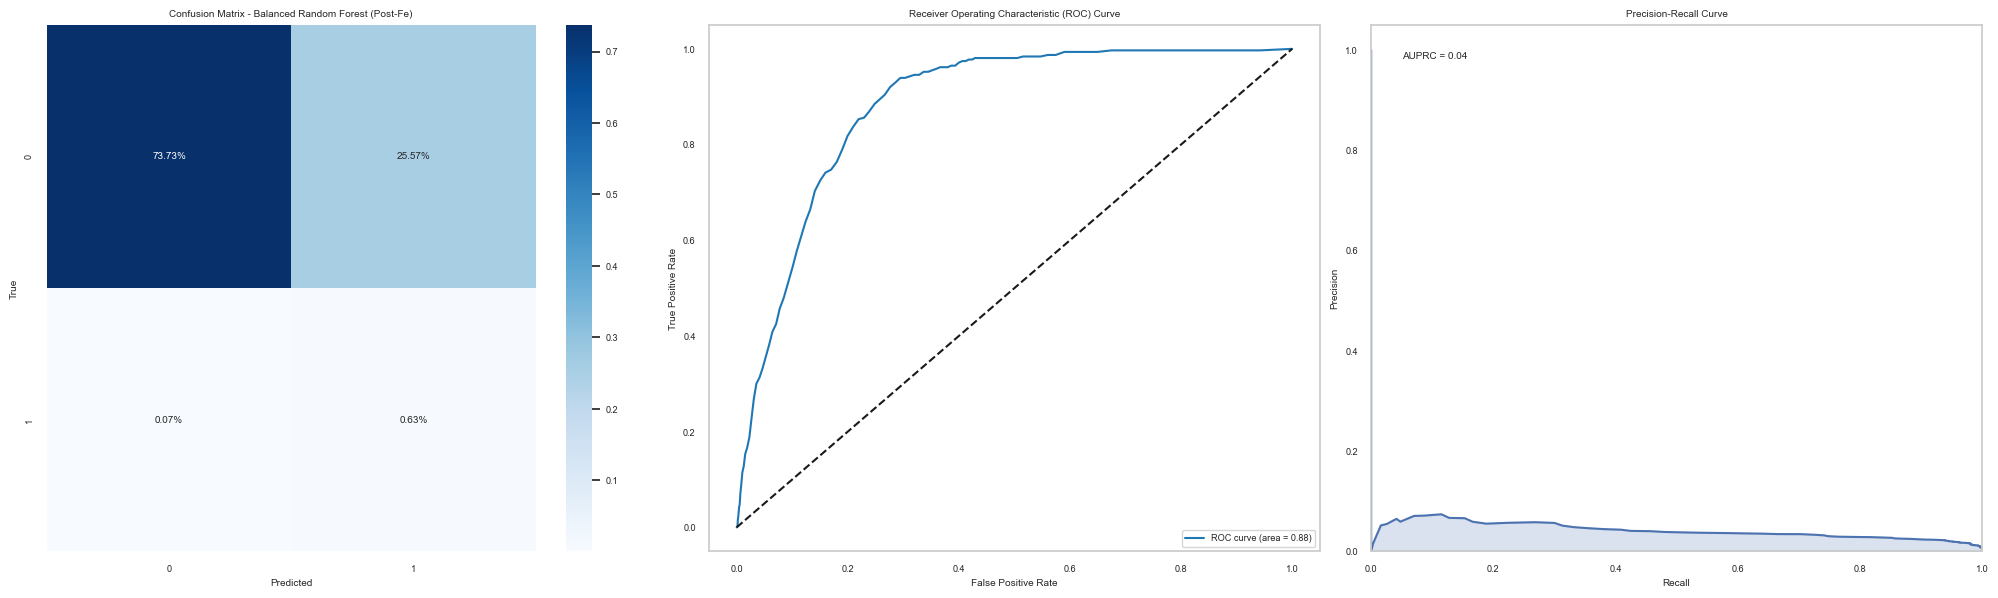

Neural Network trained in 227.39 seconds.
AUPRC: 0.0125



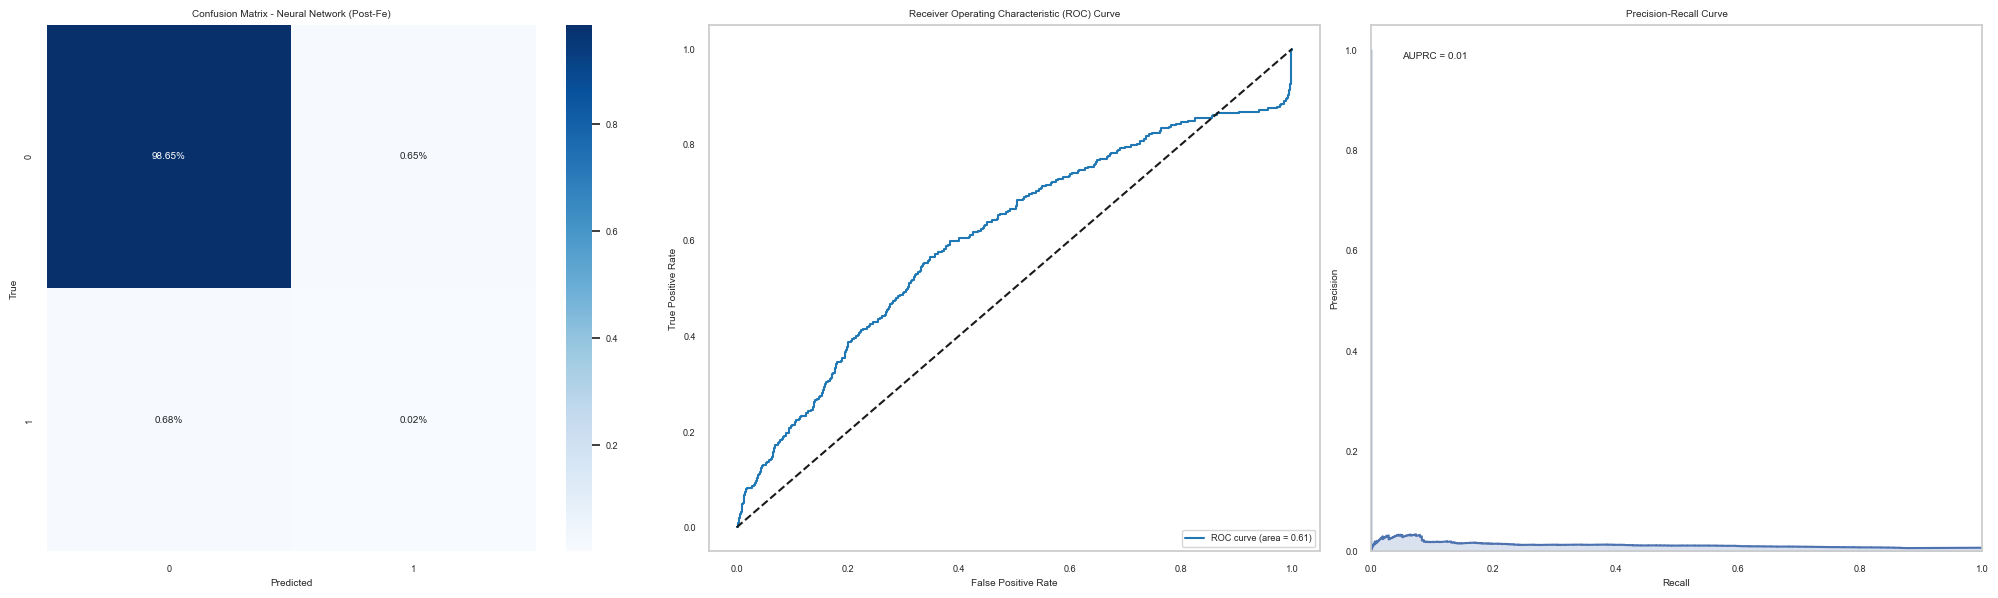

Logistic Regression trained in 71.89 seconds.
AUPRC: 0.0388



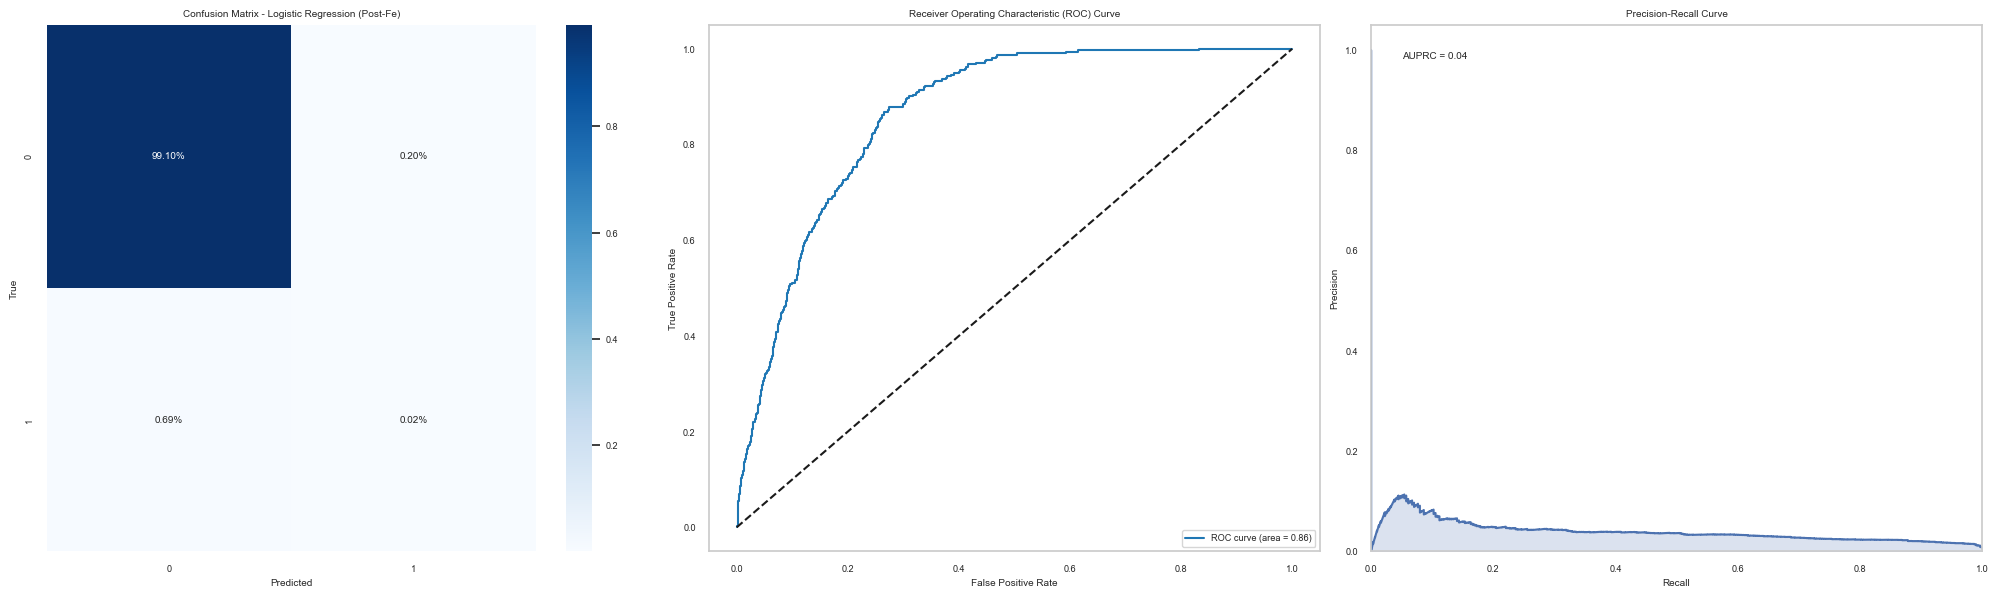

In [102]:
if TRAIN_MODELS:
    print(f"Post-FE performance:")
    test_name = 'Post-Fe'
    for model_name, model in models.items():
        results_df = train_model(
            X=X,
            y=y,
            cv_splitter=splitter,
            model=model,
            model_name=model_name,
            production_model=True,
            cols_remove=cols_remove,
            imbalance_handling=None,
        )

        df_performance_auprc = summarize_results(
            model_name,
            df_performance_auprc,
            results_df,
            column_name=test_name,
        )

        visualize_performance(
            y=results_df["true"],
            y_pred=results_df["pred"],
            y_pred_proba=results_df["pred_proba"],
            model_name=f'{model_name} ({test_name})'
        )

In [103]:
print("AUPRC scores:")
if TRAIN_MODELS == False:
    df_performance_auprc = pd.read_csv("exports/auprc.csv", index_col=0)
df_performance_auprc

AUPRC scores:


Model  Baseline  Post-Fe
0                LightGBM      0.03     0.05
1  Balanced Random Forest      0.04     0.04
2          Neural Network      0.02     0.01
3     Logistic Regression      0.02     0.04

The Post-FE results look promising for 3 out of 5 models. Let's perform tuning with Optuna next.

## Model Tuning with Optuna

We will select some of the models to tune further with optuna.

In [104]:
model_trials = {
    "Balanced Random Forest": 50,
    "Neural Network": 75,
    "Logistic Regression": 50,
    "LightGBM": 50,
}
if TUNE_MODELS:
    for model_name in model_trials.keys():
        run_optimization(
            X,
            y,
            model_name,
            cols_remove=cols_remove,
            metric="AUPRC",
            model_trials=model_trials[model_name],
        )


Model: Balanced Random Forest
AUPRC: 0.0428
Total training time: 88.33 seconds.


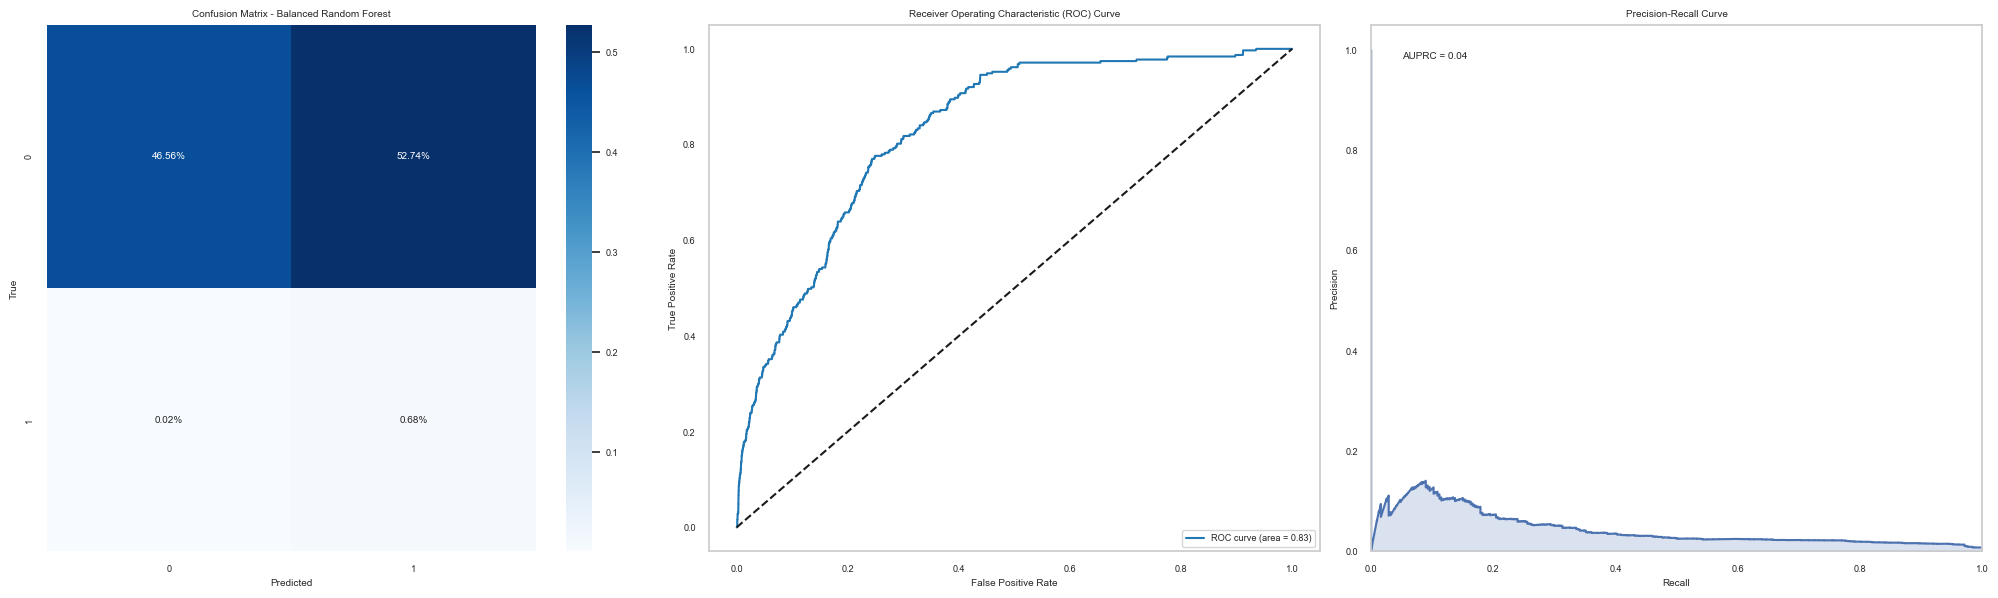

Model Balanced Random Forest Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.47      0.64     44244
        True       0.01      0.97      0.03       313

    accuracy                           0.47     44557
   macro avg       0.51      0.72      0.33     44557
weighted avg       0.99      0.47      0.63     44557


Model: Neural Network
AUPRC: 0.0731
Total training time: 121.02 seconds.


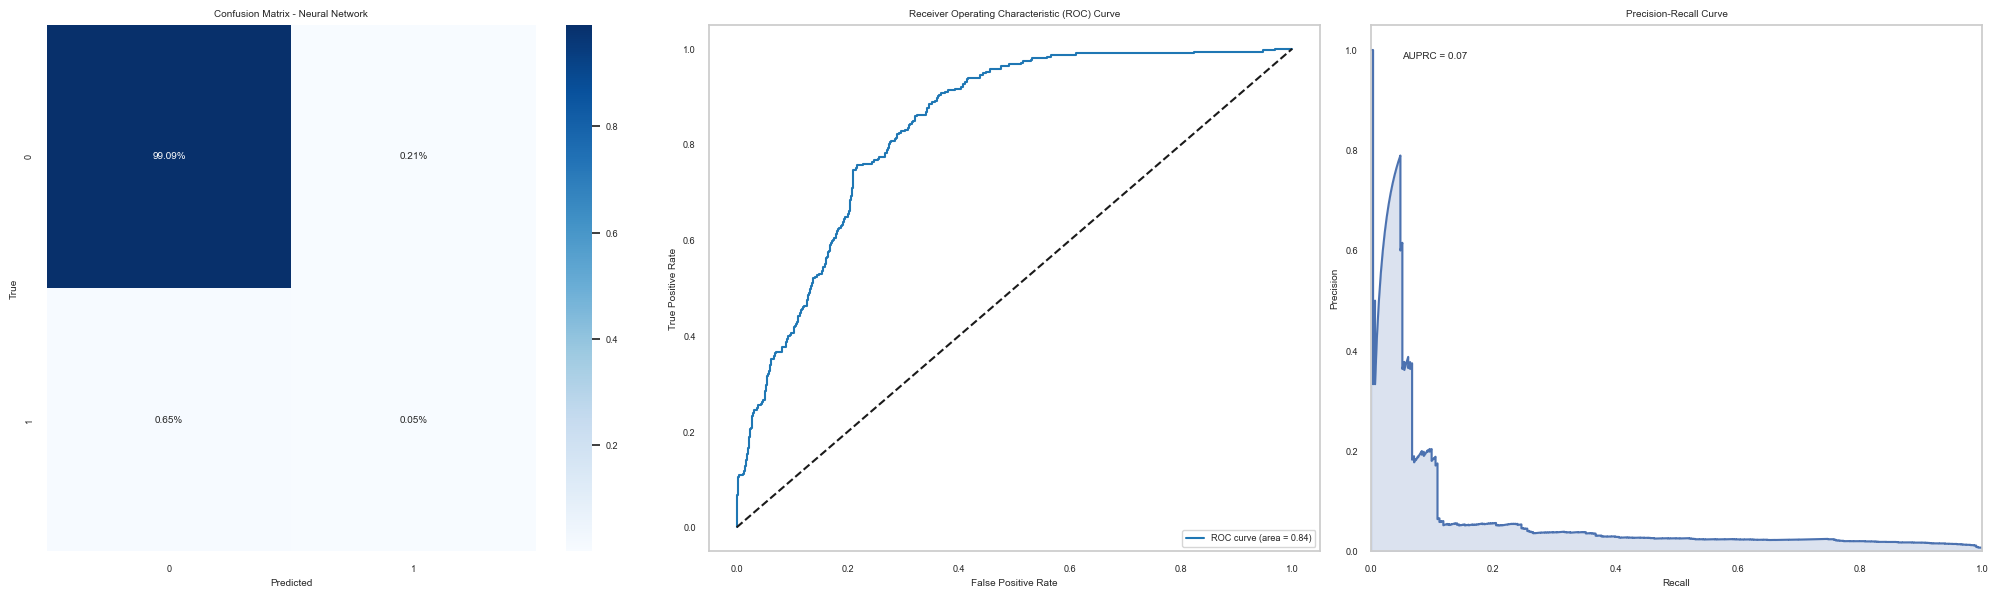

Model Neural Network Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00     44244
        True       0.19      0.07      0.10       313

    accuracy                           0.99     44557
   macro avg       0.59      0.53      0.55     44557
weighted avg       0.99      0.99      0.99     44557


Model: Logistic Regression
AUPRC: 0.1555
Total training time: 235.54 seconds.


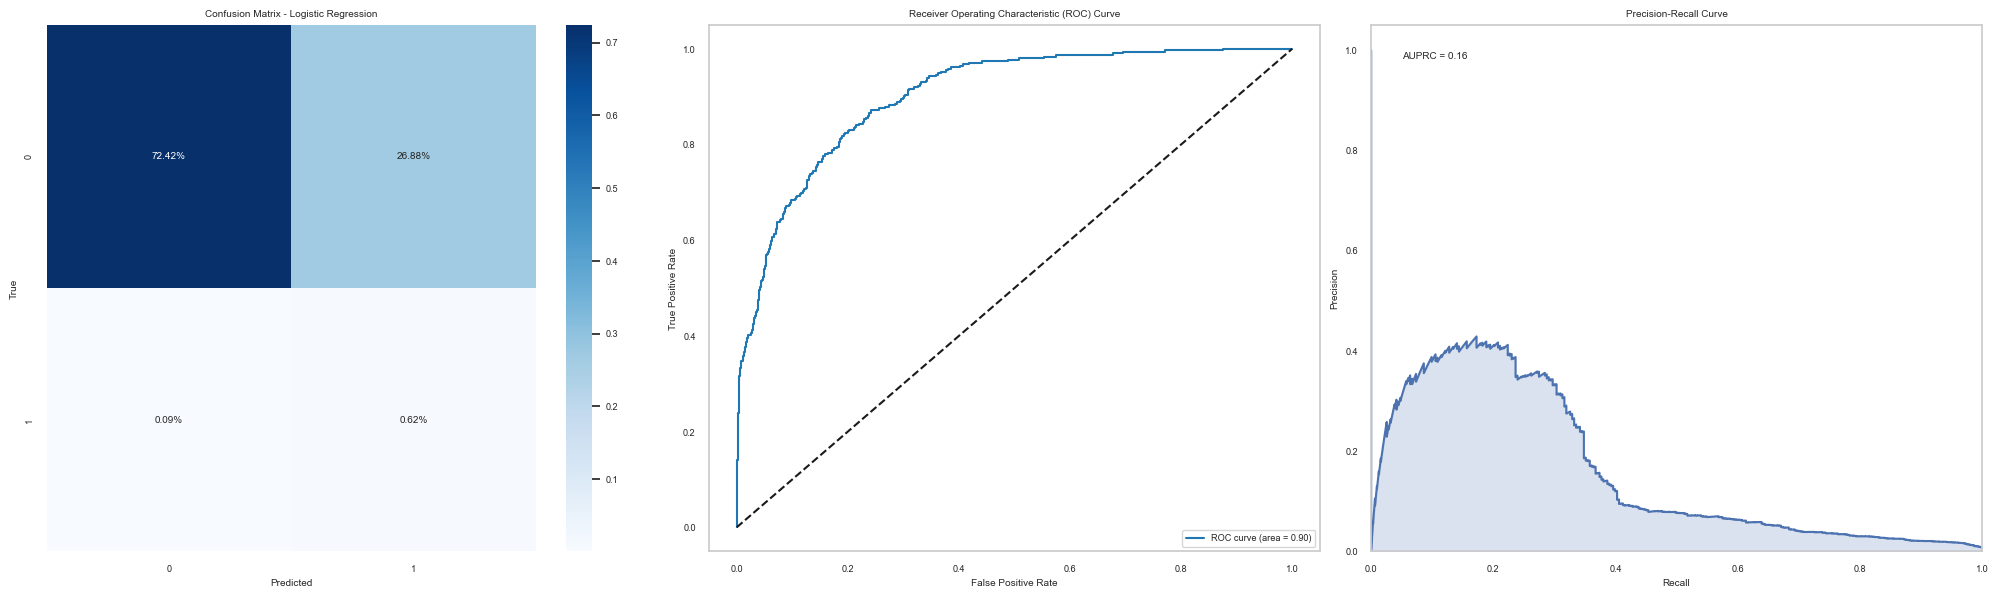

Model Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.73      0.84     44244
        True       0.02      0.88      0.04       313

    accuracy                           0.73     44557
   macro avg       0.51      0.80      0.44     44557
weighted avg       0.99      0.73      0.84     44557


Model: LightGBM
AUPRC: 0.1269
Total training time: 137.53 seconds.


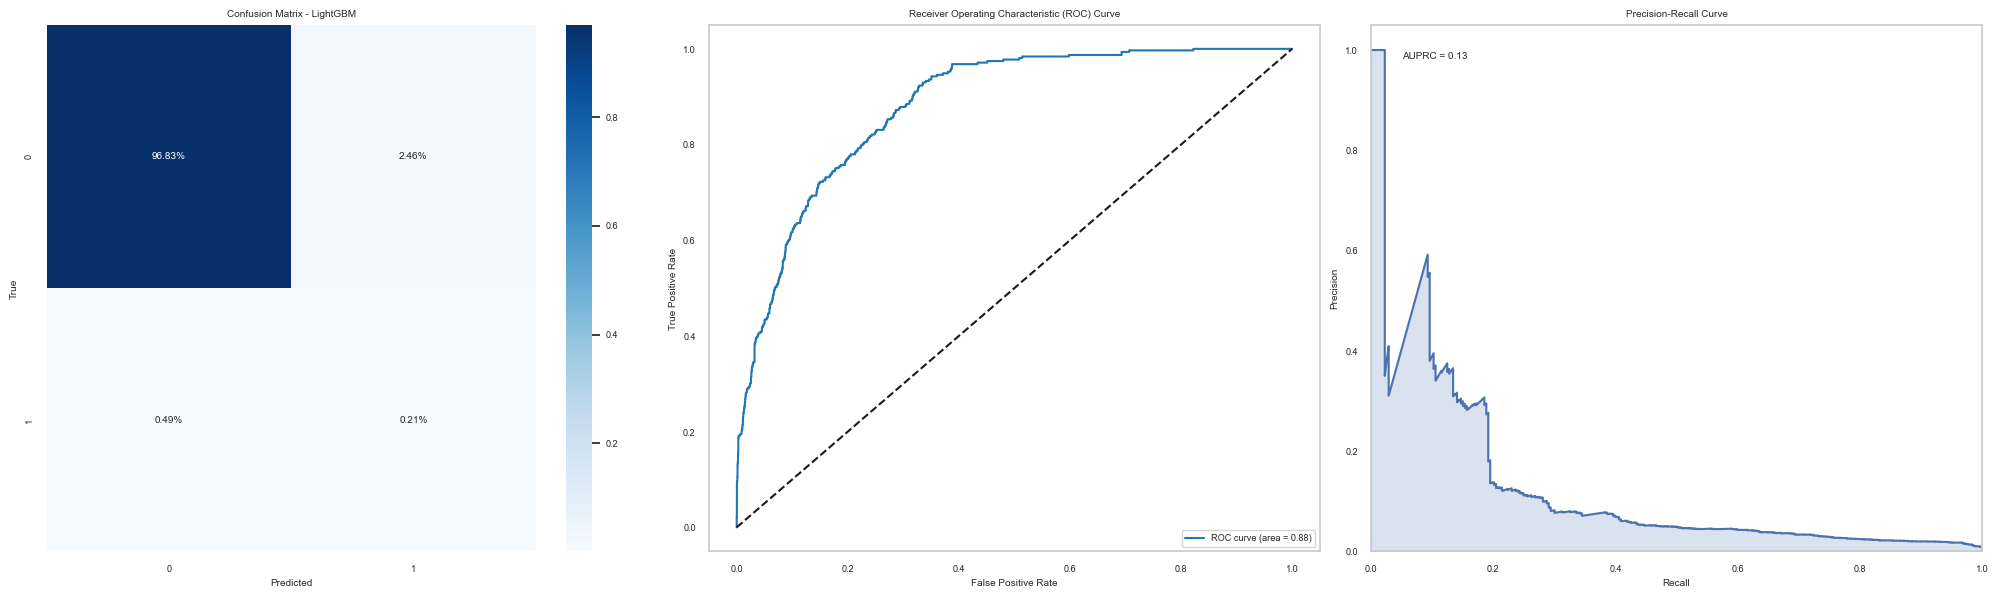

Model LightGBM Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.98      0.98     44244
        True       0.08      0.30      0.12       313

    accuracy                           0.97     44557
   macro avg       0.54      0.64      0.55     44557
weighted avg       0.99      0.97      0.98     44557



In [105]:
trained_models = {}
for model_name in model_trials:
    print(f"\nModel: {model_name}")
    model = joblib.load(f"exports/model_AUPRC_{model_name}.joblib")
    trained_models[model_name], results_df = evaluate_model(
        model, X, y, splitter, cols_remove, get_feature_importances=False
    )
    visualize_performance(
        results_df["true"], results_df["pred"], results_df["pred_proba"], model_name
    )
    print(f"Model {model_name} Classification Report:")
    print(classification_report(results_df["true"], results_df["pred"]))

<div class="results">
    <h3>Model Results</h3>
    <p>Tuned Models</p>
    <ol>
        <ul>All models, besides <code>BalancedRandomForest</code> improved through model tuning</ul>
        <ul>Neural Network and Logistic Regression have great precision with a more manageable false positives rate</ul>
        <ul>LightGBM has a significantly lower false positives rate, yet it only identified less than 50% of fraud cases correctly</ul>
        <ul>Balanced Random Forest did not benefit from tuning</ul>
    </ol>
</div>

## Class Imbalance Handling
Next, let's try out various class imbalance handling methods. We will test the following for each tuned model:
* Undersampling (`RandomUnderSampler`)
* Oversampling (`RandomOverSampler`)
* Class Weights

In [106]:
imbalance_methods = {
    "US": "undersampler",
    "OS": "oversampler",
    "CW": "cost",
    "RWO": "randomwalk",
}

for suffix, imbalance_method in imbalance_methods.items():
    print(f"\nImbalance Method: {imbalance_method}")
    for model_name in model_trials.keys():
        model = joblib.load(f'exports/model_AUPRC_{model_name}.joblib')
        results_df = train_model(
            X=X,
            y=y,
            cv_splitter=splitter,
            model=model,
            model_name=model_name,
            production_model=True,
            cols_remove=cols_remove,
            imbalance_handling=imbalance_method,
        )
        df_performance_auprc = summarize_results(
            model_name,
            df_performance_auprc,
            results_df,
            column_name=suffix,
        )

df_performance_auprc


Imbalance Method: undersampler
Balanced Random Forest trained in 75.37 seconds.
AUPRC: 0.0226

Neural Network trained in 71.79 seconds.
AUPRC: 0.0374

Logistic Regression trained in 70.24 seconds.
AUPRC: 0.1487

LightGBM trained in 70.69 seconds.
AUPRC: 0.5035


Imbalance Method: oversampler
Balanced Random Forest trained in 642.3 seconds.
AUPRC: 0.038

Neural Network trained in 141.98 seconds.
AUPRC: 0.0572

Logistic Regression trained in 107.13 seconds.
AUPRC: 0.2079

LightGBM trained in 154.67 seconds.
AUPRC: 0.0482


Imbalance Method: cost
Balanced Random Forest trained in 86.03 seconds.
AUPRC: 0.0428

Neural Network trained in 109.49 seconds.
AUPRC: 0.0731

Logistic Regression trained in 223.48 seconds.
AUPRC: 0.1555

LightGBM trained in 120.26 seconds.
AUPRC: 0.1269


Imbalance Method: randomwalk
Balanced Random Forest trained in 85.82 seconds.
AUPRC: 0.0428

Neural Network trained in 109.35 seconds.
AUPRC: 0.0731

Logistic Regression trained in 229.17 seconds.
AUPRC: 0.1555

Li

Model  Baseline  Post-Fe   US   OS   CW  RWO
0                LightGBM      0.03     0.05 0.50 0.05 0.13 0.13
1  Balanced Random Forest      0.04     0.04 0.02 0.04 0.04 0.04
2          Neural Network      0.02     0.01 0.04 0.06 0.07 0.07
3     Logistic Regression      0.02     0.04 0.15 0.21 0.16 0.16


Model Name: LightGBM, Imbalance Method: randomwalk
LightGBM trained in 152.77 seconds.
AUPRC: 0.1269



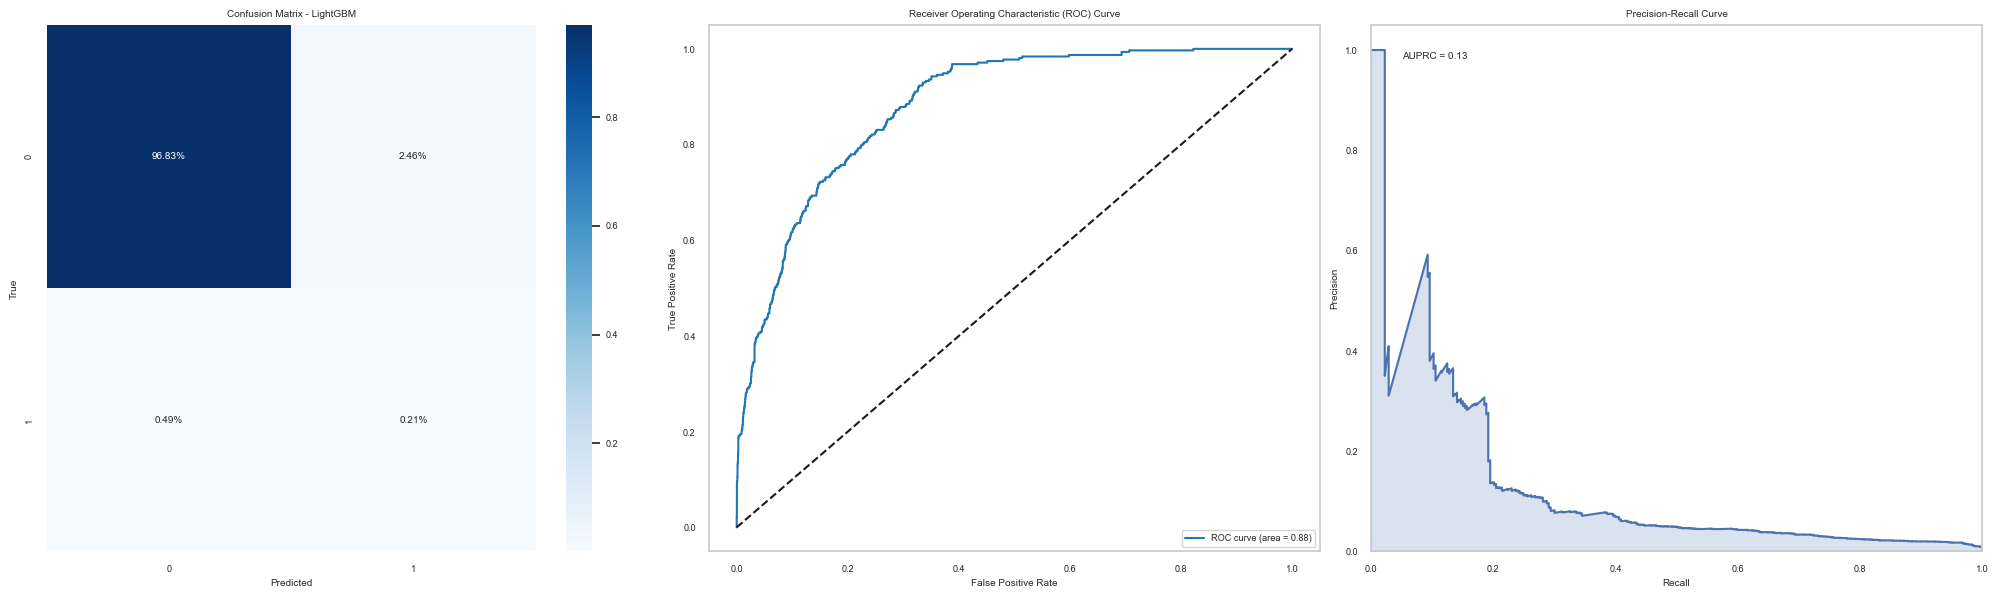


Model Name: Balanced Random Forest, Imbalance Method: None
Balanced Random Forest trained in 95.0 seconds.
AUPRC: 0.0428



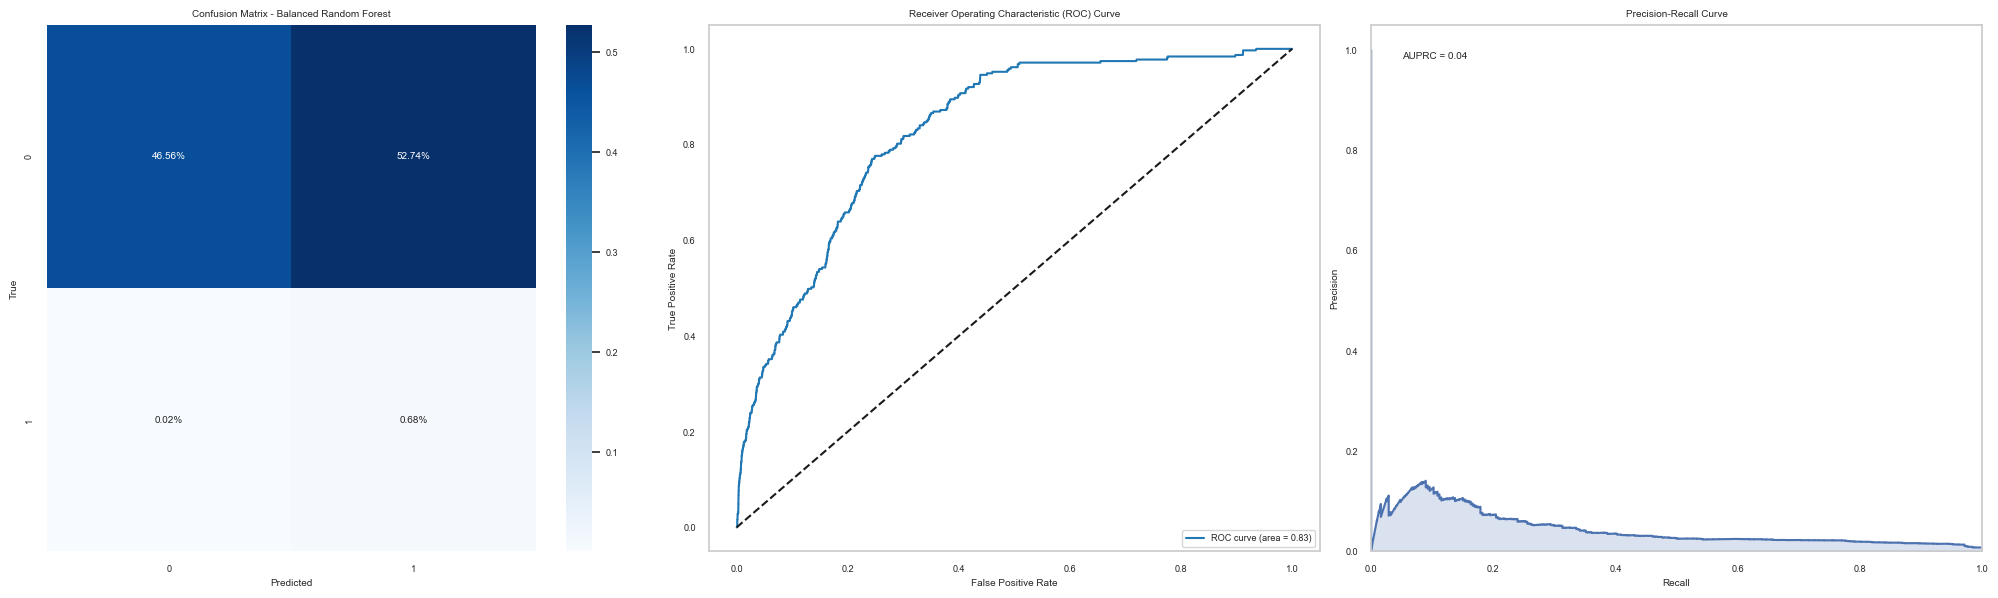


Model Name: Neural Network, Imbalance Method: oversampler
Neural Network trained in 153.02 seconds.
AUPRC: 0.0572



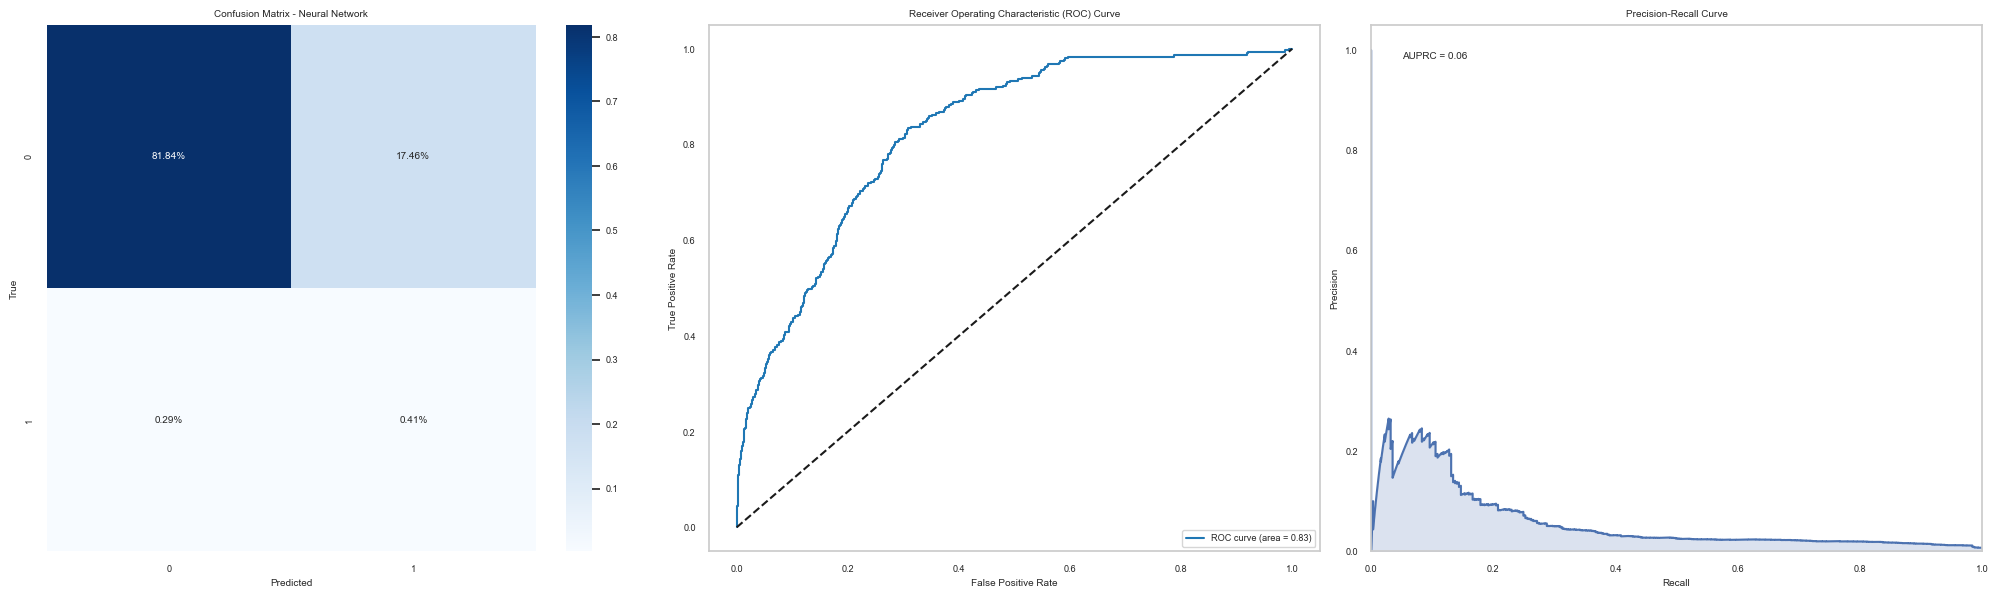


Model Name: Logistic Regression, Imbalance Method: oversampler
Logistic Regression trained in 120.88 seconds.
AUPRC: 0.2079



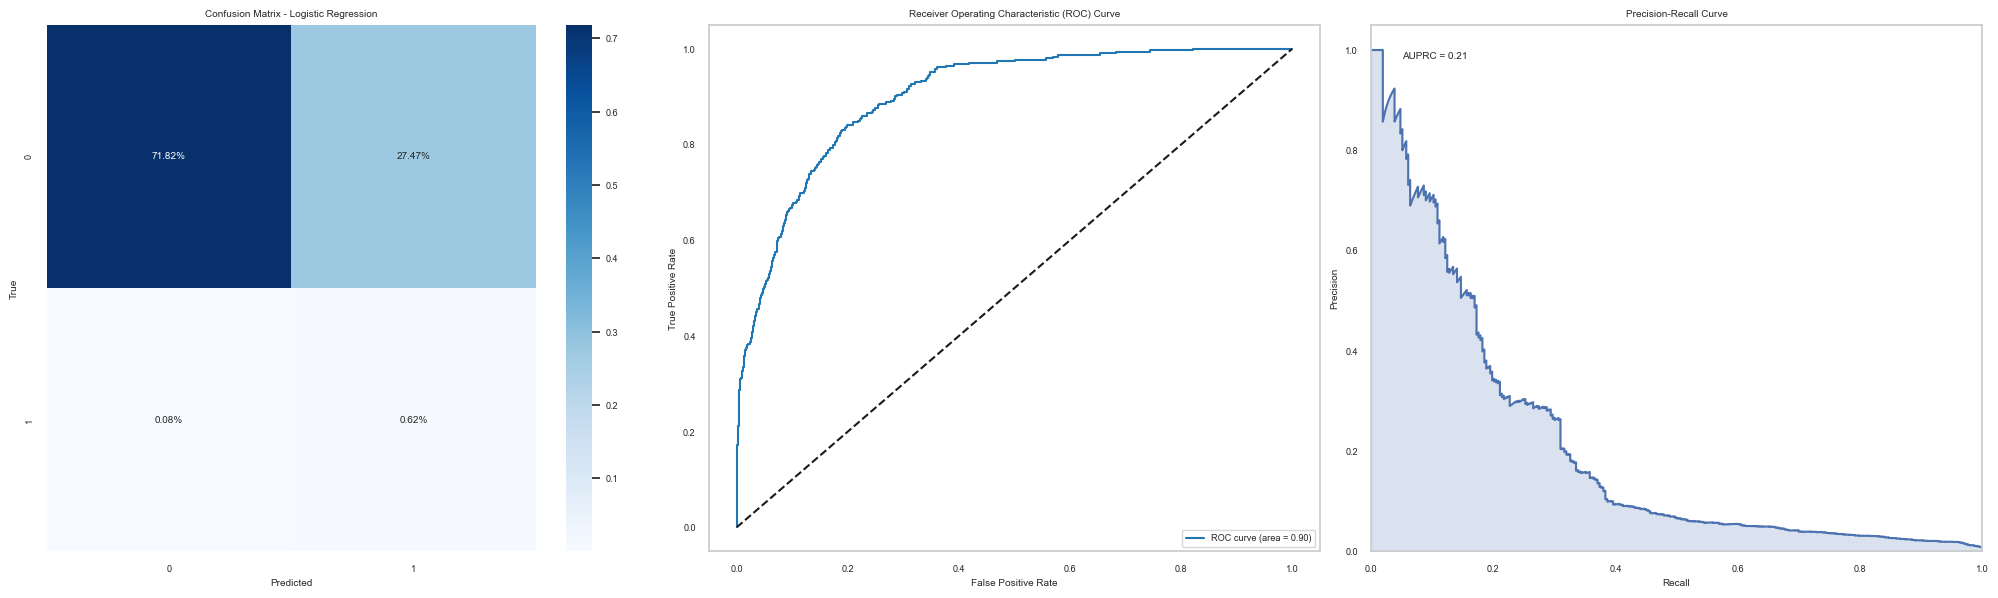

In [111]:
imbalance_params = {
    "LightGBM": "randomwalk",
    "Balanced Random Forest": None,
    "Neural Network": "oversampler",
    "Logistic Regression": "oversampler",
}

for model_name, imbalance_method in imbalance_params.items():
    print(f"\nModel Name: {model_name}, Imbalance Method: {imbalance_method}")
    model = joblib.load(f'exports/model_AUPRC_{model_name}.joblib')
    results_df = train_model(
        X=X,
        y=y,
        cv_splitter=splitter,
        model=model,
        model_name=model_name,
        production_model=True,
        cols_remove=cols_remove,
        imbalance_handling=imbalance_method,
        export_model=True
    )
    visualize_performance(
        y=results_df["true"],
        y_pred=results_df["pred"],
        y_pred_proba=results_df["pred_proba"],
        model_name=model_name
    )

Let's try ensembling to combine the strengths of each model.

## Ensemble Methods
### Ensemble Voting Classifier
We will combine the models' predictions using a `VotingClassifier`. We will use all models except the optuna version of `BalancedRandomForestClassifier`, since it performed worst in terms of false positives. Instead, we will train another `BalancedRandomForestClassifier` on the feature engineered dataset, but without any tuning.

Additionally, we will train three `VotingClassifier` models with optimal weights for the following metrics:
* AUPRC (Average precision)
* F1 score
* Precision at 85% recall

This should give us more variety and challenge our selected metric in terms of business priorities and applicability.

In [112]:
if TRAIN_VOTING:
    vote_models = [
        ("nn", joblib.load("exports/model_Neural Network.joblib")),
        ("lgbm", joblib.load("exports/model_LightGBM.joblib")),
        ("lr", joblib.load("exports/model_Logistic Regression.joblib")),
        ("brf", joblib.load("exports/model_Balanced Random Forest.joblib")),
    ]

#### Ensemble Voting - AUPRC
First, let's train a `VotingClassifier` optimized for AUPRC.


Optimal weights for average_precision:
nn: 0.0122
lgbm: 0.2447
lr: 0.7431
brf: 0.0000
AUPRC: 0.1849
Total training time: 420.63 seconds.


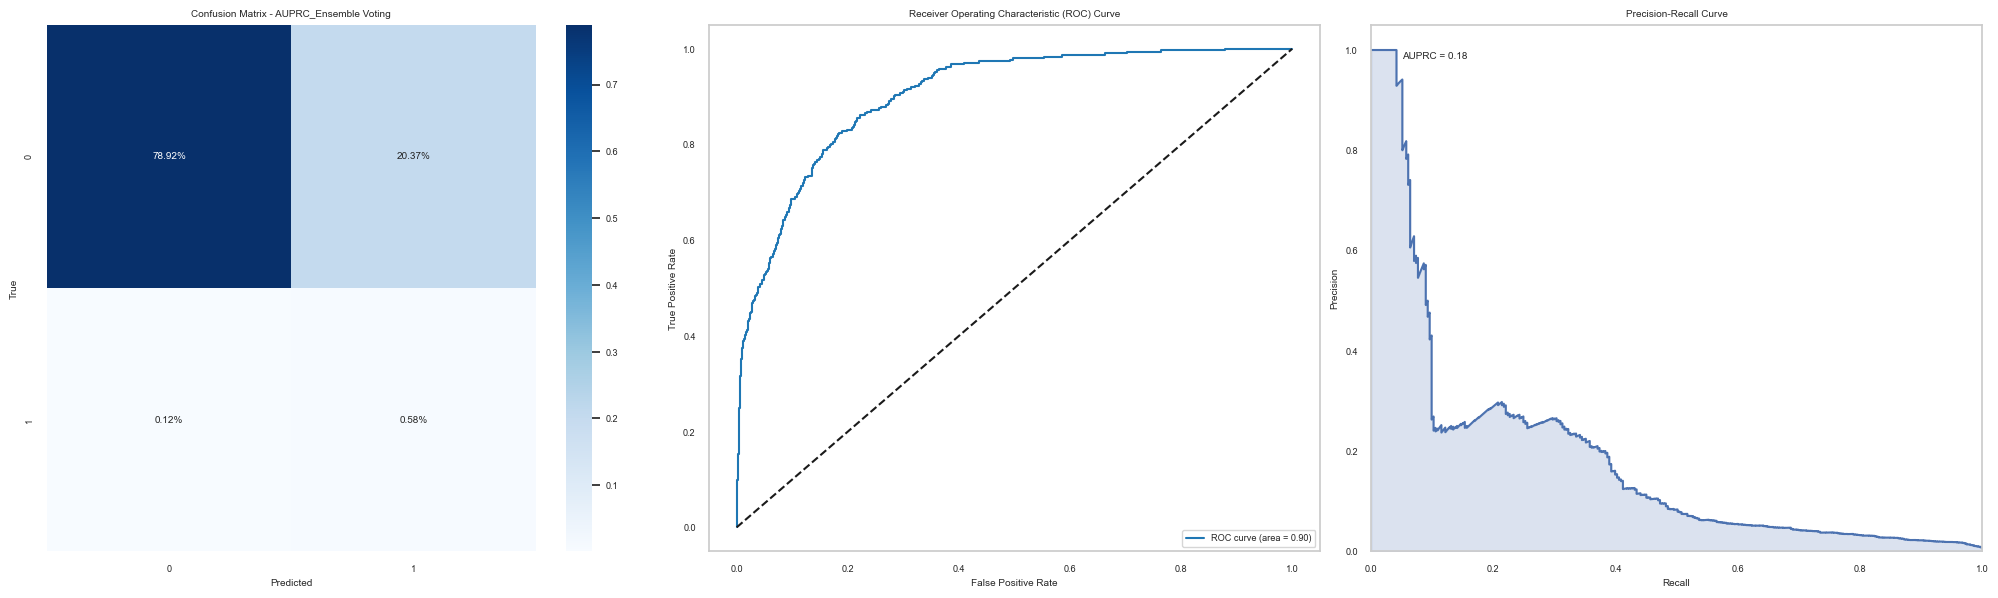

              precision    recall  f1-score   support

       False       1.00      0.79      0.89     44244
        True       0.03      0.83      0.05       313

    accuracy                           0.80     44557
   macro avg       0.51      0.81      0.47     44557
weighted avg       0.99      0.80      0.88     44557



In [113]:
if TRAIN_VOTING:
    optimal_weights_auprc = optimize_ensemble_weights(
        X=X,
        y=y,
        models=vote_models,
        splitter=splitter,
        cols_remove=cols_remove,
        metric="average_precision",
    )
    model_name = "AUPRC_Ensemble Voting"
    ensemble_voting_auprc = VotingClassifier(
        estimators=vote_models,
        voting="soft",
        weights=optimal_weights_auprc,
    )

    trained_models[model_name], results_df_auprc = evaluate_model(
        ensemble_voting_auprc, X, y, splitter, cols_remove
    )
    visualize_performance(
        results_df_auprc["true"],
        results_df_auprc["pred"],
        results_df_auprc["pred_proba"],
        model_name,
    )
    print(classification_report(results_df_auprc["true"], results_df_auprc["pred"]))
else:
    display(Image("media/voting_classifier_auprc.png"))

<div class="results">
    <h3>Model Results</h3>
    <p>Voting Classifier - AUPRC</p>
    <ol>
        <ul>The meta-estimator chose Logistic Regression as the main meta-model</ul>
        <ul>About 88% of fraud cases are captured by the model, a decent score</ul>
        <ul>False positives are at 27%, leaving desire for improvements</ul>
        <ul>A very solid AUPRC of 0.23 signals that the model is relatively more confident in predicting fraud cases</ul>
    </ol>
</div>

#### Ensemble Voting - Precision at 80% recall


Optimal weights for precision_at_recall:
nn: 0.0000
lgbm: 0.0000
lr: 1.0000
brf: 0.0000
AUPRC: 0.1555
Total training time: 426.53 seconds.


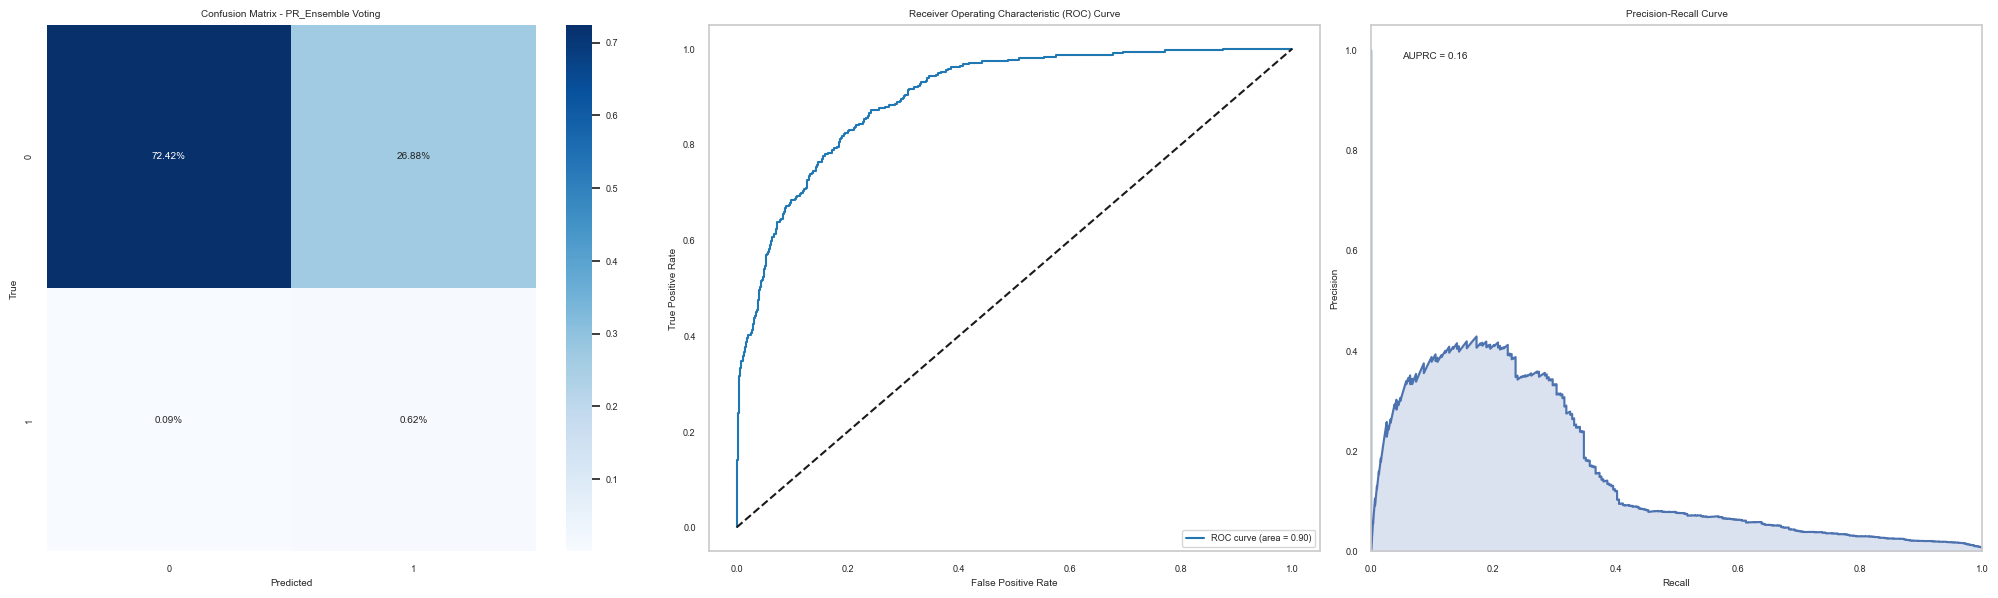

              precision    recall  f1-score   support

       False       1.00      0.73      0.84     44244
        True       0.02      0.88      0.04       313

    accuracy                           0.73     44557
   macro avg       0.51      0.80      0.44     44557
weighted avg       0.99      0.73      0.84     44557



In [114]:
if TRAIN_VOTING:
    optimal_weights_pr = optimize_ensemble_weights(
        X=X,
        y=y,
        models=vote_models,
        splitter=splitter,
        cols_remove=cols_remove,
        metric="precision_at_recall",
        recall_threshold=0.80,
    )
    model_name = "PR_Ensemble Voting"
    ensemble_voting_pr = VotingClassifier(
        estimators=vote_models, voting="soft", weights=optimal_weights_pr
    )

    trained_models[model_name], results_df_pr = evaluate_model(
        ensemble_voting_pr, X, y, splitter, cols_remove
    )
    visualize_performance(
        results_df_pr["true"],
        results_df_pr["pred"],
        results_df_pr["pred_proba"],
        model_name,
    )
    print(classification_report(results_df_pr["true"], results_df_pr["pred"]))
else:
    display(Image("media/voting_classifier_pr.png"))

<div class="results">
    <h3>Model Results</h3>
    <p>Voting Classifier - Precision at 85% recall</p>
    <ol>
        <ul>The true positives rate is same as AUPRC, is at 92% of fraud instances identified correctly; However, the false positives increased</ul>
        <ul>AUPRC is moderate; the model is not very confident in differentiating groups</ul>
    </ol>
</div>

#### Ensemble Voting - F1 score


Optimal weights for f1:
nn: 0.0000
lgbm: 0.9339
lr: 0.0000
brf: 0.0661
AUPRC: 0.1263
Total training time: 414.10 seconds.


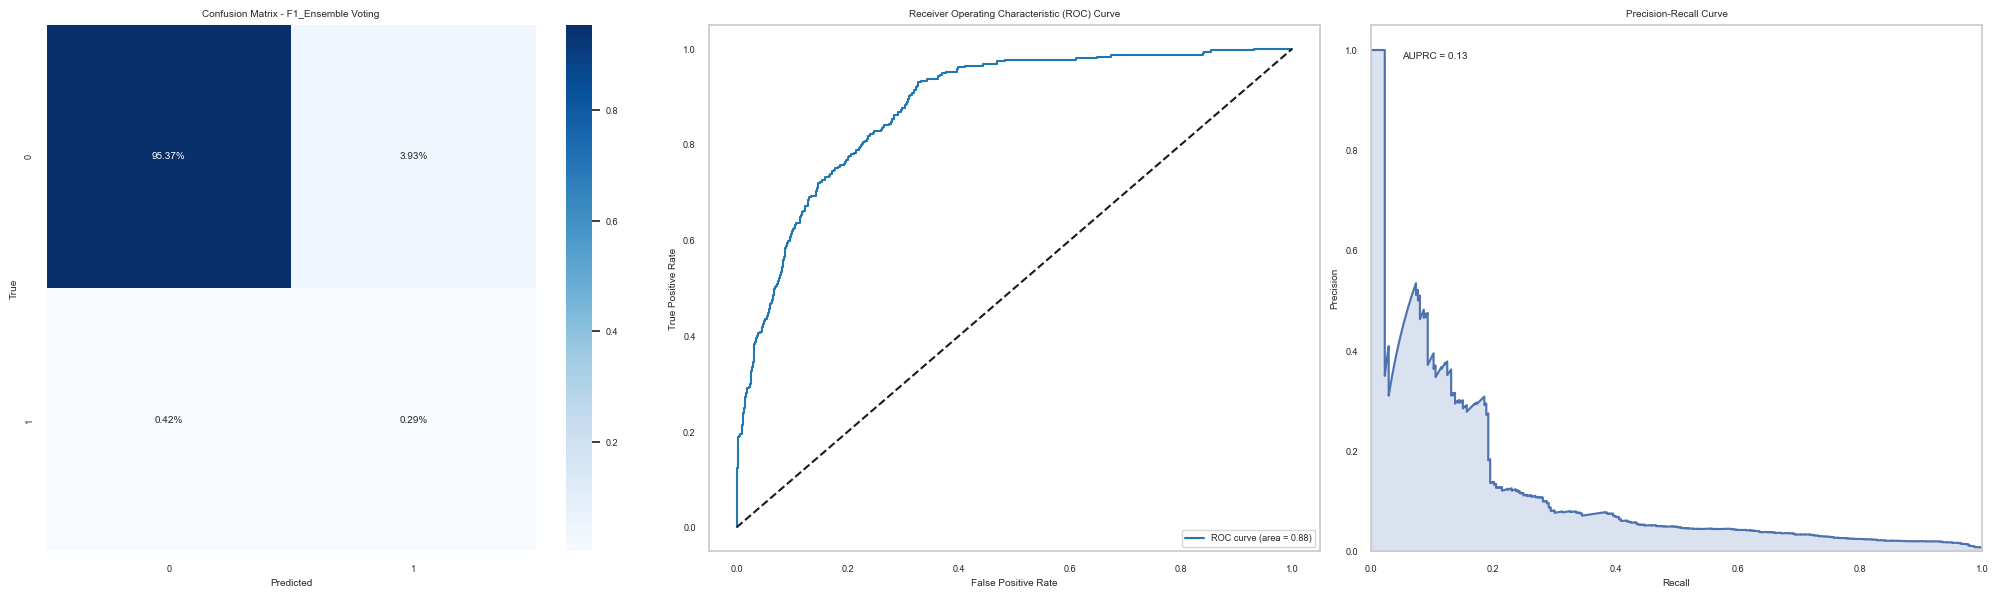

              precision    recall  f1-score   support

       False       1.00      0.96      0.98     44244
        True       0.07      0.41      0.12       313

    accuracy                           0.96     44557
   macro avg       0.53      0.68      0.55     44557
weighted avg       0.99      0.96      0.97     44557



In [115]:
if TRAIN_VOTING:
    optimal_weights_f1 = optimize_ensemble_weights(
        X=X,
        y=y,
        models=vote_models,
        splitter=splitter,
        cols_remove=cols_remove,
        metric="f1",
    )
    model_name = "F1_Ensemble Voting"
    ensemble_voting_f1 = VotingClassifier(
        estimators=vote_models, voting="soft", weights=optimal_weights_f1
    )

    trained_models[model_name], results_df = evaluate_model(
        ensemble_voting_f1, X, y, splitter, cols_remove
    )
    visualize_performance(
        results_df["true"], results_df["pred"], results_df["pred_proba"], model_name
    )
    print(classification_report(results_df["true"], results_df["pred"]))
else:
    display(Image("media/voting_classifier_f1.png"))

<div class="results">
    <h3>Model Results</h3>
    <p>Voting Classifier - F1 score</p>
    <ol>
        <ul>Poor true positives rate which is not business feasible, regardless of the decent false positives rate</ul>
        <ul>AUPRC is lower than previous models</ul>
    </ol>
</div>

#### Ensemble Voting - Fbeta 1.5
Let's try to create a model that gives more weight to optimizing recall. F-beta introduces a parameter β that determines the relative importance of recall to precision:

Fβ = (1 + β²) * (precision * recall) / ((β² * precision) + recall)


Optimal weights for fbeta:
nn: 0.1401
lgbm: 0.2194
lr: 0.4947
brf: 0.1459
AUPRC: 0.1662
Total training time: 418.76 seconds.


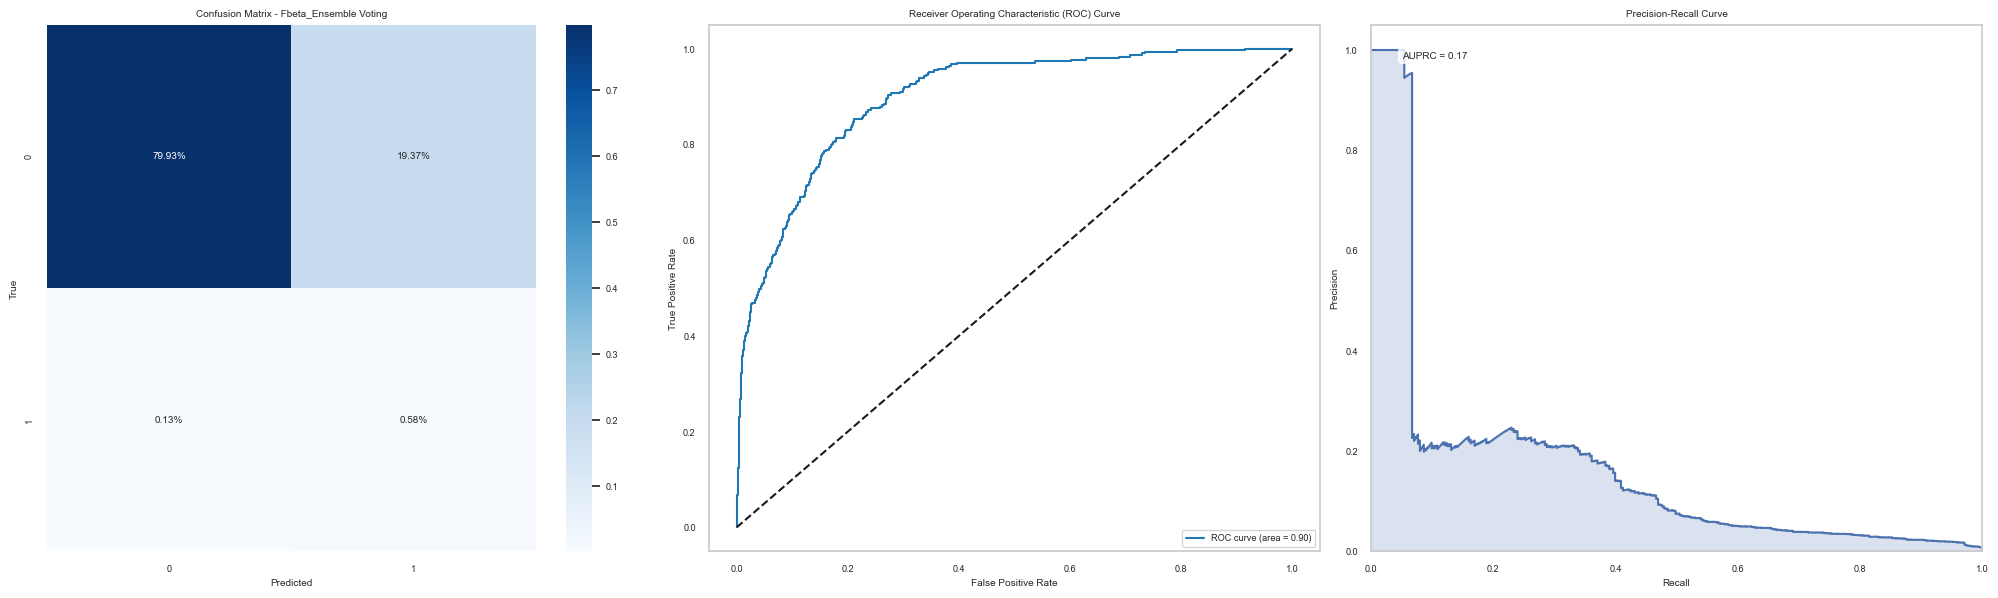

              precision    recall  f1-score   support

       False       1.00      0.80      0.89     44244
        True       0.03      0.82      0.06       313

    accuracy                           0.81     44557
   macro avg       0.51      0.81      0.47     44557
weighted avg       0.99      0.81      0.89     44557



In [116]:
if TRAIN_VOTING:
    optimal_weights_fbeta = optimize_ensemble_weights(
        X=X,
        y=y,
        models=vote_models,
        splitter=splitter,
        cols_remove=cols_remove,
        metric="fbeta",
        beta=1.5,
    )
    model_name = "Fbeta_Ensemble Voting"
    ensemble_voting_fbeta = VotingClassifier(
        estimators=vote_models, voting="soft", weights=optimal_weights_fbeta
    )

    trained_models[model_name], results_df = evaluate_model(
        ensemble_voting_fbeta, X, y, splitter, cols_remove
    )
    visualize_performance(
        results_df["true"], results_df["pred"], results_df["pred_proba"], model_name
    )
    print(classification_report(results_df["true"], results_df["pred"]))
else:
    display(Image("media/voting_classifier_fbeta.png"))

<div class="results">
    <h3>Model Results</h3>
    <p>Voting Classifier - Fbeta</p>
    <ol>
        <ul>Contrary to other models, the Fbeta model utilizes Neural Network and Balanced Random Forest to make predictions</ul>
        <ul>The model identifies 90% of the fraud values correctly, although the false positives rate is large</ul>
        <ul>AUPRC is decent compared to other ensemble variations</ul>
    </ol>
</div>

#### Ensemble Voting - Equal weights
Finally, let's see the performance of a `VotingClassifier` that assigns equal weights to all four models.

AUPRC: 0.1385
Total training time: 405.00 seconds.


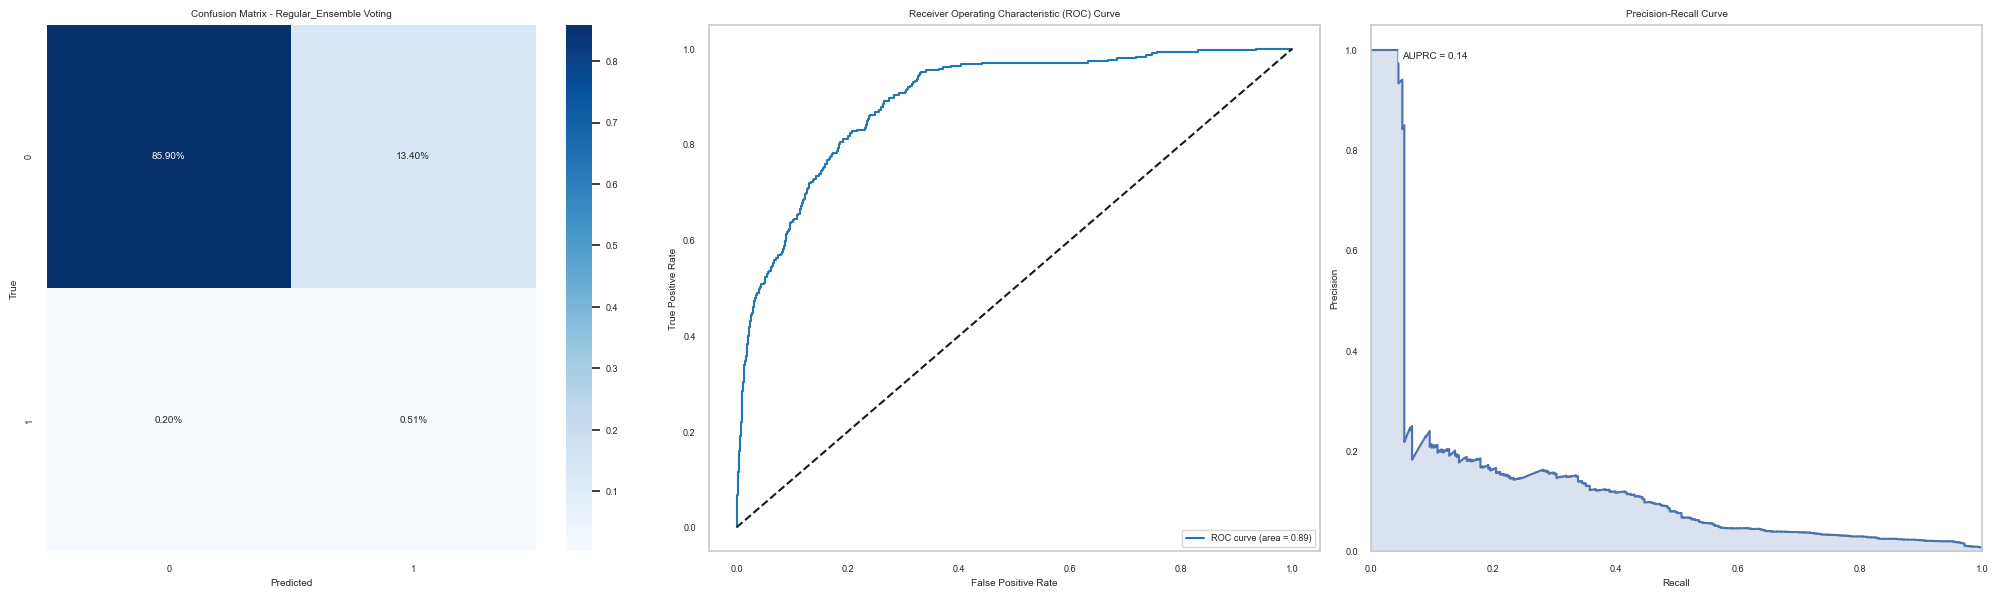

              precision    recall  f1-score   support

       False       1.00      0.87      0.93     44244
        True       0.04      0.72      0.07       313

    accuracy                           0.86     44557
   macro avg       0.52      0.79      0.50     44557
weighted avg       0.99      0.86      0.92     44557



In [117]:
if TRAIN_VOTING:
    model_name = "Regular_Ensemble Voting"
    ensemble_voting_reg = VotingClassifier(
        estimators=vote_models,
        voting="soft",
    )

    trained_models[model_name], results_df = evaluate_model(
        ensemble_voting_reg, X, y, splitter, cols_remove
    )
    visualize_performance(
        results_df["true"], results_df["pred"], results_df["pred_proba"], model_name
    )
    print(classification_report(results_df["true"], results_df["pred"]))
else:
    display(Image("media/voting_classifier_regular.png"))

<div class="results">
    <h3>Model Results</h3>
    <p>Voting Classifier - Equal weights</p>
    <ol>
        <ul>The model identifies 91% of the fraud values correctly, with a respectable false positives rate</ul>
        <ul>AUPRC is low compared to other Voting Classifier variations, which may indicate problems in differentiating between the two classes</ul>
    </ol>
</div>

### Stacking Classifier
Next, let's train a `StackingClassifier`, with `LightGBM` being the final estimator.

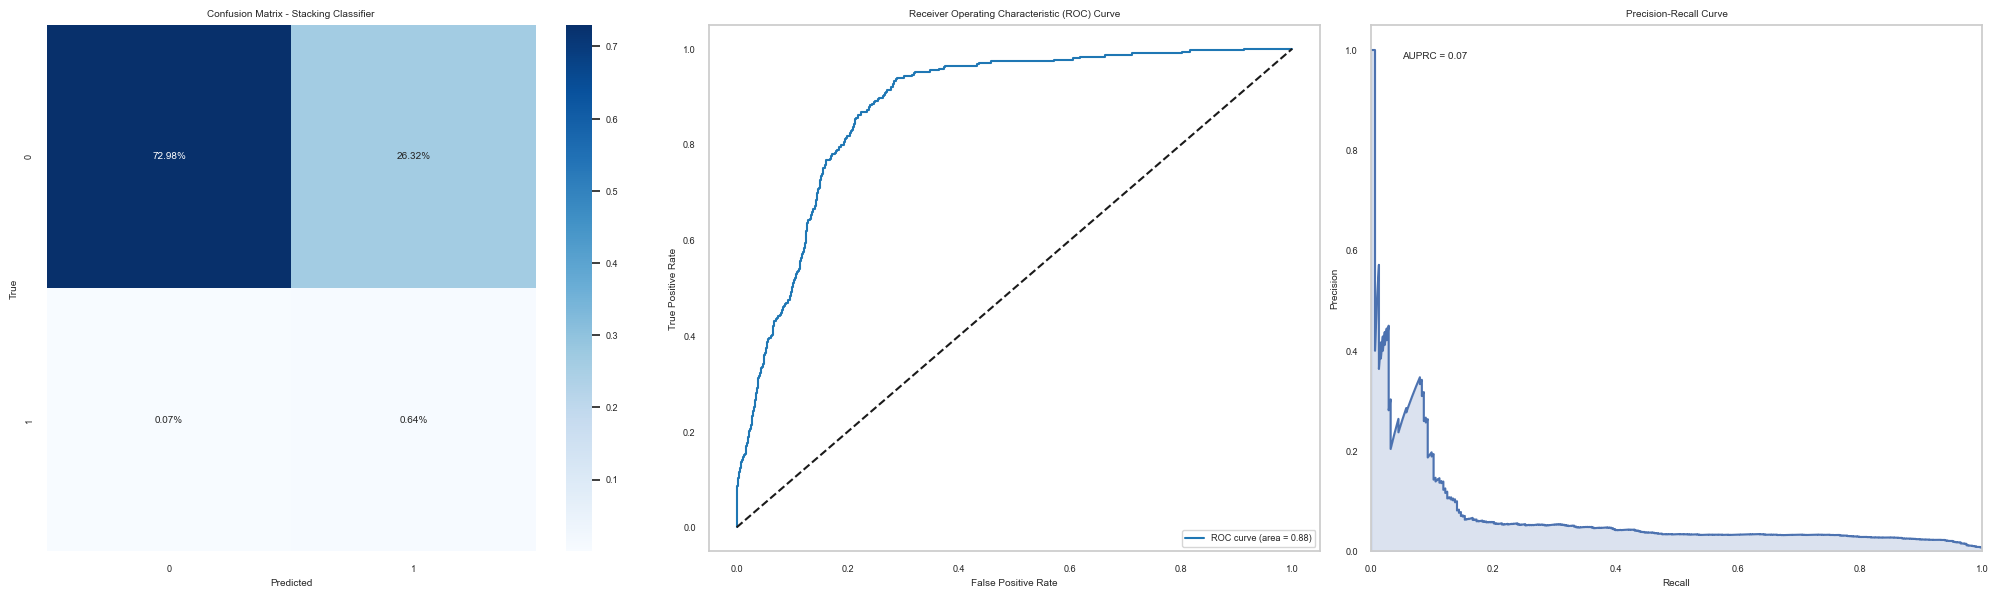

In [ ]:
if TRAIN_STACKING:
    model_name = "Stacking Classifier"
    stacking = StackingClassifier(
        estimators=[
            ("lgbm", trained_models["LightGBM"]),
            ("nn", trained_models["Neural Network"]),
            ("brf", trained_models["Balanced Random Forest"]),
        ],
        final_estimator=trained_models["Logistic Regression"],
        cv=5,
        stack_method="predict_proba",
    )
    trained_models[model_name], results_df = evaluate_model(
        stacking, X, y, splitter, cols_remove
    )
    visualize_performance(
        results_df["true"], results_df["pred"], results_df["pred_proba"], model_name
    )
    print(classification_report(results_df["true"], results_df["pred"]))
else:
    display(Image("media/stacking_classifier.png"))

<div class="results">
    <h3>Model Results</h3>
    <p>Stacking Classifier - Logistic Regression estimator</p>
    <ol>
        <ul>The model has very similar true positives and false negatives rate, but a bigger false positives rate</ul>
        <ul>Voting Classifier with AUPRC performs similarly in false and true positives, but with a much better AUPRC</ul>
    </ol>
</div>

## Model Feature Importance & Class Distinction
For further analysis, we will work with the following models:
* Voting Classifier (AUPRC optimized)
* Voting Classifier (Precision at 80% recall)

### Voting Classifier (AUPRC Optimized)
First, let's look at the features which it deemed important in predicting fraud.

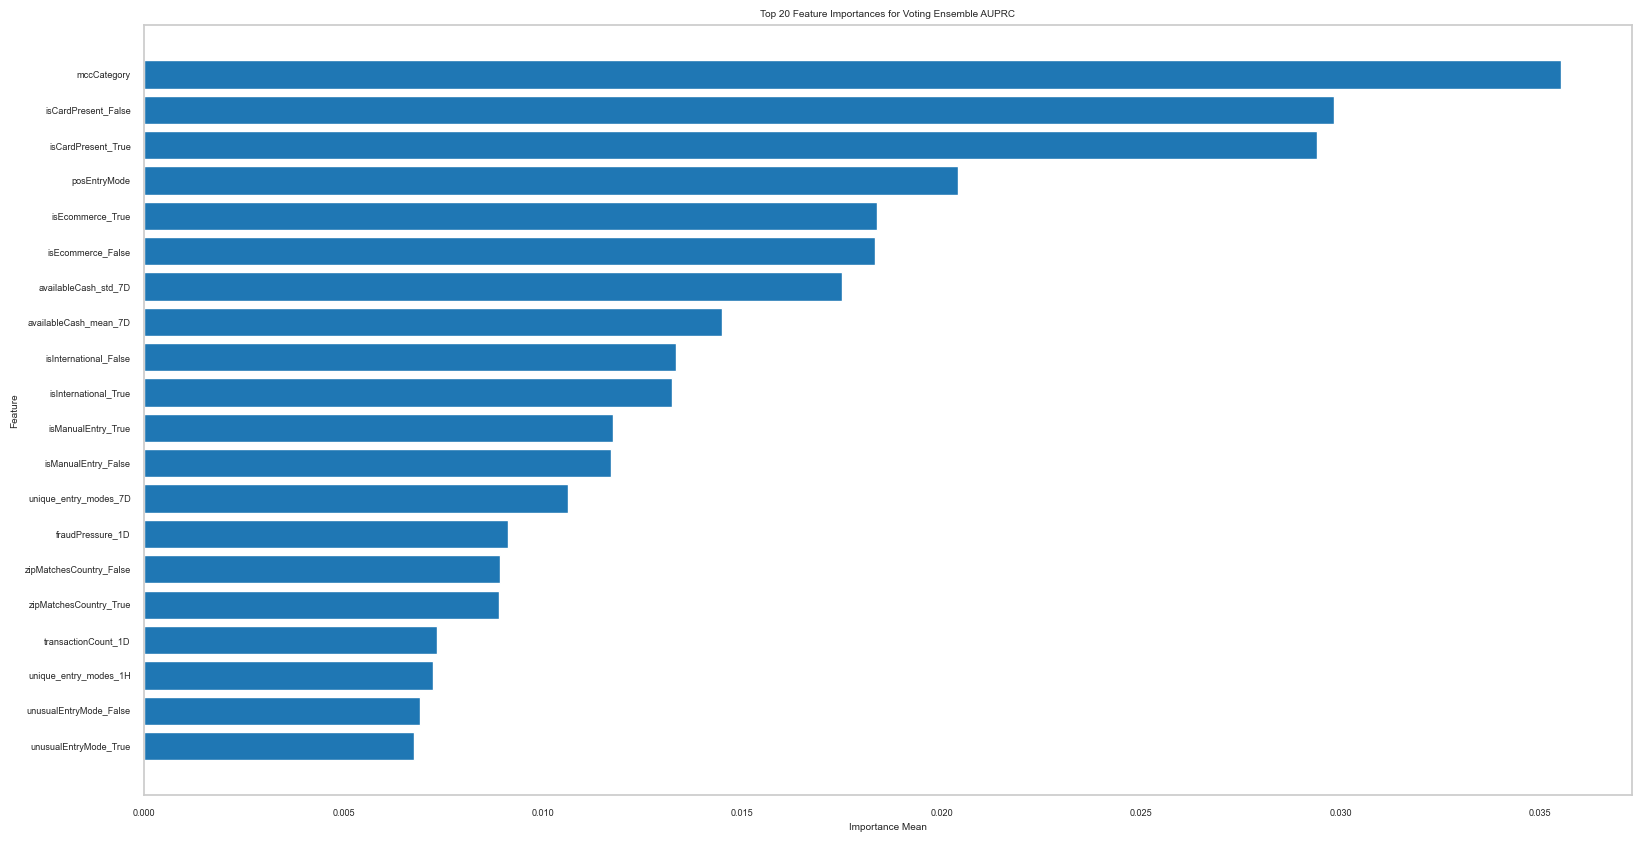

In [ ]:
if CALCULATE_SHAP:
    _, _, importances_df_auprc = evaluate_model(
        ensemble_voting_auprc, X, y, splitter, cols_remove, get_feature_importances=True
    )
    plot_model_importances(
        importances_df_auprc, top_n=20, model_name="Voting Ensemble AUPRC"
    )
else:
    display(Image("media/feature_importances_auprc.png"))

<div class="results">
    <h3>Model Results</h3>
    <p>Voting Classifier (AUPRC) - Feature Importances</p>
    <ol>
        <ul><code>mccCategory</code> is the most important feature for the model, followed by indicators whether a physical card was used and the POS mode</ul>
        <ul>eCommerce flags are most important among specific MCC categories</ul>
        <ul>Contrary to findings in EDA, 7-day aggregations are useful in this model in predicting fraud cases</ul>
    </ol>
</div>

Also, let's check how well it differentiates between both classes.

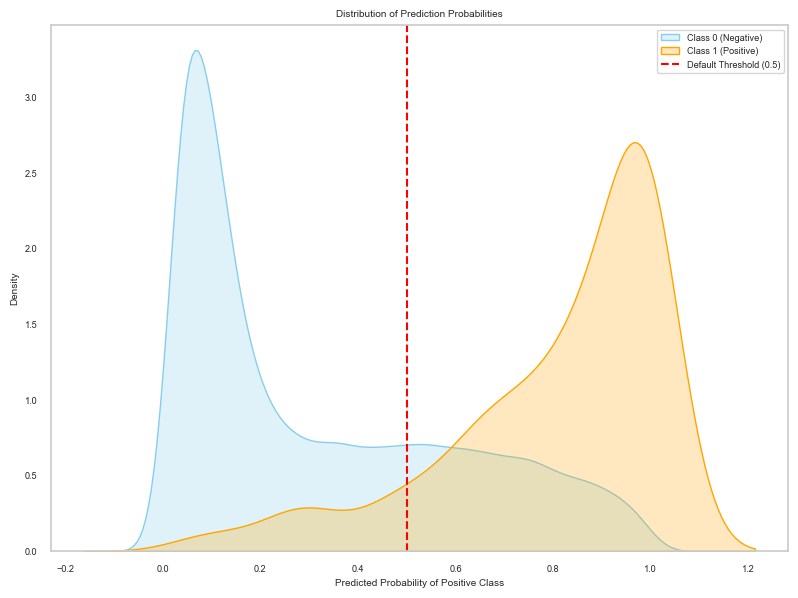

In [ ]:
plot_probability_distribution(results_df_auprc["true"], results_df_auprc["pred_proba"])

<div class="results">
    <h3>Model Results</h3>
    <p>Voting Classifier (AUPRC) - Class differentiation</p>
    <ol>
        <ul><code>mccCategory</code> has the biggest importance, but it is also very volatile. Other notable features include the use of a Credit Card and merchant diversity for the client</ul>
        <ul>Contrary to initial findings in EDA, 7-day aggregations have significant importance in predicting fraud cases</ul>
        <ul>The model seems to differentiate both classes confidently (as observed by the steep curve in both classes), although the false positives problem is evident</ul>
    </ol>
</div>

### Voting Classifier (Precision at 80% recall optimized)
Next, let's look at the most important features for the precision at 80% recall optimized model.

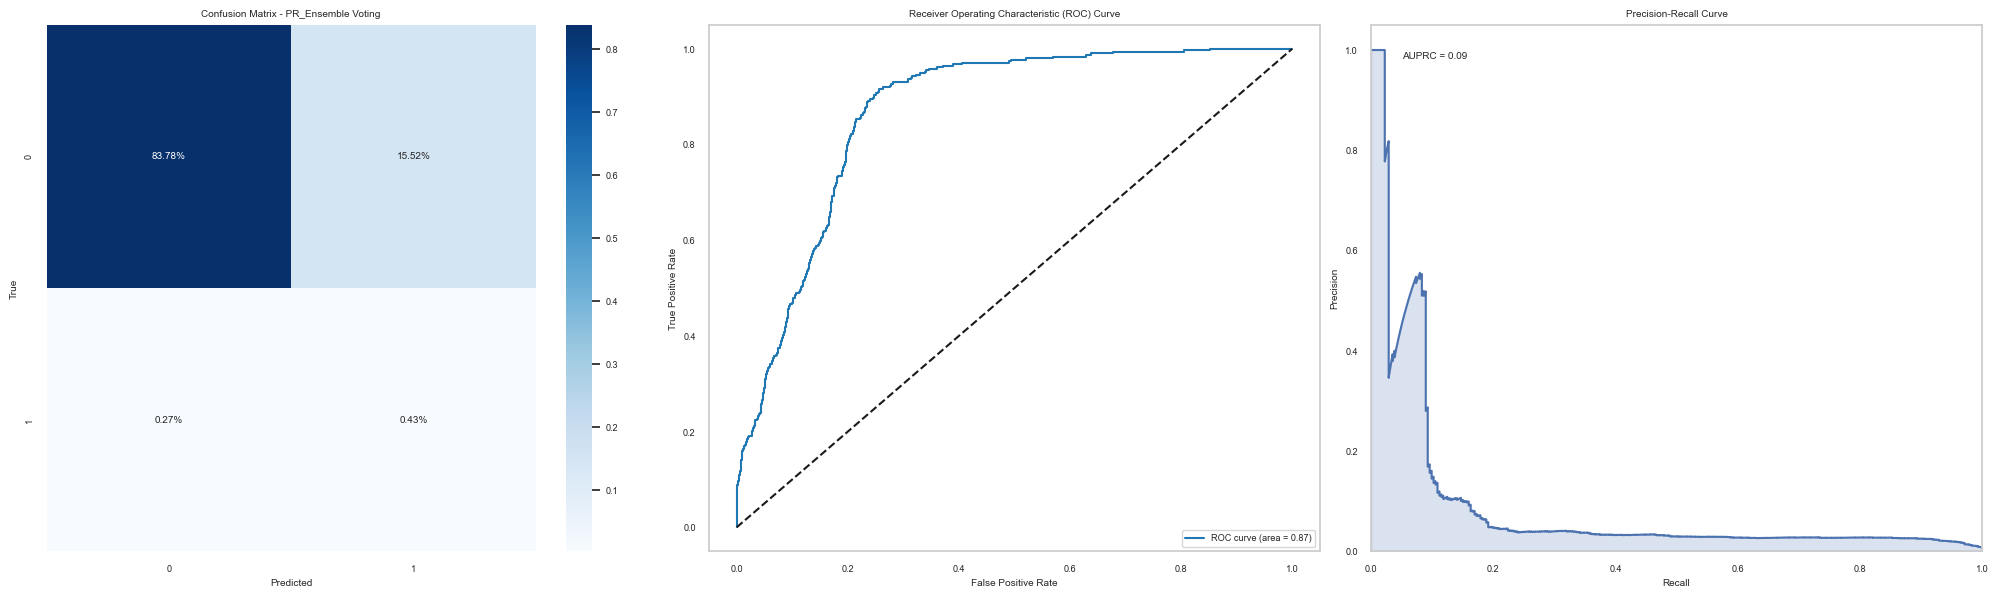

In [ ]:
if CALCULATE_SHAP:
    _, _, importances_df_pr = evaluate_model(
        ensemble_voting_pr, X, y, splitter, cols_remove, get_feature_importances=True
    )
    plot_model_importances(importances_df_pr, top_n=20, model_name="Voting Ensemble PR")
else:
    display(Image("media/voting_classifier_pr.png"))

<div class="results">
    <h3>Model Results</h3>
    <p>Voting Classifier (Precision at 80% Recall) - Feature Importances</p>
    <ol>
        <ul>eCommerce flags are the most important features, while <code>mccCategory</code> follows second</ul>
        <ul>Feature importances are very similar to the AUPRC tuned model</ul>
        <ul>This model deems more 1-hour aggregations as important in determining fraud</ul>
    </ol>
</div>

Next, let's check the class distribution:

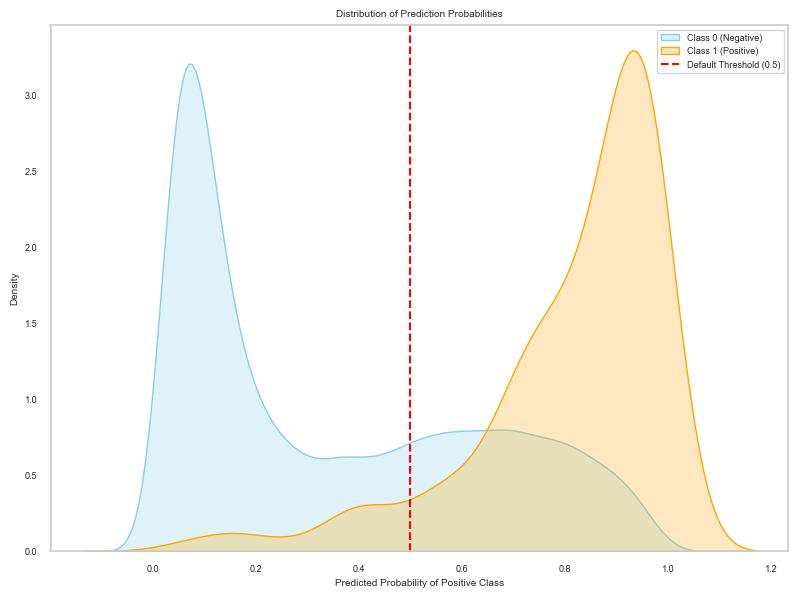

In [ ]:
plot_probability_distribution(results_df_pr["true"], results_df_pr["pred_proba"])

<div class="results">
    <h3>Model Results</h3>
    <p>Voting Classifier (Precision at 80% Recall) - Class Distribution</p>
    <ol>
        <ul>Similarly to the AUPRC optimized model, the model is fairly confident in differentiating classes</ul>
        <ul>However, the model is less confident with the negative class - we see a wider proportion from the 0.5 range</ul>
        <ul>All other things being equal, the AUPRC model has better class distinction</ul>
    </ol>
</div>

# Model Application in Business
We've decided that the AUPRC-tuned model might be best-suited. Let's explore how we can use it in business.

First, let's calculate how many transactions per day we have:

In [ ]:
total_days = (df["transactionTime"].max() - df["transactionTime"].min()).days
total_transactions = df.shape[0]
avg_transactions_per_day = total_transactions / total_days
print(f"Average transactions per day: {avg_transactions_per_day:.0f}")

total_frauds = df[df["fraud"] == True].shape[0]
avg_frauds_per_month = total_frauds / total_days * 30
print(f"Average frauds per month: {avg_frauds_per_month:.0f}")

Average transactions per day: 300
Average frauds per month: 66


We have about 300 transactions per day, which would amount to 9,000 transactions per month. The bank analysts currently have the capacity to manually analyze only 400 transactions per month (4.44% of total), or 13 transactions a day. Let's see whether we can find an application for the model keeping the checks reasonable and the fraud catch rate sufficient.

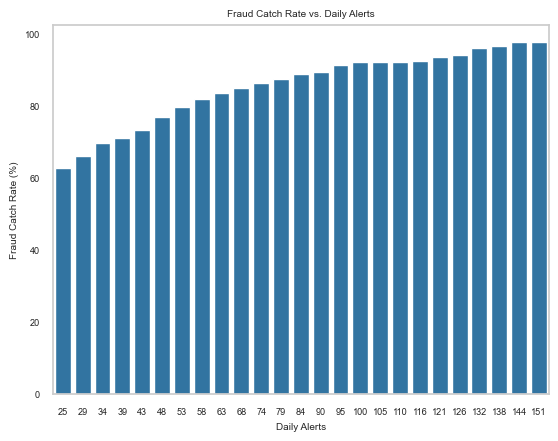

threshold  precision  recall  f1_score  true_positives  false_positives  \
14       0.55       0.02    0.87      0.05             271            10725   
13       0.53       0.02    0.88      0.05             274            11525   
12       0.50       0.02    0.89      0.04             278            12314   
11       0.48       0.02    0.89      0.04             280            13095   
10       0.45       0.02    0.91      0.04             286            13870   
9        0.43       0.02    0.92      0.04             289            14618   
8        0.40       0.02    0.92      0.04             289            15396   
7        0.38       0.02    0.92      0.03             289            16126   
6        0.35       0.02    0.93      0.03             290            16942   
5        0.33       0.02    0.94      0.03             293            17756   
4        0.30       0.02    0.94      0.03             295            18516   
3        0.28       0.02    0.96      0.03             301            19325   
2        0.25       0.01    0.97      0.03             303            20221   
1        0.23       0.01    0.98      0.03             306            21136   
0        0.20       0.01    0.98      0.03             306            22224   

    false_negatives  daily_alerts  fraud_catch_rate  investigation_efficiency  \
14               42            74             86.58                      2.46   
13               39            79             87.54                      2.32   
12               35            84             88.82                      2.21   
11               33            90             89.46                      2.09   
10               27            95             91.37                      2.02   
9                24           100             92.33                      1.94   
8                24           105             92.33                      1.84   
7                24           110             92.33                      1.76   
6                23           116             92.65                      1.68   
5                20           121             93.61                      1.62   
4                18           126             94.25                      1.57   
3                12           132             96.17                      1.53   
2                10           138             96.81                      1.48   
1                 7           144             97.76                      1.43   
0                 7           151             97.76                      1.36   

    alerts_per_fraud  
14             40.58  
13             43.06  
12             45.29  
11             47.77  
10             49.50  
9              51.58  
8              54.27  
7              56.80  
6              59.42  
5              61.60  
4              63.77  
3              65.20  
2              67.74  
1              70.07  
0              73.63

In [ ]:
# Run the analysis
results = analyze_thresholds(
    y_true=results_df_auprc["true"],
    y_pred_proba=results_df_auprc["pred_proba"],
    total_transactions=300,
)
results = results.sort_values(by="fraud_catch_rate")

sns.barplot(x="daily_alerts", y="fraud_catch_rate", data=results)
plt.title("Fraud Catch Rate vs. Daily Alerts")
plt.xlabel("Daily Alerts")
plt.ylabel("Fraud Catch Rate (%)")
plt.show()

results.tail(15)

At 95 checks per day, we are catching 91.4% of fraud cases. Out of 66 average fraud cases per month, the model would capture 60 cases. Of course, this implementation would increase the transaction checking sevenfold, but we have to consider the following:
* The ML model would already flag the suspicious features of the transaction, so the analyst would not have to begin from scratch
* Compared to the traditional checks of 400 transactions per month, the analysts cover less than 5% of transactions per month - this translates to 3 out of 66 fraud cases identified!
* The model is flexible in its confidence - the threshold can be adjusted in favor of catching more fraud cases or reducing daily alert checks during busy periods.

An implementation of the model, with the increased workload would warrant additional headcounts; The much better fraud catch rate will cut costs in the long run and improve the bank's reputation among clients.

If we were to implement the current model at much less checks per month, we would get the following:

In [ ]:
optimal = find_optimal_threshold(results, max_daily_alerts=13)

print_threshold_summary(optimal)

No threshold meets all constraints.


In [ ]:
results.sort_values(by="daily_alerts").head(1)

threshold  precision  recall  f1_score  true_positives  false_positives  \
24       0.80       0.05    0.63      0.10             197             3606   

    false_negatives  daily_alerts  fraud_catch_rate  investigation_efficiency  \
24              116            25             62.94                      5.18   

    alerts_per_fraud  
24             19.30

Our analysis did not consider such low daily alerts to be feasible besides random guessing. The lowest we can go is 25 a day (750 a month) with a fraud catch rate of 63%

Out of the 66 average fraud cases per month, the team would catch about 42.

At this point, it is a decision of choosing to increase the workload to accommodate the suggestions of the model or build a new model from scratch.

# Summary
## Findings
The Bank Transactions dataset had opportunities for extensive feature creation, including time-based features, class imbalance methods application and time-based cross validation techniques. The dataset had less than 0.8% of fraudulent transactions. During the study, we trained 5 separate ML models and tested various class imbalance handling techniques to maximize AUPRC. Logistic Regression with undersampling provided the best results individually.

To maximize performance, we create ensemble models, leveraging the strengths of multiple models. Voting Classifier ensemble had the most tuning flexibility, and we explored different model weights based on metrics to optimize. The AUPRC-tuned Voting Classifier had the best performance, with a good balance of true and false positives, including a very confident class differentiation

To evaluate the model's applicability in business, we defined scenarios with their respective fraud catch rates. We found that analyzing 95 of alerts that the model produces daily would help the bank capture 91% of all fraud cases.


## Considerations
Dataset size - only a year of data
Fraud labelling correctness - were all frauds among 118k+ transactions in the dataset flagged?
Fraud perpetrators are continuously improving their methods - the model will have to be continuously retrained to keep up its performance
Recency of data (Dataset was published 7 years ago, fraud patterns might definitely have changed)
Dataset origin (EU-based, fraud practices might be different elsewhere)

## Improvements for Future Studies
* Increase Optuna trials
* Test dimensionality reduction techniques
* Instead of Mean Encoding, try other methods to see whether performance improves
* Test other ML models, like XGBoost, Isolation Forest
* Consider using more advanced and specialized models (HMM, LSTM/GRU deep learning models, Graph Neural Networks)